In [154]:
import pandas as pd
import os
from glob import glob
import numpy as np
import anndata as ad
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import pearsonr, spearmanr
import matplotlib.colors as mcolors
from matplotlib.colors import ListedColormap, LinearSegmentedColormap

from matplotlib.patches import Patch
from scipy.stats import linregress

import scanpy as sc
import scipy.stats as stats
from scipy.stats import spearmanr
import statsmodels.api as sm
from sklearn.manifold import TSNE
from statsmodels.stats.multitest import fdrcorrection
import umap
import networkx as nx
#import many
from network import nx_plot 

In [183]:
PALETTE = {"AST": "#8aafa9", 
           # "DG":"#ead1dc",
           # "CA1":"#c27ba0",
           # "CA2-3":"#741b47",
           # "Cortical":"#d9d2e9",
           "INH":"#f34c0d",
           # "EXC":"#c27ba0",
           'EXC':"#d9d2e9",
             
            "MIC":"#165f54",
           # "ENDO-Mural":"#ab910b",
           "Endo-Mural":"#ab910b",
           "OLD":"#ffc281"}
palette_exp = {"Tissue":"#2D3047", "Nuclei":"#ffd5c2", "snRNA":"#eef2f3"}

In [158]:
def plot_per_celltype(df_metrics_tot,
                    method,
                    savename,
                    metrics,
                    ):

    start_color = '#FF6B35'
    end_color = '#FFFFFF'

    palette = ["#272300","#443F1C","#746E48","#A9A179","#CDC392","#E8E5DA","#9EB7E5","#648DE5","#304C89"]#, "#08336D"]
    xolorr = "#677CBF"#'#A02c5a'#"#27C196"#"#304C89"
    cmap = mcolors.LinearSegmentedColormap.from_list('my_colormap', palette)
    colors = [start_color, end_color]
    cmap = LinearSegmentedColormap.from_list('my_cmap', palette)

    # Convert colormap to seaborn palette
    n_colors = np.linspace(1,0.1,9)  # Number of colors in the palette
    palette = [cmap(it) for it in n_colors]
    fig, axes = plt.subplots(1,len(metrics), figsize=(18,6))
    axes = axes.flatten()
    sns.set(font_scale=2, style="white")
    fontsize=18
    #tmp_method = "RandomForestRegressor"
    tmp_method = method
    df_tmp = df_metrics_tot[df_metrics_tot.method ==tmp_method]
    sns.set(style="white", font_scale=2)
    for indx, it in enumerate(metrics):
        tmp = df_tmp[df_tmp.metrics==it].groupby(["celltype","individualID", "fold"]).res.mean().reset_index()
        ax = axes[indx]
        sns.boxplot(data=tmp,x="celltype",
                hue="celltype",
                y="res", palette=palette,
                ax=ax,
                showmeans=True,
                dodge=False,
                   showfliers = True, 
                boxprops={'facecolor':'none', 'edgecolor':xolorr},
                meanprops={"marker":"o",
                    "markerfacecolor":xolorr,
                    "markeredgecolor":xolorr,
                    "markersize":"5"},
                medianprops={'color':xolorr},
    whiskerprops={'color':xolorr},
    capprops={'color':xolorr},
                flierprops={"markerfacecolor":xolorr, "markeredgecolor":xolorr},
                linewidth=0.8)#, notch=True)
        means = tmp.groupby(['celltype'])['res'].median().round(2)
        vertical_offset = tmp['res'].median() * 0.01 # offset from median for display
        print(it)
        if "mse" in it:
            ax.set_yscale("log")
            ax.set_title("MSE")
        elif "pearson" in it:
            ax.set_title("Pearson")
        elif "spearman" in it:
            ax.set_title("Spearman")
            ax.axhline(0.2, c="k", linestyle="--")
        # for xtick in ax.get_xticks():
        #     ax.text(xtick,
        #             means[xtick] + vertical_offset,
        #             means[xtick], 
        #             horizontalalignment='center',
        #             size='x-small',color='black',weight='semibold')
        ax.set_xlabel("")
        ax.set_title(it)
        ax.set_ylabel("")
       # ax.set_ylim(0,1)
        ax.set_xticklabels(ax.get_xticklabels(), rotation=90)
        ax.legend().remove()
        ax.spines['top'].set_visible(False)
        ax.spines['right'].set_visible(False)
    plt.tight_layout()
    plt.savefig(savename + "box_comp_CV_CELLTYPE.svg",
                bbox_inches="tight")
   # plt.close("all")
def plot_model_sub(df_metrics_tot, metrics,savename, palette=None):
    fig, axes = plt.subplots(1,len(metrics), figsize=(15,4))
    axes = axes.flatten()
    com = df_metrics_tot.method.unique()
    print(com)

    #hue_order=["Cellformer", "NMF", "KNN"]

    sns.set(font_scale=2, style="white")
    fontsize=18
    for indx, it in enumerate(metrics):
        tmp = df_metrics_tot[df_metrics_tot.metrics==it].groupby(["celltype","method", "individualID","fold"]).res.mean().reset_index()
        ax = axes[indx]
        sns.boxplot(data=tmp,y="res",
                # hue="celltype",
                x="celltype", 
                    palette=palette,
                #hue_order=hue_order,
                #order=hue_order,
                ax=ax,
                showfliers = True,
                showmeans=True,
                dodge=False,
                     # width=1,
                meanprops={"marker":"o",
                    "markerfacecolor":"black",
                    "markeredgecolor":"black",
                    "markersize":"5"},
                linewidth=0.8)#, notch=True)
        # annotator = Annotator(ax, pairs, data=tmp,
        #                    y="res",
        #                    x="method",
        #                    hue="method",
        #                    hue_order=hue_order,
        #                    order=hue_order,
        #                         )
        # annotator.configure(test='Mann-Whitney',  text_format="star", 
        #                    loc='inside', fontsize="20", 
        #                    comparisons_correction="BH")
        # annotator.apply_and_annotate()
        # ax.legend("")
        ax.set_xticklabels(ax.get_xticklabels(), rotation=90, fontsize=fontsize)
        ax.set_yticklabels(ax.get_yticklabels(), 
                       fontsize=fontsize)
        means = tmp.groupby(["celltype"])['res'].mean().round(2)
        vertical_offset = tmp['res'].mean() * 0.02 # offset from median for display
        # if "mse"in it:
        #     ax.set_yscale("log")
        for xtick in ax.get_xticklabels():
            lab = xtick.get_text()
            print(lab)
            pos = xtick.get_position()[0]
            ax.text(pos,
                    means.loc[lab] + vertical_offset,
                    means.loc[lab], 
                    horizontalalignment='center',
                    size='x-small',color='black',weight='semibold')
        ax.set_xlabel("")
        # ax.set_title(it)
        if "mse" in it:
            ax.set_yscale("log")
            ax.set_title("MSE")
        elif "pearson" in it:
            ax.set_title("Pearson")
        elif "spearman" in it:
            ax.set_title("Spearman")
        ax.set_ylabel("")
        ax.tick_params(axis="both", labelsize=20)
        ax.legend().remove()
    plt.savefig(savename + "box_CV_per_sub_per_ct.svg",
                bbox_inches="tight")
    # if show:
    plt.show()
    plt.close("all")
def plot_model_genes(df_metrics_tot, metrics,savename, palette=None):
    fig, axes = plt.subplots(1,len(metrics), figsize=(15,4))
    axes = axes.flatten()
    com = df_metrics_tot.method.unique()
    print(com)

    #hue_order=["Cellformer", "NMF", "KNN"]

    sns.set(font_scale=2, style="white")
    fontsize=18
    for indx, it in enumerate(metrics):
        tmp = df_metrics_tot[df_metrics_tot.metrics==it].groupby(["celltype","genes","fold"]).res.mean().reset_index()
        ax = axes[indx]
        sns.boxplot(data=tmp,y="res",
                # hue="celltype",
                x="celltype", 
                    palette=palette,
                #hue_order=hue_order,
                #order=hue_order,
                ax=ax,
                showfliers = True,
                showmeans=True,
                dodge=False,
                     # width=1,
                meanprops={"marker":"o",
                    "markerfacecolor":"black",
                    "markeredgecolor":"black",
                    "markersize":"5"},
                linewidth=0.8)#, notch=True)
        # annotator = Annotator(ax, pairs, data=tmp,
        #                    y="res",
        #                    x="method",
        #                    hue="method",
        #                    hue_order=hue_order,
        #                    order=hue_order,
        #                         )
        # annotator.configure(test='Mann-Whitney',  text_format="star", 
        #                    loc='inside', fontsize="20", 
        #                    comparisons_correction="BH")
        # annotator.apply_and_annotate()
        # ax.legend("")
        ax.set_xticklabels(ax.get_xticklabels(), rotation=90, fontsize=fontsize)
        ax.set_yticklabels(ax.get_yticklabels(), 
                       fontsize=fontsize)
        means = tmp.groupby(["celltype"])['res'].mean().round(2)
        vertical_offset = tmp['res'].mean() * 0.02 # offset from median for display
        # if "mse"in it:
        #     ax.set_yscale("log")
        for xtick in ax.get_xticklabels():
            lab = xtick.get_text()
            print(lab)
            pos = xtick.get_position()[0]
            ax.text(pos,
                    means.loc[lab] + vertical_offset,
                    means.loc[lab], 
                    horizontalalignment='center',
                    size='x-small',color='black',weight='semibold')
        ax.set_xlabel("")
        # ax.set_title(it)
        if "mse" in it:
            ax.set_yscale("log")
            ax.set_title("MSE")
        elif "pearson" in it:
            ax.set_title("Pearson")
        elif "spearman" in it:
            ax.set_title("Spearman")
            # ax.axhline(0.2, c="k", linestyle="--")
        ax.set_ylabel("")
        ax.tick_params(axis="both", labelsize=20)
        ax.legend().remove()
    plt.savefig(savename + "box_CV_per_sub_genes_ct.svg",
                bbox_inches="tight")
    # if show:
    plt.show()
    plt.close("all")
def plot_model_it(df_metrics_tot, metrics,savename, palette=None):
    fig, axes = plt.subplots(1,len(metrics), figsize=(15,4))
    axes = axes.flatten()
    com = df_metrics_tot.method.unique()
    print(com)

    #hue_order=["Cellformer", "NMF", "KNN"]

    sns.set(font_scale=2, style="white")
    fontsize=18
    for indx, it in enumerate(metrics):
        tmp = df_metrics_tot[df_metrics_tot.metrics==it].groupby(["celltype","method","fold"]).res.mean().reset_index()
        ax = axes[indx]
        sns.boxplot(data=tmp,y="res",
                # hue="celltype",
                x="celltype", 
                    palette=palette,
                #hue_order=hue_order,
                #order=hue_order,
                ax=ax,
                showfliers = True,
                showmeans=True,
                dodge=False,
                     # width=1,
                meanprops={"marker":"o",
                    "markerfacecolor":"black",
                    "markeredgecolor":"black",
                    "markersize":"5"},
                linewidth=0.8)#, notch=True)
        # annotator = Annotator(ax, pairs, data=tmp,
        #                    y="res",
        #                    x="method",
        #                    hue="method",
        #                    hue_order=hue_order,
        #                    order=hue_order,
        #                         )
        # annotator.configure(test='Mann-Whitney',  text_format="star", 
        #                    loc='inside', fontsize="20", 
        #                    comparisons_correction="BH")
        # annotator.apply_and_annotate()
        # ax.legend("")
        ax.set_xticklabels(ax.get_xticklabels(), rotation=90, fontsize=fontsize)
        ax.set_yticklabels(ax.get_yticklabels(), 
                       fontsize=fontsize)
        means = tmp.groupby(["celltype"])['res'].mean().round(2)
        vertical_offset = tmp['res'].mean() * 0.02 # offset from median for display
        # if "mse"in it:
        #     ax.set_yscale("log")
        for xtick in ax.get_xticklabels():
            lab = xtick.get_text()
            print(lab)
            pos = xtick.get_position()[0]
            ax.text(pos,
                    means.loc[lab] + vertical_offset,
                    means.loc[lab], 
                    horizontalalignment='center',
                    size='x-small',color='black',weight='semibold')
        ax.set_xlabel("")
        # ax.set_title(it)
        if "mse" in it:
            ax.set_yscale("log")
            ax.set_title("MSE")
        elif "pearson" in it:
            ax.set_title("Pearson")
        elif "spearman" in it:
            ax.set_title("Spearman")
            
        ax.set_ylabel("")
        ax.tick_params(axis="both", labelsize=20)
        ax.legend().remove()
    plt.savefig(savename + "box_CV_per_sub_it_ct.svg",
                bbox_inches="tight")
    # if show:
    plt.show()
    plt.close("all")

In [159]:
savepath = "/home/eloiseb/data/rna/mice_simple_24_noKA25/"
if not os.path.exists(savepath):
    os.mkdir(savepath)

['Cellformer']


/tmp/ipykernel_1576951/504684301.py:192: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels(ax.get_yticklabels(),
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


AST
EXC
Endo-Mural
INH
MIC
OLD


/tmp/ipykernel_1576951/504684301.py:192: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels(ax.get_yticklabels(),
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


AST
EXC
Endo-Mural
INH
MIC
OLD


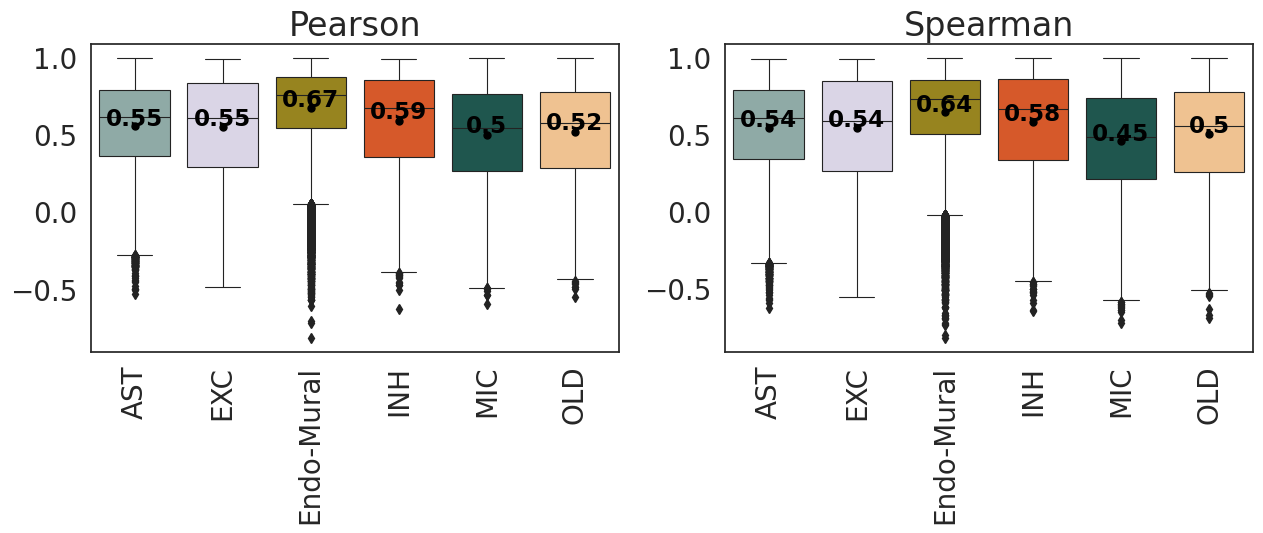

/tmp/ipykernel_1576951/504684301.py:267: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels(ax.get_yticklabels(),
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
/tmp/ipykernel_1576951/504684301.py:267: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels(ax.get_yticklabels(),
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


['Cellformer']
AST
EXC
Endo-Mural
INH
MIC
OLD
AST
EXC
Endo-Mural
INH
MIC
OLD


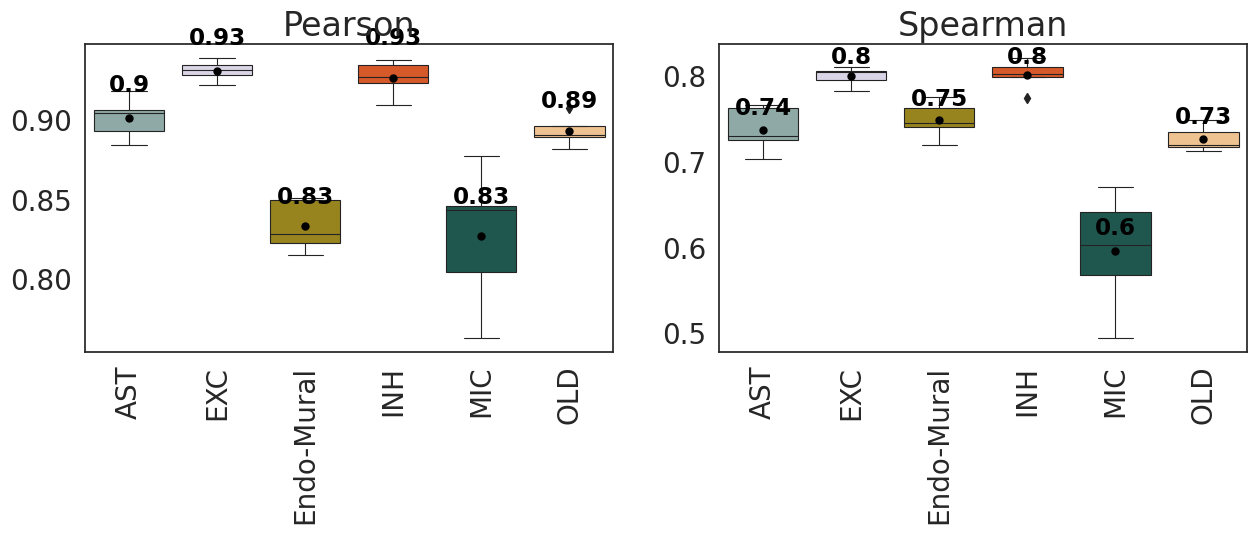

/tmp/ipykernel_1576951/504684301.py:118: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels(ax.get_yticklabels(),
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
/tmp/ipykernel_1576951/504684301.py:118: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels(ax.get_yticklabels(),
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


['Cellformer']
AST
EXC
Endo-Mural
INH
MIC
OLD
AST
EXC
Endo-Mural
INH
MIC
OLD


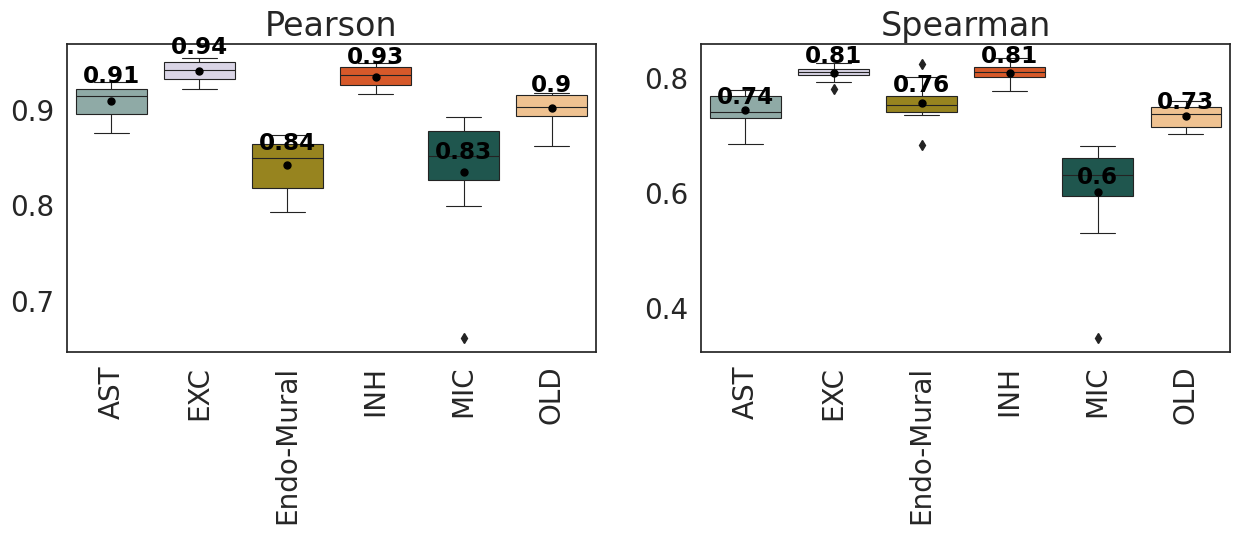

In [240]:
model = "/remote/home/eloiseb/experiments/deconv_rna/mice_noKA25_wt_kfold/"
met = model + "metrics_all_genes.csv"
df_metrics = pd.read_csv(met)
df_metrics= df_metrics.replace({"ENDO-Mural":"Endo-Mural"})
df_metrics["method"] = "Cellformer"
metrics=[ "pearson", "spearman"]
plot_model_genes(df_metrics,metrics, savepath, palette=PALETTE)

met = model + "metrics_all_it.csv"
df_metrics = pd.read_csv(met)
df_metrics= df_metrics.replace({"ENDO-Mural":"Endo-Mural"})
df_metrics["method"] = "Cellformer"
metrics=[ "pearson", "spearman"]
plot_model_it(df_metrics,metrics, savepath, palette=PALETTE)

met = model + "metrics_all_sub.csv"
df_metrics = pd.read_csv(met)
df_metrics= df_metrics.replace({"ENDO-Mural":"Endo-Mural"})
df_metrics["method"] = "Cellformer"
metrics=[ "pearson", "spearman"]
plot_model_sub(df_metrics,metrics, savepath, palette=PALETTE)




In [241]:
df_metrics[df_metrics.metrics =="pearson"].groupby(["celltype","method","fold"]).res.mean().mean()

0.8925386594797354

In [242]:
df_metrics[df_metrics.metrics =="spearman"].groupby(["celltype","method","fold"]).res.mean().mean()

0.7405260276518901

In [243]:
df_metrics[df_metrics.metrics =="spearman"].groupby(["fold"]).res.mean()

fold
fold_0    0.765345
fold_1    0.717674
fold_2    0.735379
fold_3    0.765149
fold_4    0.719043
Name: res, dtype: float64

mse
pearson
spearman


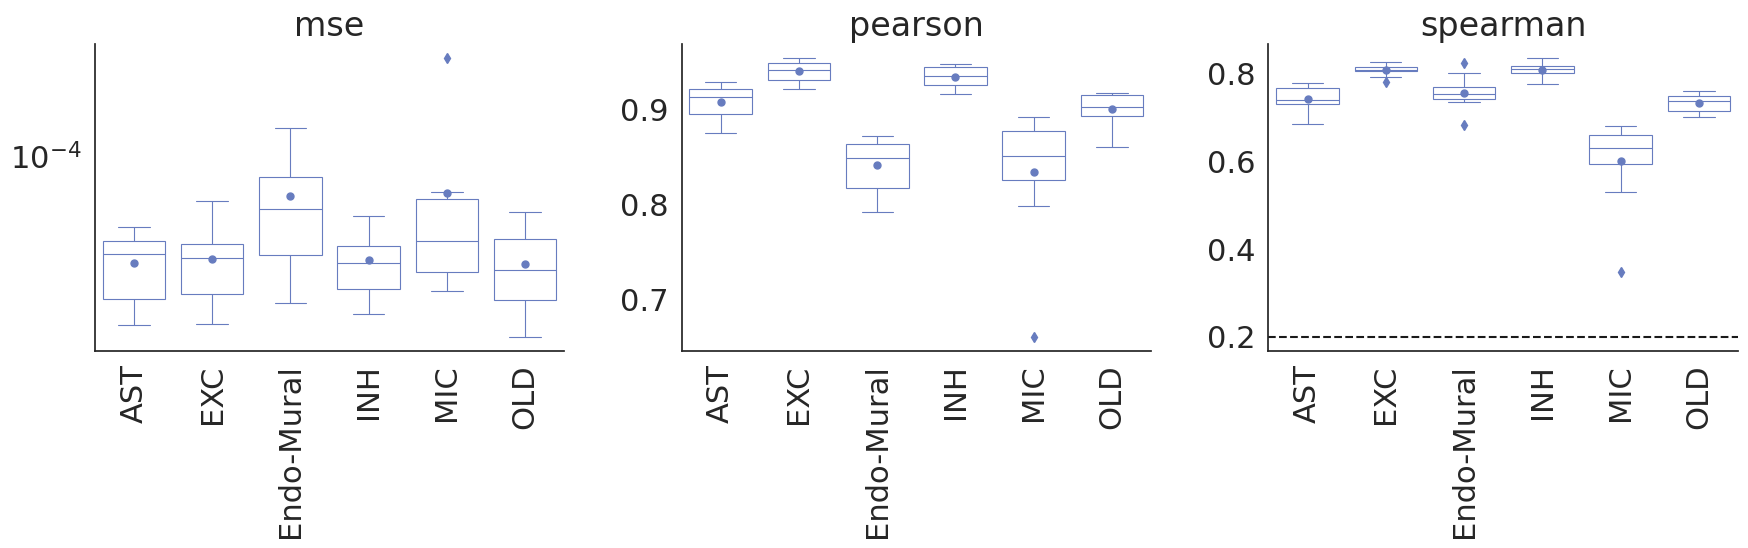

In [244]:

savename = "tmp"
metrics=["mse", "pearson", "spearman"]
plot_per_celltype(df_metrics,
                  "Cellformer",
                     savepath+"results_deconv_Cellformer" ,
                    metrics,
                    )

In [245]:
met = model + "metrics_all_genes.csv"

df_metrics = pd.read_csv(met)
print(df_metrics.genes.nunique())
mat = df_metrics[df_metrics.metrics == "spearman"].pivot(index=["celltype", "fold"], columns=["genes"], values="res").fillna(0).reset_index().groupby("celltype")[df_metrics.genes.unique().tolist()].mean()
mat[mat<=0.3] = 0
mask = mat.values
mask[mask>0] = 1
# mask[:,:]=1
mask.shape
np.count_nonzero(mat,axis=1)

19299


array([11120, 12840, 12560, 12676,  8369, 10696])

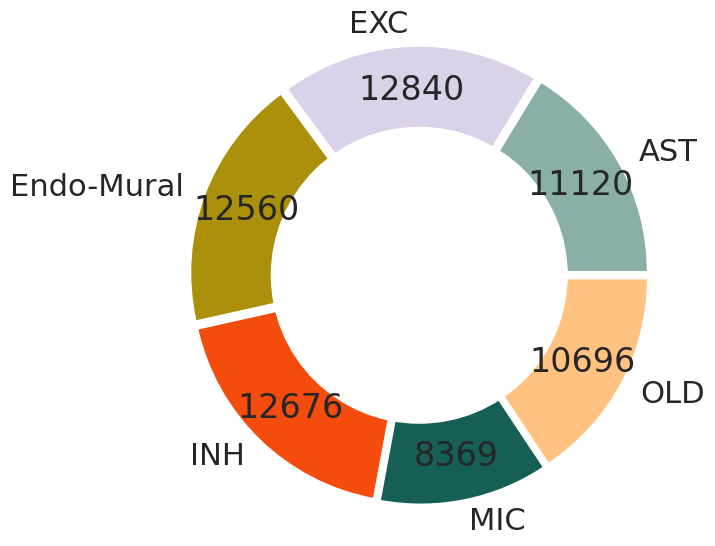

In [166]:
import matplotlib.pyplot as plt
 
# Setting labels for items in Chart
# celltypes = ["AST", "CA1", "CA2-3", "Cortical", "DG", "Endo-Mural","INH", "MIC", "OLD"]
celltypes = ["AST", "EXC", "Endo-Mural","INH", "MIC", "OLD"]


# Setting size in Chart based on 
# given values
values = np.count_nonzero(mat,axis=1)
 
# colors
colors = [PALETTE[it] for it in celltypes]
# explosion
explode = [0.05 for it in celltypes]
total = np.sum(values)
# Pie Chart
plt.pie(values, colors=colors, labels=celltypes,
        # autopct='%1.1f%%',
        autopct=lambda p: '{:.0f}'.format(p*total/100),
        pctdistance=0.8,
        normalize=True,
        radius=1.5,
        explode=explode)
 
# draw circle
centre_circle = plt.Circle((0, 0), 1, fc='white')
fig = plt.gcf()
 
# Adding Circle in Pie chart
fig.gca().add_artist(centre_circle)
 
# Adding Title of chart
# plt.title('Employee Salary Details')
plt.savefig(savename + "pie_predictable_genes.svg",
                bbox_inches="tight")
# Displaying Chart
plt.show()

In [167]:
np.savez_compressed(model + "cv_mask_02.npz", mat=mask)

In [168]:
mixtures = pd.read_csv("/remote/home/eloiseb/data/rna/mice_snrna/bulk_nuclei_refinedtp.csv")
genes = mixtures.drop("Sample_num", axis=1).columns.tolist()
mixtures

,Sample_num,XKR4,GM1992,MRPL15,LYPLA1,TCEA1,RGS20,GM16041,ATP6V1H,OPRK1,...,GM15884,DEFB39,GM12061,GM12356,VMN1R206,2310005E17RIK,1600019K03RIK,NXF3,CYP2C65,GM10197
0,KA25_ko2,2523,0,1306,480,1562,1003,0,7247,112,...,1,0,0,2,2,0,0,5,0,1
1,KA25_ko4,2006,0,1363,607,1655,1085,0,7543,122,...,1,0,0,7,0,0,0,3,0,5
2,KA25_wt3,2653,0,1255,432,1657,898,0,7227,298,...,0,0,5,6,6,0,0,1,3,9
3,KA25_wt4,4065,0,1516,744,2049,1118,0,9149,128,...,2,0,1,2,3,0,0,4,0,1
4,KA3_ko1,3084,0,1150,402,1338,579,0,6325,145,...,4,0,0,2,0,0,0,6,0,0
5,KA3_ko2,2345,1,1381,372,1668,686,0,8657,118,...,0,0,1,6,0,0,0,4,0,0
6,KA3_ko4,1950,0,1278,388,1622,864,0,7963,81,...,1,0,0,4,0,0,0,3,0,3
7,KA3_wt1,2280,0,1178,318,1220,763,0,6623,90,...,3,0,4,3,4,0,0,0,0,0
8,KA3_wt2,1305,2,1232,374,1291,687,0,6499,79,...,1,0,0,1,0,0,0,1,1,2
9,KA3_wt3,3647,0,1445,507,1736,836,0,8884,165,...,0,0,1,10,0,0,0,4,0,1


In [169]:
model="/remote/home/eloiseb/experiments/deconv_rna/mice_noKA25_wt_all/"

# Deconvoluted bulk tissue

In [171]:
both_exp = [ 'KA3_wt1', 'KA3_wt2', 'KA3_wt3', 'Veh_wt1',
            # 'KA25_wt1',
       # 'KA25_wt2', 'KA25_wt3', 'KA25_wt4', 
       'Veh_wt2', 'Veh_wt3', "Veh_wt4",'KA3_wt1', 'KA3_wt2', 'KA3_wt3', 'KA3_wt4' ]

In [172]:
# celltypes = ["AST", "CA1", "CA2-3", "Cortical", "DG", "Endo-Mural","INH", "MIC", "OLD"]
celltypes = ["AST", "EXC", "Endo-Mural","INH", "MIC", "OLD"]
fold = 0
model_f = model + "/exp_kfold_%s/test/"%str(fold)
deconv_ = model_f + "bulk_sample_decon_bulk_tissues_refinedtp/bulk_sample_decon/predictions_pseudobulk_Test_no_filt.npz"
ll = np.load(deconv_)["mat"]
ll.shape
deconv_ = model_f + "bulk_sample_decon_bulk_tissues_refinedtp/bulk_sample_decon/labels_Test.npz"
ff = np.load(deconv_)["mat"]
ll[ll<0] = 0
ll.shape
ll = ll*mask[np.newaxis, :, :]

df_tissue = pd.DataFrame(columns=["Sample_num", "celltypes"]+ genes)
for i,it in enumerate(ff):
    for j,ct in enumerate(celltypes):
        df_tissue.loc[len(df_tissue), :] = [it, ct] + ll[i,j, :].tolist()
#
df_tissue.Sample_num = df_tissue.Sample_num.str.replace("12hr_","")


In [173]:
df_tissue = df_tissue[df_tissue.Sample_num.isin(both_exp)]
df_tissue.Sample_num.unique()

array(['KA3_wt1', 'KA3_wt2', 'KA3_wt3', 'KA3_wt4', 'Veh_wt1', 'Veh_wt2',
       'Veh_wt3', 'Veh_wt4'], dtype=object)

In [174]:
df_tissue["Group"] = df_tissue["Sample_num"].str.split("_", expand=True)[0]

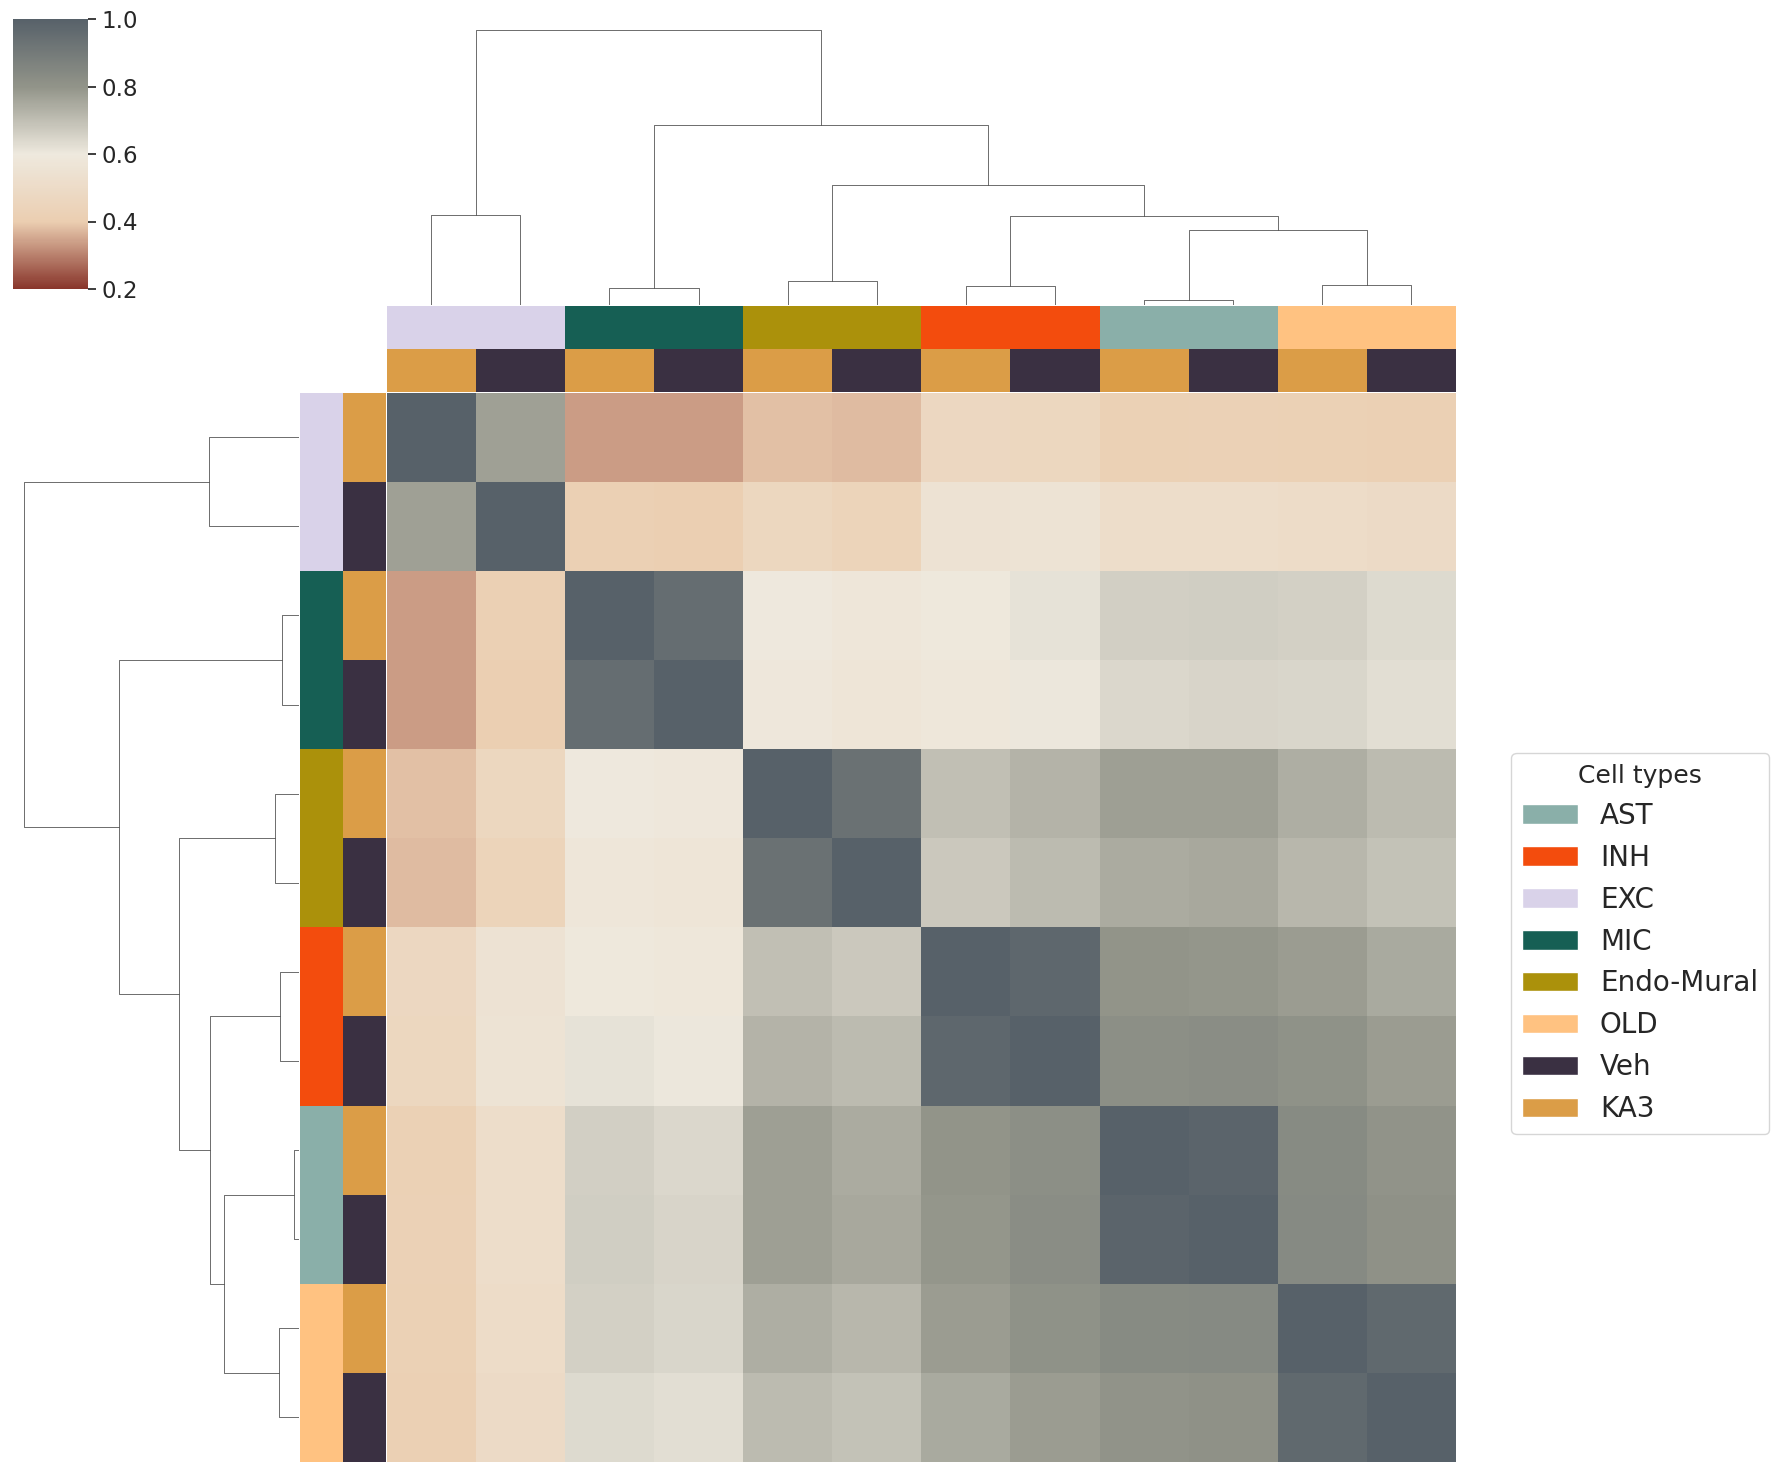

In [184]:
df_tissue.Sample_num.unique()
# df_veh = df_tissue[df_tissue.Sample_num.str.contains("Veh_wt")].sort_values("celltypes")
# mat = df_tissue.sort_values(["celltypes", "Sample_num"]).set_index(["celltypes","Sample_num" ]).astype("float").T.corr("spearman")


mat
mat = df_tissue.sort_values(["celltypes", "Group","Sample_num"]).groupby(["celltypes", "Group"])[genes].mean().astype("float").T.corr("spearman")
mat.columns = ['_'.join(map(str, x)) for x in mat.columns]
mat.index = ['_'.join(map(str, x)) for x in mat.index]


method = "Cellformer"
metrics=["spearman","pearson", "mse"]
end_color = '#A02c5a'
middle_color = '#FFFFFF'
start_color ="#CACACA"# "#27C196"
# palette = ["#CDC392","#F1F1E6","#F5F8FF","#9EB7E5","#648DE5","#304C89"]#"#A9A179",
# # palette = ["#630012",end_color,middle_color,start_color]
# import matplotlib.colors as mcolors
# from matplotlib.colors import ListedColormap, LinearSegmentedColormap

# cmap = mcolors.LinearSegmentedColormap.from_list('my_colormap', palette)
# cmap="Greys"
# sunflow_ =["#f5ab29","#db9925","#8a2f63","#7f2056","#52203d"]
# midnight_ =["#ddd3be","#ededed","#a2a1bb","#6e6d9b","#4b4a71"]
# cmap = mcolors.LinearSegmentedColormap.from_list('my_colormap', midnight_)

palette = ["#CDC392","#F1F1E6","#F5F8FF","#9EB7E5","#648DE5","#304C89"]#"#A9A179",
# palette = ["#630012",end_color,middle_color,start_color]
import matplotlib.colors as mcolors
from matplotlib.colors import ListedColormap, LinearSegmentedColormap
colors =["#88352b","#ebceb1","#eee9de","#929489","#576169"]
colors =["#88352b","#ebceb1","#eee9de","#929489","#576169"]
cmap = mcolors.LinearSegmentedColormap.from_list('my_colormap', colors)

pal = PALETTE #{"EXC":"#562c2c", "CA3": "#853140", "CA1":"#FF6E8F", "DG":"#FFBDC8", "INH":"#BFA5A7","ENDO":"#f5dfbb","OLD":"#008A63","OPC":"#27C196", "AST":"#AA4465", "Mural":"#F49A74","MIC":"#6C736A"}

# palette_exp = {"Tissue":"#02B38F", "Nuclei":"#661B00", "snRNA":"#1F3D4C"}
palette_mics = {"wt1":"#434656", "wt2":"#A7AABC", "wt3":"#614B0A", "wt4":"#977B3B"}
palette_mics = {"Veh":"#3A3042", "KA3":"#DB9D47"}#, "KA25":"#587486"}#, "wt3":"#614B0A", "wt4":"#977B3B"}
palette = PALETTE #{"CA1":"#853140","DG":"#FFCAFF", "CA3":"#BC5D81", "Cortical":"#EC90CD", "INH":"#897173", "AST":"#C1FCF6","Oligo":"#00C9BC","Microglia":"#49817B","Endo":"#686B65"}
# col_colors_cell =mat.reset_index()["index"].str.split("_", expand=True)[2].map(palette)
# col_colors_exp =mat.reset_index()["index"].str.split("_", expand=True)[1].map(palette_exp)

row_col = pd.DataFrame(mat.columns.tolist(), columns=["color"])["color"].str.split("_", expand=True)[0].map(palette)
row_colors_exp =pd.DataFrame(mat.columns.tolist(), columns=["color"])["color"].str.split("_", expand=True)[1].map(palette_mics)

# ytickl = mat.reset_index()["index_"].str.split("_", expand=True)[0].values
# g = sns.clustermap(mat, col_cluster=False, row_cluster=False, figsize=(15,15), yticklabels=True, xticklabels=True, cmap=cmap, 
#                    row_colors=[col_colors_exp,col_colors_cell], col_colors=[row_colors_exp,row_col], vmin=-1., vmax=1)#,annot=True)
sns.set(font_scale=1.5, style="white")

g = sns.clustermap(mat, figsize=(15,15), yticklabels=False, xticklabels=False, cmap=cmap,  vmax=1, vmin=0.2, 
                   row_colors=[row_col,row_colors_exp], 
                   col_colors=[row_col, row_colors_exp],
                   col_cluster=True, 
                   row_cluster=True
                  )

palette.update(palette_mics)
handles = [Patch(facecolor=palette[name]) for name in palette]
# handles += [Patch(facecolor=palette_mics[name]) for name in palette_mics]
plt.legend(handles, palette, title='Cell types', fontsize=20,
           bbox_to_anchor=(1.2, 0.5), bbox_transform=plt.gcf().transFigure, loc='upper right')
ax = g.ax_heatmap

plt.savefig(os.path.join(savepath, "heatmap_autocorrelation_deconvolution_bulk.svg"))

# Deconvoluted nuclei

In [176]:
deconv_ = model_f + "/bulk_sample_decon_bulk_nuclei_refinedtp/bulk_sample_decon/predictions_pseudobulk_Test_no_filt.npz"
ll = np.load(deconv_)["mat"]
ll.shape
deconv_ = model_f + "/bulk_sample_decon_bulk_nuclei_refinedtp/bulk_sample_decon/labels_Test.npz"
ff = np.load(deconv_)["mat"]
print(ll.shape)
print(len(genes))
ll[ll<0] = 0
ll = ll*mask[np.newaxis, :, :]

df_nuclei = pd.DataFrame(columns=["Sample_num", "celltypes"]+ genes)
for i,it in enumerate(ff):
    for j,ct in enumerate(celltypes):
        df_nuclei.loc[len(df_nuclei), :] = [it, ct] + ll[i,j, :].tolist()
print(ff)
df_nuclei.Sample_num = df_nuclei.Sample_num.str.replace("12hr_","")
df_nuclei = df_nuclei[df_nuclei.Sample_num.isin(both_exp)]
df_nuclei.Sample_num.unique()

(16, 6, 19299)
19299
['KA25_ko2' 'KA25_ko4' 'KA25_wt3' 'KA25_wt4' 'KA3_ko1' 'KA3_ko2' 'KA3_ko4'
 'KA3_wt1' 'KA3_wt2' 'KA3_wt3' 'Veh_ko2' 'Veh_ko3' 'Veh_ko4' 'Veh_wt1'
 'Veh_wt2' 'Veh_wt3']


array(['KA3_wt1', 'KA3_wt2', 'KA3_wt3', 'Veh_wt1', 'Veh_wt2', 'Veh_wt3'],
      dtype=object)

In [177]:
df_nuclei["Group"] = df_nuclei["Sample_num"].str.split("_", expand=True)[0]

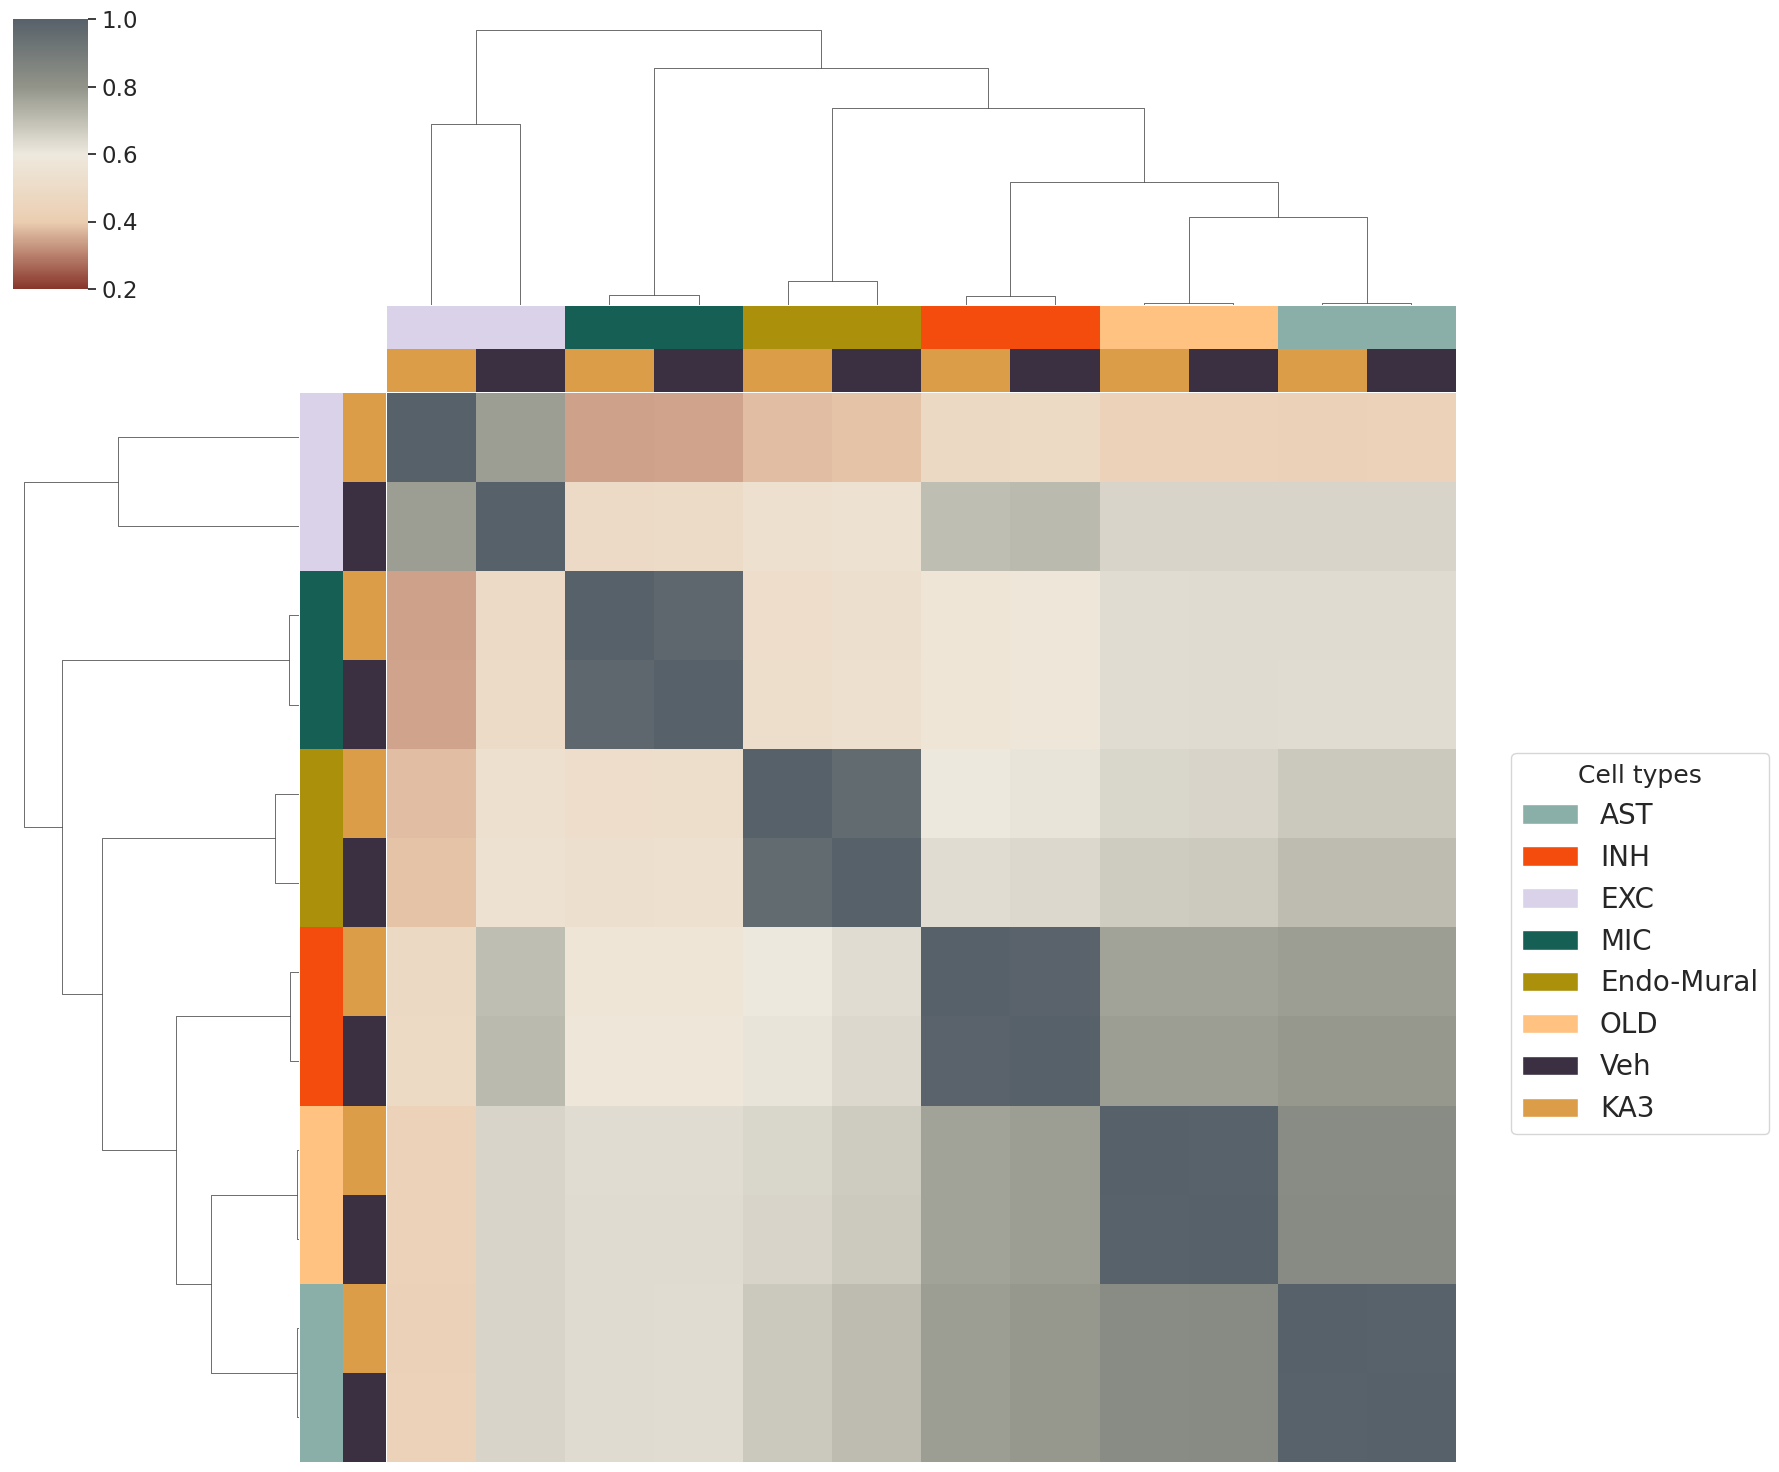

In [185]:
# df_veh_nu = df_nuclei[df_nuclei.Sample_num.str.contains("Veh_wt")].sort_values("celltypes")
# mat = df_nuclei.sort_values(["celltypes", "Sample_num"]).set_index(["celltypes", "Sample_num"]).astype("float").T.corr("spearman")
# mat


# mat
mat = df_nuclei.sort_values(["celltypes", "Sample_num"]).groupby(["celltypes", "Group"])[genes].mean().astype("float").T.corr("spearman")
mat.columns = ['_'.join(map(str, x)) for x in mat.columns]
mat.index = ['_'.join(map(str, x)) for x in mat.index]

method = "Cellformer"
metrics=["spearman","pearson", "mse"]
start_color = '#FF6B35'
middle_color = '#FFFFFF'
end_color = "#004E89"
import matplotlib.colors as mcolors
from matplotlib.colors import ListedColormap, LinearSegmentedColormap

row_col = pd.DataFrame(mat.columns.tolist(), columns=["color"])["color"].str.split("_", expand=True)[0].map(palette)
row_colors_exp =pd.DataFrame(mat.columns.tolist(), columns=["color"])["color"].str.split("_", expand=True)[1].map(palette_mics)

# ytickl = mat.reset_index()["index_"].str.split("_", expand=True)[0].values
# g = sns.clustermap(mat, col_cluster=False, row_cluster=False, figsize=(15,15), yticklabels=True, xticklabels=True, cmap=cmap, 
#                    row_colors=[col_colors_exp,col_colors_cell], col_colors=[row_colors_exp,row_col], vmin=-1., vmax=1)#,annot=True)


g = sns.clustermap(mat, figsize=(15,15), yticklabels=False, xticklabels=False, cmap=cmap,  vmax=1, vmin=0.2, 
                   row_colors=[row_col,row_colors_exp], 
                   col_colors=[row_col,row_colors_exp],
                   col_cluster=True, row_cluster=True)

handles = [Patch(facecolor=palette[name]) for name in palette]
# handles += [Patch(facecolor=palette_mics[name]) for name in palette_mics]
plt.legend(handles, palette, title='Cell types', fontsize=20,
           bbox_to_anchor=(1.2, 0.5), bbox_transform=plt.gcf().transFigure, loc='upper right')
ax = g.ax_heatmap

plt.savefig(os.path.join(savepath, "heatmap_autocorrelation_deconvolution_nuclei.svg"))

In [179]:
# COrrelation matrix

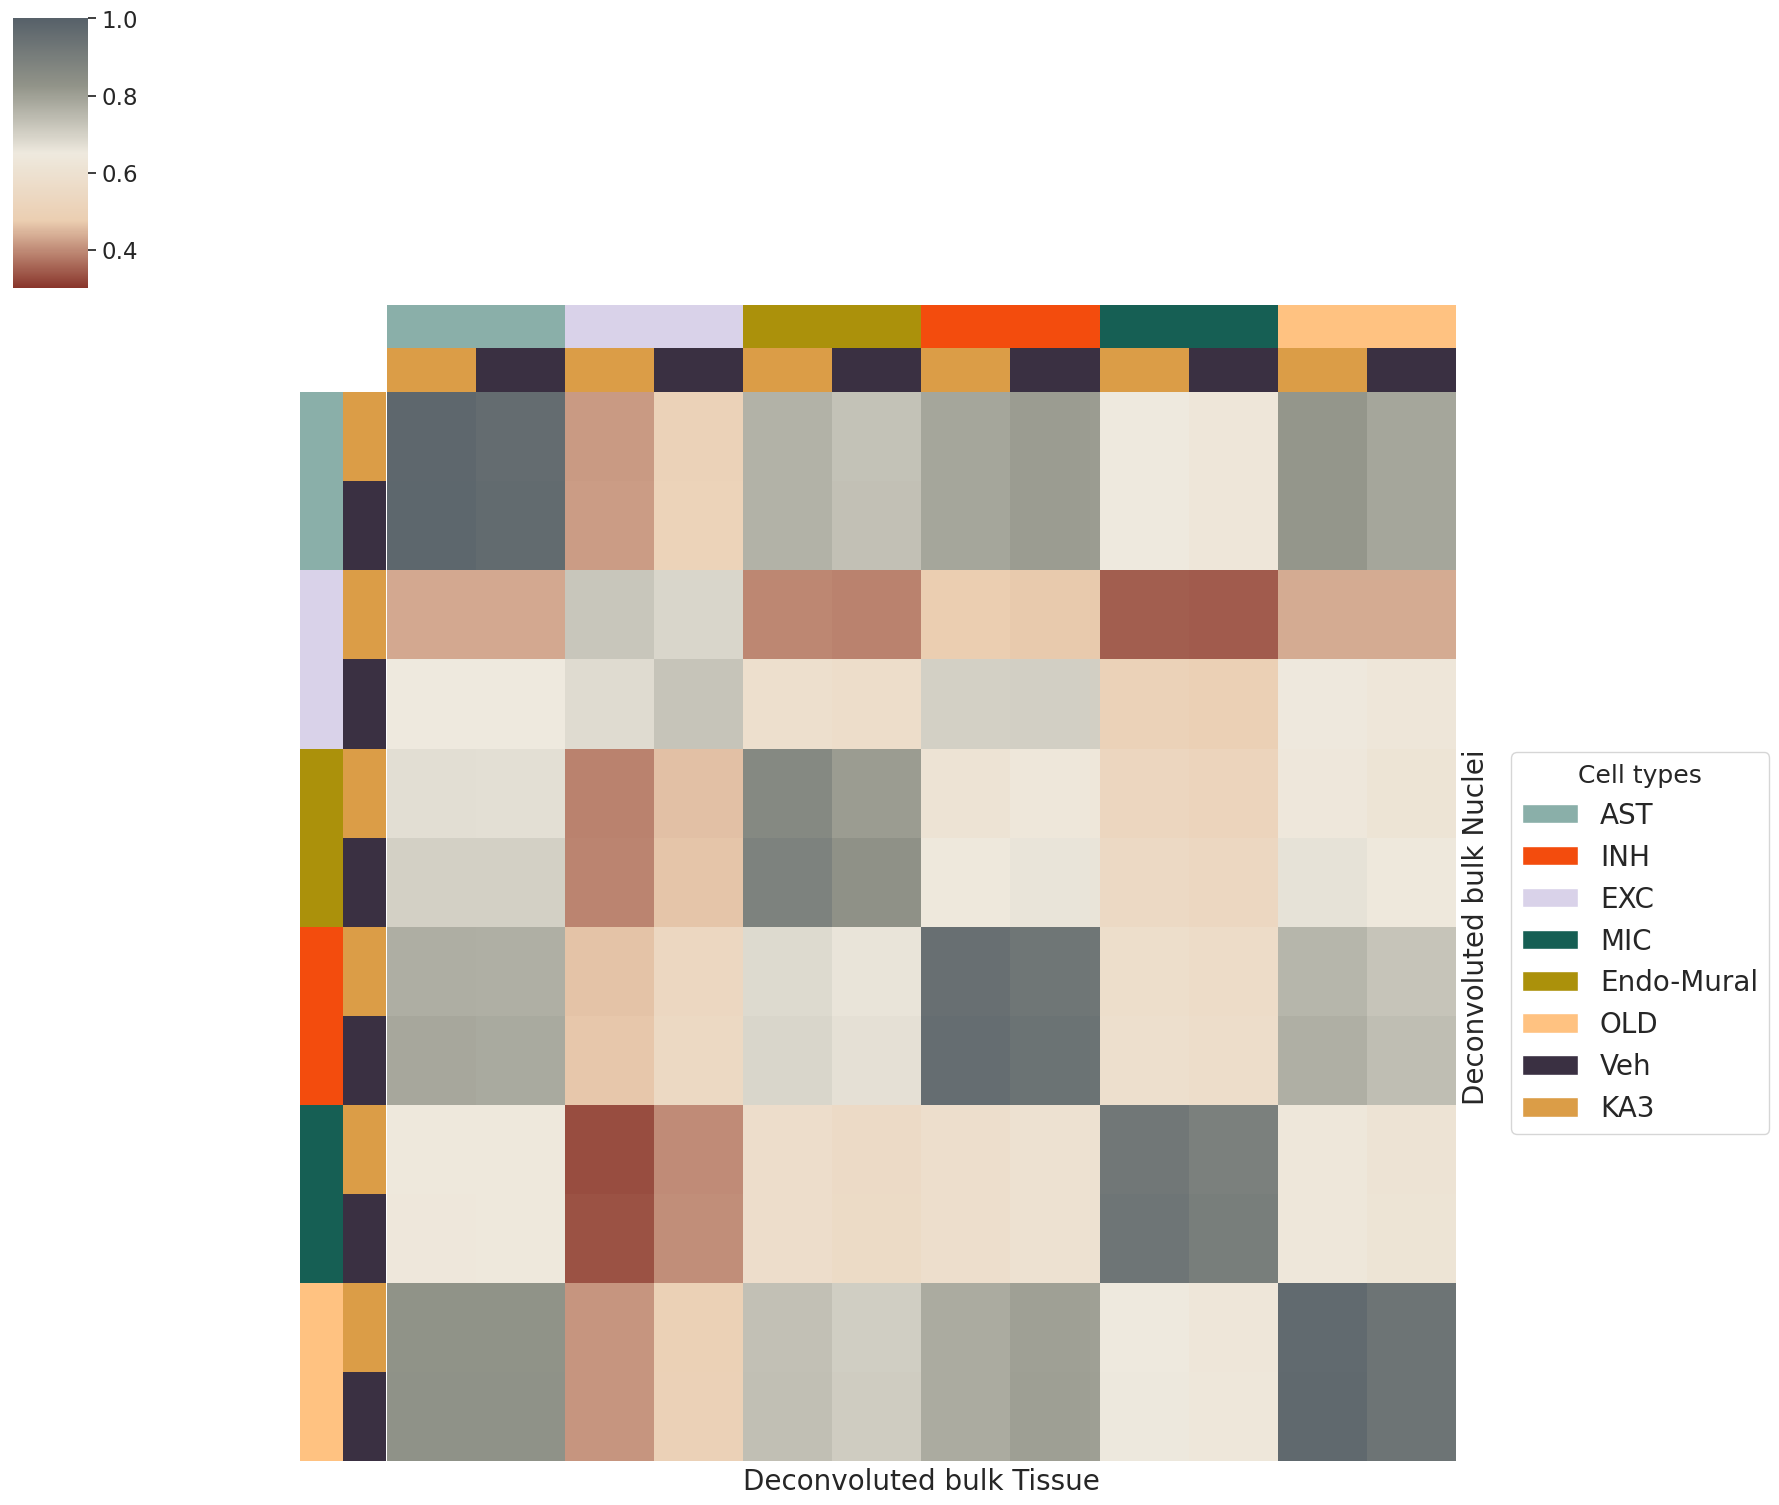

In [186]:
df_tissue["method"] = "Tissue"
df_nuclei["method"] = "Nuclei"

# df_veh = df_veh[df_veh.Sample_num.isin(df_veh_nu.Sample_num.unique())]
df_concat = pd.concat([df_tissue,df_nuclei])
df_concat
# mat = df_concat.sort_values(["celltypes", "Sample_num"]).set_index(["celltypes","Sample_num",  "method"]).astype("float").T.corr("spearman").reset_index()
# mat = mat[mat.method=="Tissue"].sort_values("celltypes").set_index([ "celltypes","Sample_num", "method"]).T.reset_index()

# mat = mat[mat.method=="Nuclei"].sort_values("celltypes").set_index(["celltypes", "Sample_num", "method"]).sort_values(["celltypes"])



mat = df_concat.sort_values(["celltypes"]).groupby(["celltypes", "Group","method"])[genes].mean().astype("float").T.corr("spearman").reset_index()
mat = mat[mat.method=="Tissue"].sort_values("celltypes").set_index([ "celltypes","Group", "method"]).T.reset_index()

mat = mat[mat.method=="Nuclei"].sort_values("celltypes").set_index(["celltypes","Group", "method"]).sort_values(["celltypes"])
mat.columns = ['_'.join(map(str, x)) for x in mat.columns]
mat.index = ['_'.join(map(str, x)) for x in mat.index]

col_col = pd.DataFrame(mat.columns.tolist(), columns=["color"])["color"].str.split("_", expand=True)[0].map(palette)
col_colors_exp =pd.DataFrame(mat.columns.tolist(), columns=["color"])["color"].str.split("_", expand=True)[1].map(palette_mics)
row_col = pd.DataFrame(mat.index.tolist(), columns=["color"])["color"].str.split("_", expand=True)[0].map(palette)
row_colors_exp =pd.DataFrame(mat.index.tolist(), columns=["color"])["color"].str.split("_", expand=True)[1].map(palette_mics)

g = sns.clustermap(mat, figsize=(15,15), yticklabels=False, xticklabels=False, cmap=cmap,  vmax=1, vmin=0.3,
                   row_colors=[row_col,row_colors_exp],
                   col_colors=[col_col,col_colors_exp], 
                   # row_cluster=True, col_cluster=True)
                    row_cluster=False, col_cluster=False)
handles = [Patch(facecolor=palette[name]) for name in palette]
# handles += [Patch(facecolor=palette_mics[name]) for name in palette_mics]
plt.legend(handles, palette, title='Cell types', fontsize=20,
           bbox_to_anchor=(1.2, 0.5), bbox_transform=plt.gcf().transFigure, loc='upper right')
ax = g.ax_heatmap
ax.set_ylabel("Deconvoluted bulk Nuclei",fontsize=20)
ax.set_xlabel("Deconvoluted bulk Tissue",fontsize=20)
plt.savefig(os.path.join(savepath, "heatmap_correlation_deconvolution_bulk_vs_nuclei.svg"))

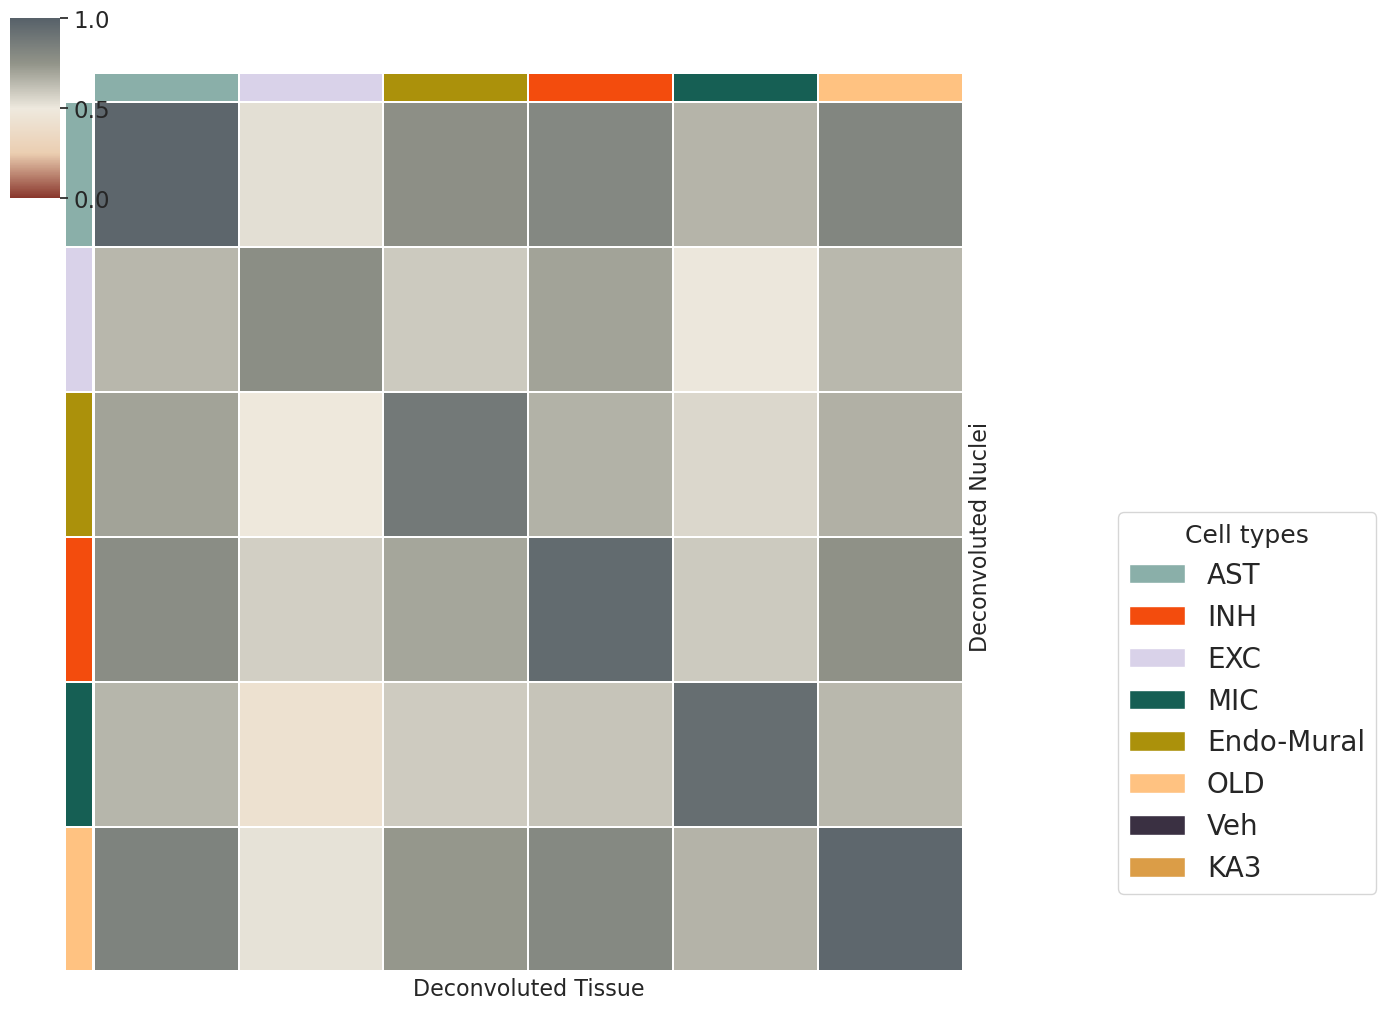

In [187]:
df_tissue["method"] = "Tissue"
df_nuclei["method"] = "Nuclei"

# df_veh = df_veh[df_veh.Sample_num.isin(df_tissue.Sample_num.unique())]
df_concat = pd.concat([df_tissue,df_nuclei])
df_concat 
# mat = df_concat.sort_values("celltypes").set_index(["celltypes","Sample_num",  "method"]).astype("float").T.corr("spearman").reset_index()
# mat = mat[mat.method=="Tissue"].sort_values("celltypes").set_index([ "celltypes","Sample_num", "method"]).T.reset_index()
#mat = mat[mat.method=="Nuclei"].set_index(["celltypes", "Sample_num", "method"]).sort_values("celltypes")

mat = df_concat.sort_values("celltypes").groupby(["celltypes", "method"])[genes].mean().astype("float").T.corr("spearman").reset_index()
mat = mat[mat.method=="Tissue"].sort_values("celltypes").set_index([ "celltypes", "method"]).T.reset_index()

mat = mat[mat.method=="Nuclei"].set_index(["celltypes",  "method"]).sort_values("celltypes")

mat.columns = ['_'.join(map(str, x)) for x in mat.columns]
mat.index = ['_'.join(map(str, x)) for x in mat.index]

col_col = pd.DataFrame(mat.columns.tolist(), columns=["color"])["color"].str.split("_", expand=True)[0].map(palette)
# col_colors_exp =pd.DataFrame(mat.columns.tolist(), columns=["color"])["color"].str.split("_", expand=True)[2].map(palette_mics)
row_col = pd.DataFrame(mat.index.tolist(), columns=["color"])["color"].str.split("_", expand=True)[0].map(palette)
# row_colors_exp =pd.DataFrame(mat.index.tolist(), columns=["color"])["color"].str.split("_", expand=True)[2].map(palette_mics)

g = sns.clustermap(mat, figsize=(10,10), yticklabels=False, xticklabels=False, cmap=cmap,  vmax=1, vmin=0.,
                   row_colors=[row_col],#,row_colors_exp],
                   col_colors=[col_col],#col_colors_exp], 
                   dendrogram_ratio=[0.05, 0.05],
                   linewidth=0.2,
                   row_cluster=False, 
                   col_cluster=False)

handles = [Patch(facecolor=palette[name]) for name in palette]
# handles += [Patch(facecolor=palette_mics[name]) for name in palette_mics]
plt.legend(handles, palette, title='Cell types', fontsize=20,
           bbox_to_anchor=(1.4, 0.5), bbox_transform=plt.gcf().transFigure, loc='upper right')
ax = g.ax_heatmap


ax = g.ax_heatmap
ax.set_ylabel("Deconvoluted Nuclei",fontsize=16)
ax.set_xlabel("Deconvoluted Tissue",fontsize=16)
plt.savefig(os.path.join(savepath, "heatmap_correlation_deconvolution_bulk_.svg"))

/home/eloiseb/miniconda3/envs/pytorch_env/lib/python3.10/site-packages/anndata/_core/anndata.py:117: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
/home/eloiseb/miniconda3/envs/pytorch_env/lib/python3.10/site-packages/anndata/_core/anndata.py:1830: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")


/home/eloiseb/miniconda3/envs/pytorch_env/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:1234: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = pd.Categorical(values.map(color_map))
/home/eloiseb/miniconda3/envs/pytorch_env/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


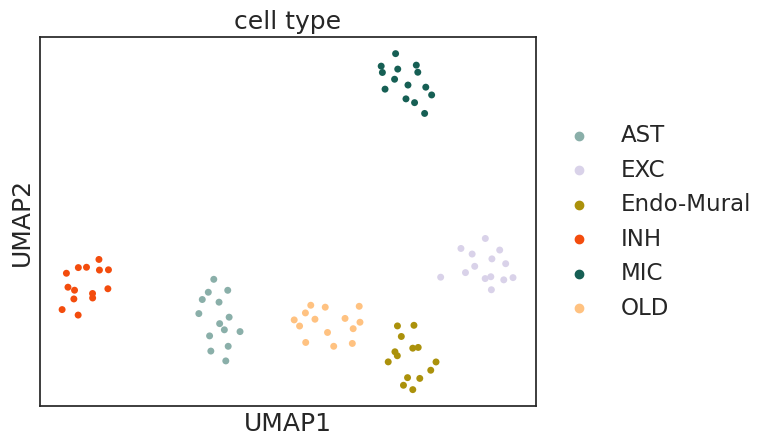

/home/eloiseb/miniconda3/envs/pytorch_env/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:1234: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = pd.Categorical(values.map(color_map))
/home/eloiseb/miniconda3/envs/pytorch_env/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/home/eloiseb/miniconda3/envs/pytorch_env/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:1234: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = 

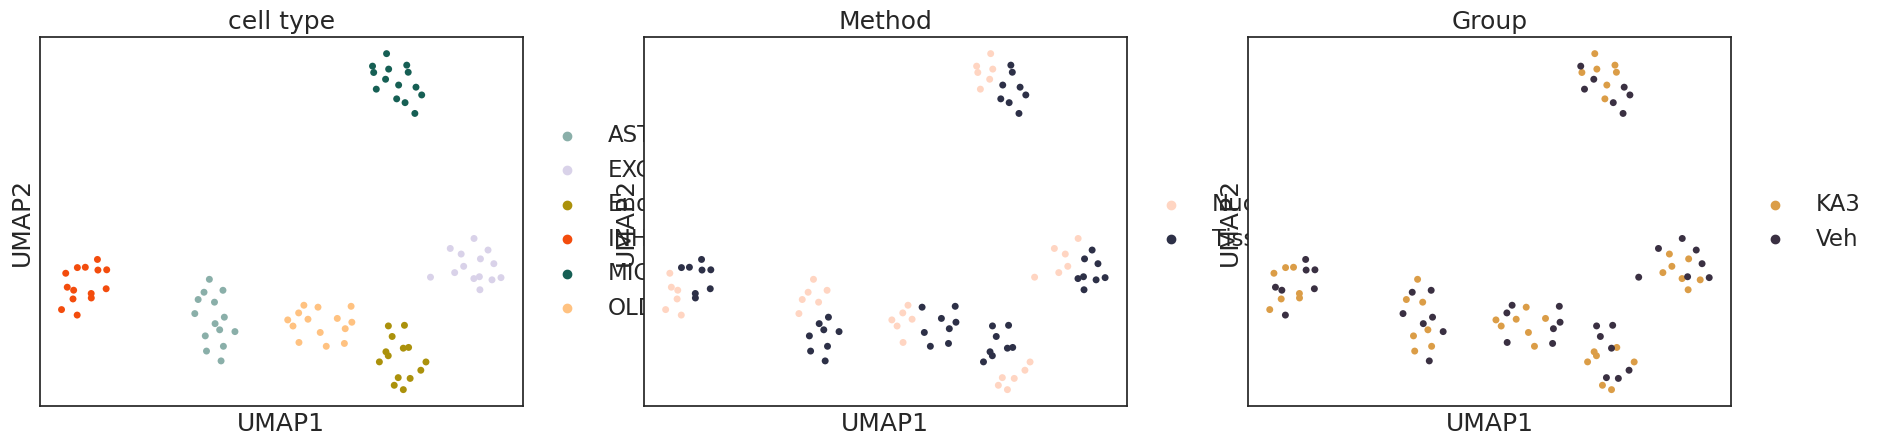

In [188]:
df_tissue["method"] = "Tissue"
df_nuclei["method"] = "Nuclei"

# df_veh = df_veh[df_veh.Sample_num.isin(df_tissue.Sample_num.unique())]
df_concat = pd.concat([df_tissue,df_nuclei])
df_concat 
adata = ad.AnnData(df_concat[genes])
adata.obs["cell type"] =   df_concat["celltypes"].values
adata.obs["Sample_num"] =   df_concat["Sample_num"].values
adata.obs["Diagnosis"] =   adata.obs["Sample_num"].str.split("_", expand=True)[1].values
adata.obs["Diagnosis"] = adata.obs["Diagnosis"].map({"D":"AD","ND":"CTRL"}).values
adata.obs["Method"] =   df_concat["method"].values
adata.obs["Group"] =   df_concat["Group"].values
sc.pp.log1p(adata)
sc.tl.pca(adata, svd_solver='arpack')
sc.pp.neighbors(adata, n_neighbors=20)
sc.tl.tsne(adata)
sc.tl.umap(adata)#, init_pos='paga')
sc.pl.umap(adata, color=["cell type"], s=100, palette=PALETTE,save="umap_hu_tissue_ct.svg")
palette_exp["AD"] = "#83869C"
palette_exp["CTRL"] = "#D1D1D1"
palette_exp.update(PALETTE)
sc.pl.umap(adata, color=["cell type","Method", "Group"],palette=palette_exp,s=100,save="umap_mu_w_tissue_other.svg")


# snRNA

In [189]:
User = "/home/eloiseb/stanford_drive/"
single_cell = ad.read_h5ad("/remote/home/eloiseb/data/rna/mice_snrna/WT_snRNA.h5ad")

single_cell
single_cell =single_cell[:,single_cell.var.gene_symbol.isin(genes)]

new_genes = single_cell.var.gene_symbol.tolist()

single_cell.obs["celltype"] =single_cell.obs["celltype"].replace({"Astro":"AST", "CA1/SUB":"CA1",
                                                                  "Inhib":"INH", "Micro":"MIC",
                                                                  "Oligo":"OLD", 
                                                                  'ENDO-Mural':"Endo-Mural"})
single_cell.obs["celltype"] =single_cell.obs["celltype"].replace({"Astro":"AST", "CA1/SUB":"EXC","CA1":"EXC",
                                                                  "CA2-3":"EXC","DG":"EXC","Cortical":"EXC",
                                                                  "Inhib":"INH", "Micro":"MIC",
                                                                  "Oligo":"OLD", 
                                                                  'ENDO-Mural':"Endo-Mural"})
print(single_cell.obs["celltype"].unique())
# single_cell.obs["Sample_num"] = single_cell.obs["Sample_num"].str.upper()
# df_nuclei["Sample_num"] = df_nuclei["Sample_num"].str.upper()
# df_tissue["Sample_num"] = df_tissue["Sample_num"].str.upper()

# single_cell.var.reset_index(inplace=True, drop=True)

/tmp/ipykernel_1576951/2939044671.py:9: FutureWarning: The behavior of Series.replace (and DataFrame.replace) with CategoricalDtype is deprecated. In a future version, replace will only be used for cases that preserve the categories. To change the categories, use ser.cat.rename_categories instead.
  single_cell.obs["celltype"] =single_cell.obs["celltype"].replace({"Astro":"AST", "CA1/SUB":"CA1",
/tmp/ipykernel_1576951/2939044671.py:9: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  single_cell.obs["celltype"] =single_cell.obs["celltype"].replace({"Astro":"AST", "CA1/SUB":"CA1",


['MIC', 'EXC', 'INH', 'OLD', 'AST', 'Endo-Mural']
Categories (6, object): ['AST', 'EXC', 'Endo-Mural', 'INH', 'MIC', 'OLD']


/tmp/ipykernel_1576951/2939044671.py:13: FutureWarning: The behavior of Series.replace (and DataFrame.replace) with CategoricalDtype is deprecated. In a future version, replace will only be used for cases that preserve the categories. To change the categories, use ser.cat.rename_categories instead.
  single_cell.obs["celltype"] =single_cell.obs["celltype"].replace({"Astro":"AST", "CA1/SUB":"EXC","CA1":"EXC",


In [308]:
single_cell.obs.

,orig_ident,nCount_RNA,nFeature_RNA,percent_mt,batch,condition,nCount_SCT,nFeature_SCT,integrated_snn_res_1,seurat_clusters,...,cell_types_Allcells_fine,celltype_stim_fine,cell_types_Allcells_coarse,celltype_stim_coarse,cell_types_Allcells_Eloise,celltype,mapping,Sample_num,mice,treatment
AAACCCACAGCTCGGT-1_1,Veh_WT1,557,450,0.359066,batch2,ctl,3865,1534,11,15,...,Micro_1,Micro_1_ctl,Micro,Micro_ctl,Micro,MIC,Micro,Veh_wt1,WT,Veh
AAACCCAGTCCATAGT-1_1,Veh_WT1,15667,4422,0.217017,batch2,ctl,6573,3289,20,24,...,CA3_2,CA3_2_ctl,CA3,CA3_ctl,CA3,EXC,CA2-3,Veh_wt1,WT,Veh
AAACCCAGTGGACCAA-1_1,Veh_WT1,5560,2341,0.233813,batch2,ctl,5677,2341,35,35,...,Inhib_Ndnf,Inhib_Ndnf_ctl,Inhib_Ndnf,Inhib_Ndnf_ctl,Inhib,INH,Inhib,Veh_wt1,WT,Veh
AAACGAACAAAGCGTG-1_1,Veh_WT1,1193,750,1.005868,batch2,ctl,4411,1400,2,3,...,Oligo_1,Oligo_1_ctl,Oligo_1,Oligo_1_ctl,Oligo,OLD,Oligo,Veh_wt1,WT,Veh
AAACGAACACCATATG-1_1,Veh_WT1,12803,3871,0.132781,batch2,ctl,6642,3252,23,29,...,L2_IT_ENTm,L2_IT_ENTm_ctl,L2_IT_ENTm,L2_IT_ENTm_ctl,Cortical,EXC,Cortical,Veh_wt1,WT,Veh
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
TTTGTTGGTAGATCGG-1_25,KA25_WT4,5216,2352,0.402607,batch2,KA25_12h,5491,2352,35,35,...,Inhib_Ndnf,Inhib_Ndnf_KA25_12h,Inhib_Ndnf,Inhib_Ndnf_KA25_12h,Inhib,INH,Inhib,KA25_wt4,WT,KA25
TTTGTTGGTGCCGGTT-1_25,KA25_WT4,2767,1653,1.301048,batch2,KA25_12h,4954,1740,9,11,...,Oligo_3,Oligo_3_KA25_12h,Oligo_3,Oligo_3_KA25_12h,Oligo,OLD,Oligo,KA25_wt4,WT,KA25
TTTGTTGGTTCACGAT-1_25,KA25_WT4,8648,2955,0.208141,batch2,KA25_12h,6575,2937,0,18,...,DG_4,DG_4_KA25_12h,DG,DG_KA25_12h,DG,EXC,DG,KA25_wt4,WT,KA25
TTTGTTGGTTCGATTG-1_25,KA25_WT4,4831,2226,1.262679,batch2,KA25_12h,5395,2226,0,18,...,DG_4,DG_4_KA25_12h,DG,DG_KA25_12h,DG,EXC,DG,KA25_wt4,WT,KA25


In [191]:
# combine = combine[~combine.Sample_num.str.contains("ko")]
single_cell = single_cell[~single_cell.obs.Sample_num.str.contains("6h|24h")]

single_cell.obs.Sample_num = single_cell.obs.Sample_num.str.replace("VEH", "Veh")
single_cell.obs.Sample_num = single_cell.obs.Sample_num.str.replace("WT", "wt")
single_cell.obs.Mice = single_cell.obs.Sample_num.str.split("_",expand=True)[0]

/home/eloiseb/miniconda3/envs/pytorch_env/lib/python3.10/site-packages/pandas/core/generic.py:6329: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  self[name] = value
/tmp/ipykernel_1576951/4010514827.py:6: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  single_cell.obs.Mice = single_cell.obs.Sample_num.str.split("_",expand=True)[0]


In [192]:
## for fair comparison removing non predictable genes per celltypes
all_ = []
for ii, it in enumerate(celltypes):
    tmp = single_cell[single_cell.obs.celltype ==it]
    tmp_m = mask[ii,:]
    tmp.X = np.multiply(tmp_m[np.newaxis,:],tmp.X)
    all_.append(tmp)


np.count_nonzero(tmp.X.sum(0))

snRNA = ad.concat(all_)
snRNA.var = single_cell.var

In [193]:
single_cell.obs["Sample_num"].unique()
celltypes

['AST', 'EXC', 'Endo-Mural', 'INH', 'MIC', 'OLD']

In [194]:
snRNA

AnnData object with n_obs × n_vars = 99482 × 19299
    obs: 'orig_ident', 'nCount_RNA', 'nFeature_RNA', 'percent_mt', 'batch', 'condition', 'nCount_SCT', 'nFeature_SCT', 'integrated_snn_res_1', 'seurat_clusters', 'SCT_snn_res_1', 'cell_types_Allcells_fine', 'celltype_stim_fine', 'cell_types_Allcells_coarse', 'celltype_stim_coarse', 'cell_types_Allcells_Eloise', 'celltype', 'mapping', 'Sample_num', 'mice', 'treatment'
    var: 'gene_symbol', 'n_cells'

In [195]:
import scanpy as sc
# Perform differential expression analysis
# sc.pp.log1p(adata_sc)
#adata_sc =single_cell
snRNA.var_names =snRNA.var["gene_symbol"]
sc.tl.rank_genes_groups(snRNA, groupby='celltype')#, method="wilcoxon")
#sc.tl.filter_rank_genes_groups(adata_sc, min_in_group_fraction=0.25)

FC = 0
Pval=0.05
# Retrieve the results
results = snRNA.uns['rank_genes_groups']
#results
total_gene_de = []
dico_cell_type = {}
for it in snRNA.obs.celltype.unique():
    de_genes = sc.get.rank_genes_groups_df(snRNA, group=it)
    de_genes = de_genes[(de_genes.pvals_adj<Pval)]#&(de_genes.logfoldchanges>FC)]
    print(len(de_genes))
    dico_cell_type[it] = de_genes["names"]
    total_gene_de += de_genes["names"].tolist()

15549
15770
13733
14269
15789
15904


/home/eloiseb/miniconda3/envs/pytorch_env/lib/python3.10/site-packages/scanpy/get/get.py:69: FutureWarning: The previous implementation of stack is deprecated and will be removed in a future version of pandas. See the What's New notes for pandas 2.1.0 for details. Specify future_stack=True to adopt the new implementation and silence this warning.
  d = d.stack(level=1).reset_index()
/home/eloiseb/miniconda3/envs/pytorch_env/lib/python3.10/site-packages/scanpy/get/get.py:69: FutureWarning: The previous implementation of stack is deprecated and will be removed in a future version of pandas. See the What's New notes for pandas 2.1.0 for details. Specify future_stack=True to adopt the new implementation and silence this warning.
  d = d.stack(level=1).reset_index()
/home/eloiseb/miniconda3/envs/pytorch_env/lib/python3.10/site-packages/scanpy/get/get.py:69: FutureWarning: The previous implementation of stack is deprecated and will be removed in a future version of pandas. See the What's New

In [196]:
# sc.pp.normalize_total(single_cell, target_sum=1e4)
sc.pp.log1p(snRNA)
# sc.pp.highly_variable_genes(single_cell, min_mean=0.0125, max_mean=3, min_disp=0.5)
# sc.pl.highly_variable_genes(single_cell)
# single_cell = single_cell[:, single_cell.var.highly_variable]

In [197]:
new_genes = single_cell.var.gene_symbol.tolist()
single_cell.var.reset_index(drop=True, inplace=True)
indexes = single_cell.var.index.astype(int).tolist()
# indexes
single_cell.obs["celltype"].unique()

['MIC', 'EXC', 'INH', 'OLD', 'AST', 'Endo-Mural']
Categories (6, object): ['AST', 'EXC', 'Endo-Mural', 'INH', 'MIC', 'OLD']

In [198]:
# Pseudo bulk from snRNA
gg =single_cell.to_df()
gg.columns = single_cell.var.gene_symbol.values
gg["Sample_num"] = single_cell.obs["Sample_num"].values#.str.upper()
gg["celltype"] = single_cell.obs["celltype"].values
gg.Sample_num.unique()
gg.shape


pseudo_ = gg.groupby(["Sample_num", "celltype"])[new_genes].sum()
pseudo_
pseudo_ =  pseudo_.reset_index()

samples = gg.Sample_num.unique().tolist()
mat = np.zeros((gg.Sample_num.nunique(), len(celltypes), len(new_genes)))
for i,it in enumerate(samples):
    for j,ct in enumerate(celltypes):
        mat[i,j,:] = pseudo_[(pseudo_.Sample_num ==it)&(pseudo_.celltype==ct)][new_genes].values

mat = mat*mask[:, indexes][np.newaxis, :, :]
mat.sum(0)

pseudo_new = pd.DataFrame(columns=["Sample_num", "celltype"] +new_genes)
for i,it in enumerate(samples):
    for j,ct in enumerate(celltypes):

        pseudo_new.loc[len(pseudo_new),:] = [it,ct] + mat[i,j,:].astype(float).tolist()
pseudo_ = pseudo_new

# pseudo_ =pseudo_[pseudo_["Sample_num"].isin(df_tissue.Sample_num.unique())]
pseudo_

/tmp/ipykernel_1576951/4207492110.py:10: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  pseudo_ = gg.groupby(["Sample_num", "celltype"])[new_genes].sum()


,Sample_num,celltype,XKR4,GM1992,MRPL15,LYPLA1,TCEA1,RGS20,GM16041,ATP6V1H,...,GM15884,DEFB39,GM12061,GM12356,VMN1R206,2310005E17RIK,1600019K03RIK,NXF3,CYP2C65,GM10197
0,Veh_wt1,AST,18.0,0.0,1.0,16.0,16.0,244.0,4.0,14.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,Veh_wt1,EXC,5485.0,592.0,84.0,157.0,335.0,162.0,0.0,574.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,Veh_wt1,Endo-Mural,0.0,0.0,4.0,10.0,15.0,0.0,0.0,10.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,Veh_wt1,INH,1446.0,161.0,14.0,19.0,48.0,21.0,0.0,76.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,Veh_wt1,MIC,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
97,KA25_wt4,EXC,52361.0,6481.0,1046.0,1373.0,3409.0,1602.0,0.0,4963.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
98,KA25_wt4,Endo-Mural,8.0,0.0,7.0,9.0,18.0,0.0,0.0,13.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
99,KA25_wt4,INH,14633.0,1832.0,133.0,209.0,514.0,540.0,0.0,679.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
100,KA25_wt4,MIC,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [199]:
# Marker genes comparison

In [200]:
# Marker gene deconvoluted
Pval=0.05
df_tissue
df_nn = df_nuclei[df_nuclei.Sample_num.isin(single_cell.obs.Sample_num)]
df_tt = df_tissue[df_tissue.Sample_num.isin(single_cell.obs.Sample_num)]

adata_tissue = ad.AnnData(df_tt[new_genes].astype(float))
adata_tissue.obs["celltype"] = df_tt["celltypes"].values
adata_tissue.obs["Sample_num"] = df_tt["Sample_num"].values
adata_nuclei = ad.AnnData(df_nn[new_genes].astype(float))
adata_nuclei.obs["celltype"] = df_nn["celltypes"].values
adata_nuclei.obs["Sample_num"] = df_nn["Sample_num"].values
adata_nuclei
adata_pseudo = ad.AnnData(pseudo_[new_genes].astype(float))
adata_pseudo.obs["celltype"] = pseudo_["celltype"].astype("category").values
adata_pseudo.obs["Sample_num"] = pseudo_["Sample_num"].values
adata_pseudo

# Perform differential expression analysis
sc.tl.rank_genes_groups(adata_tissue, groupby='celltype')#,method="wilcoxon")
#sc.tl.filter_rank_genes_groups(adata_tissue, min_in_group_fraction=0.25)

# Retrieve the results
results = adata_tissue.uns['rank_genes_groups']
#results
dico_tissue = {}
for it in adata_tissue.obs.celltype.unique():
    de_genes = sc.get.rank_genes_groups_df(adata_tissue, group=it)
    de_genes = de_genes[(de_genes.pvals_adj<Pval)]#&(de_genes.logfoldchanges>FC)]
    print(len(de_genes))
    dico_tissue[it] = de_genes["names"]
    
import scanpy as sc
# Perform differential expression analysis
sc.tl.rank_genes_groups(adata_nuclei, groupby='celltype')#, method="wilcoxon")
#sc.tl.filter_rank_genes_groups(adata_tissue, min_in_group_fraction=0.25)

# Retrieve the results
results = adata_nuclei.uns['rank_genes_groups']
#results
dico_nuclei = {}
for it in adata_nuclei.obs.celltype.unique():
    de_genes = sc.get.rank_genes_groups_df(adata_nuclei, group=it)
    de_genes = de_genes[(de_genes.pvals_adj<Pval)]#&(de_genes.logfoldchanges>FC)]
    print(len(de_genes))
    dico_nuclei[it] = de_genes["names"]
sc.tl.rank_genes_groups(adata_pseudo, groupby='celltype')#, method="wilcoxon")
#sc.tl.filter_rank_genes_groups(adata_tissue, min_in_group_fraction=0.25)

# Retrieve the results
results = adata_pseudo.uns['rank_genes_groups']
#results
dico_pseudo = {}
for it in adata_pseudo.obs.celltype.unique():
    de_genes = sc.get.rank_genes_groups_df(adata_pseudo, group=it)
    de_genes = de_genes[(de_genes.pvals_adj<Pval)]#&(de_genes.logfoldchanges>FC)]
    print(len(de_genes))
    dico_pseudo[it] = de_genes["names"].tolist()

/home/eloiseb/miniconda3/envs/pytorch_env/lib/python3.10/site-packages/anndata/_core/anndata.py:117: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
/home/eloiseb/miniconda3/envs/pytorch_env/lib/python3.10/site-packages/anndata/_core/anndata.py:117: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
/home/eloiseb/miniconda3/envs/pytorch_env/lib/python3.10/site-packages/anndata/_core/anndata.py:117: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
/home/eloiseb/miniconda3/envs/pytorch_env/lib/python3.10/site-packages/scanpy/tools/_rank_genes_groups.py:419: RuntimeWarning: overflow encountered in expm1
  foldchanges = (self.expm1_func(mean_group) + 1e-9) / (
/home/eloiseb/miniconda3/envs/pytorch_env/lib/python3.10/site-packages/scanpy/tools/_rank_

11364
12869
7400
5739
11319
3744


/home/eloiseb/miniconda3/envs/pytorch_env/lib/python3.10/site-packages/scanpy/tools/_rank_genes_groups.py:419: RuntimeWarning: overflow encountered in expm1
  foldchanges = (self.expm1_func(mean_group) + 1e-9) / (
/home/eloiseb/miniconda3/envs/pytorch_env/lib/python3.10/site-packages/scanpy/tools/_rank_genes_groups.py:420: RuntimeWarning: overflow encountered in expm1
  self.expm1_func(mean_rest) + 1e-9
/home/eloiseb/miniconda3/envs/pytorch_env/lib/python3.10/site-packages/scanpy/tools/_rank_genes_groups.py:419: RuntimeWarning: invalid value encountered in divide
  foldchanges = (self.expm1_func(mean_group) + 1e-9) / (
/home/eloiseb/miniconda3/envs/pytorch_env/lib/python3.10/site-packages/scanpy/tools/_rank_genes_groups.py:422: RuntimeWarning: divide by zero encountered in log2
  self.stats[group_name, 'logfoldchanges'] = np.log2(
/home/eloiseb/miniconda3/envs/pytorch_env/lib/python3.10/site-packages/scanpy/tools/_rank_genes_groups.py:419: RuntimeWarning: overflow encountered in expm1


12421
12403
11292
6680
12214
10406


/home/eloiseb/miniconda3/envs/pytorch_env/lib/python3.10/site-packages/scanpy/tools/_rank_genes_groups.py:419: RuntimeWarning: overflow encountered in expm1
  foldchanges = (self.expm1_func(mean_group) + 1e-9) / (
/home/eloiseb/miniconda3/envs/pytorch_env/lib/python3.10/site-packages/scanpy/tools/_rank_genes_groups.py:420: RuntimeWarning: overflow encountered in expm1
  self.expm1_func(mean_rest) + 1e-9
/home/eloiseb/miniconda3/envs/pytorch_env/lib/python3.10/site-packages/scanpy/tools/_rank_genes_groups.py:419: RuntimeWarning: overflow encountered in divide
  foldchanges = (self.expm1_func(mean_group) + 1e-9) / (
/home/eloiseb/miniconda3/envs/pytorch_env/lib/python3.10/site-packages/scanpy/tools/_rank_genes_groups.py:419: RuntimeWarning: invalid value encountered in divide
  foldchanges = (self.expm1_func(mean_group) + 1e-9) / (
/home/eloiseb/miniconda3/envs/pytorch_env/lib/python3.10/site-packages/scanpy/tools/_rank_genes_groups.py:422: RuntimeWarning: divide by zero encountered in l

15332
15890
15196
6053
15711
14973


/home/eloiseb/miniconda3/envs/pytorch_env/lib/python3.10/site-packages/scanpy/tools/_rank_genes_groups.py:419: RuntimeWarning: overflow encountered in expm1
  foldchanges = (self.expm1_func(mean_group) + 1e-9) / (
/home/eloiseb/miniconda3/envs/pytorch_env/lib/python3.10/site-packages/scanpy/tools/_rank_genes_groups.py:420: RuntimeWarning: overflow encountered in expm1
  self.expm1_func(mean_rest) + 1e-9
/home/eloiseb/miniconda3/envs/pytorch_env/lib/python3.10/site-packages/scanpy/tools/_rank_genes_groups.py:419: RuntimeWarning: invalid value encountered in divide
  foldchanges = (self.expm1_func(mean_group) + 1e-9) / (
/home/eloiseb/miniconda3/envs/pytorch_env/lib/python3.10/site-packages/scanpy/tools/_rank_genes_groups.py:422: RuntimeWarning: divide by zero encountered in log2
  self.stats[group_name, 'logfoldchanges'] = np.log2(
/home/eloiseb/miniconda3/envs/pytorch_env/lib/python3.10/site-packages/scanpy/tools/_rank_genes_groups.py:419: RuntimeWarning: overflow encountered in expm1


AST


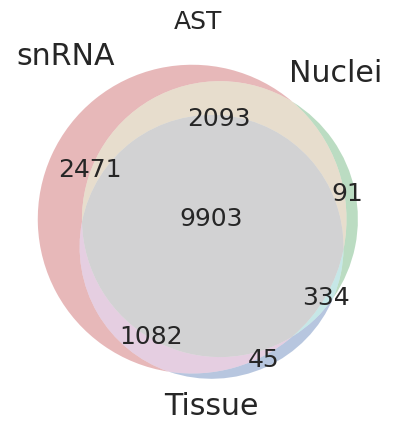

EXC


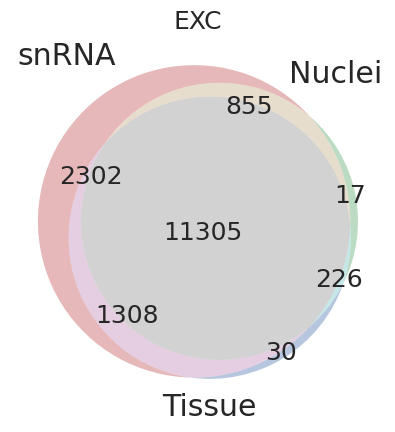

Endo-Mural


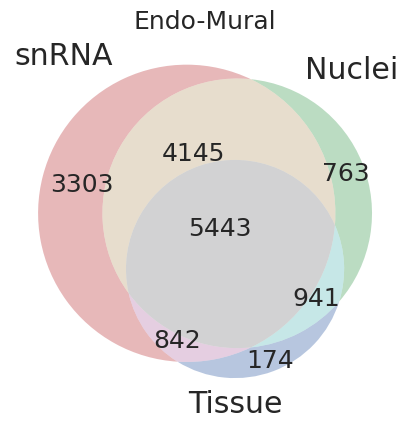

INH


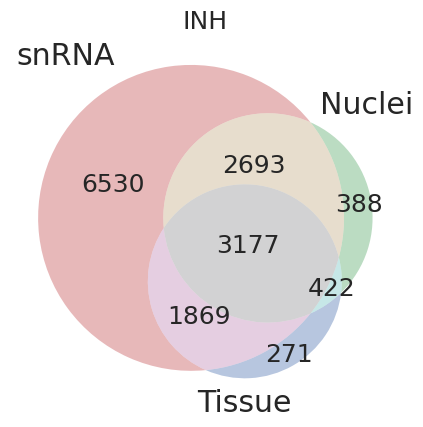

MIC


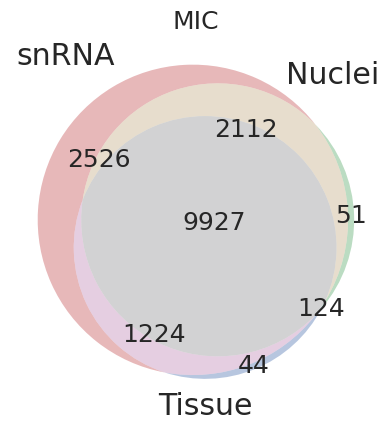

OLD


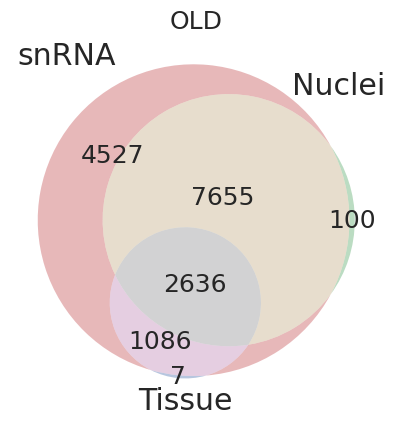

,Cell type,Overlap Type,Number of genes
0,AST,snRNA-deconvoluted tissue/nuclei,9903
1,AST,snRNA-deconvoluted nuclei,2093
2,AST,snRNA-deconvoluted tissue,1082
3,EXC,snRNA-deconvoluted tissue/nuclei,11305
4,EXC,snRNA-deconvoluted nuclei,855
5,EXC,snRNA-deconvoluted tissue,1308
6,Endo-Mural,snRNA-deconvoluted tissue/nuclei,5443
7,Endo-Mural,snRNA-deconvoluted nuclei,4145
8,Endo-Mural,snRNA-deconvoluted tissue,842
9,INH,snRNA-deconvoluted tissue/nuclei,3177


In [201]:
## overlap
from matplotlib_venn import venn3
de_over = pd.DataFrame(columns=["Cell type", "Overlap Type", "Number of genes"])
for it in celltypes:
    print(it)
    total = len(list(set(dico_cell_type[it])))
    total += len(list(set(dico_tissue[it])))
    total+= len(list(set(dico_nuclei[it])))
    overlap_tissue = [itt for itt in list(set(dico_tissue[it])) if itt in list(set(dico_cell_type[it]))]
    overlap_nuclei = [itt for itt in list(set(dico_nuclei[it])) if itt in list(set(dico_cell_type[it]))]
    overlap_3 = [itt for itt in list(set(dico_nuclei[it])) if itt in list(set(dico_cell_type[it])) if itt in list(set(dico_tissue[it]))]

    venn3([set(dico_cell_type[it]), set(dico_nuclei[it]), set(dico_tissue[it])], ["snRNA", "Nuclei","Tissue"])#,subset_label_formatter=lambda x: f"{(x/total):1.0%}")
   
    de_over.loc[len(de_over),:] = [it, "snRNA-deconvoluted tissue/nuclei", len(overlap_3)]
    de_over.loc[len(de_over),:] = [it, "snRNA-deconvoluted nuclei", len(overlap_nuclei)-len(overlap_3)] 
    de_over.loc[len(de_over),:] = [it, "snRNA-deconvoluted tissue", len(overlap_tissue)-len(overlap_3)]
    plt.title(it)
    plt.show()
de_over

AST
EXC
Endo-Mural
INH
MIC
OLD
None


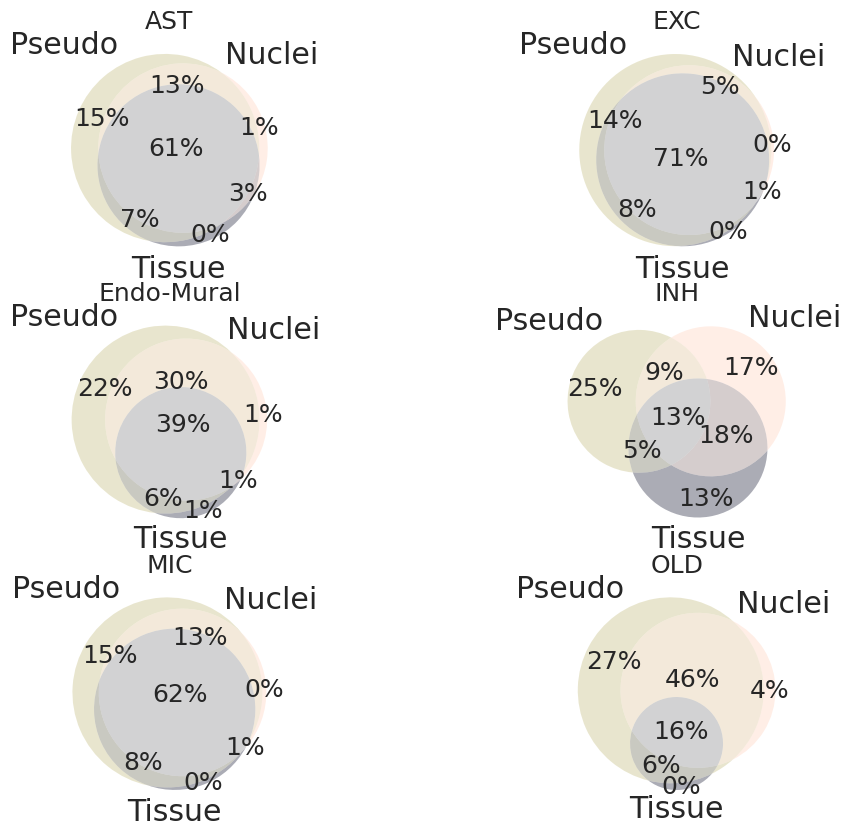

,Cell type,Overlap Type,Number of genes
0,AST,snRNA-deconvoluted nuclei,0.956123
1,AST,snRNA-deconvoluted tissue,0.955473
2,AST,Deconvoluted tissue unique,0.044527
3,AST,Deconvoluted nuclei unique,0.043877
4,EXC,snRNA-deconvoluted nuclei,0.991373
5,EXC,snRNA-deconvoluted tissue,0.991452
6,EXC,Deconvoluted tissue unique,0.008548
7,EXC,Deconvoluted nuclei unique,0.008627
8,Endo-Mural,snRNA-deconvoluted nuclei,0.962628
9,Endo-Mural,snRNA-deconvoluted tissue,0.958919


In [202]:
## overlap
#palette_exp = {"Tissue":"#2D3047", "Nuclei":"#ffd5c2", "snRNA":"#eef2f3"}
def combine_hex_values(d):
  d_items = sorted(d.items())
  tot_weight = sum(d.values())
  red = int(sum([int(k[:2], 16)*v for k, v in d_items])/tot_weight)
  green = int(sum([int(k[2:4], 16)*v for k, v in d_items])/tot_weight)
  blue = int(sum([int(k[4:6], 16)*v for k, v in d_items])/tot_weight)
  zpad = lambda x: x if len(x)==2 else '0' + x
  return zpad(hex(red)[2:]) + zpad(hex(green)[2:]) + zpad(hex(blue)[2:])


from matplotlib_venn import venn3
de_over = pd.DataFrame(columns=["Cell type", "Overlap Type", "Number of genes"])
fig, axes =plt.subplots(3,2, figsize=(12,10))
axes =axes.flatten()
for ii, it in enumerate(celltypes):
    print(it)
    ax =axes[ii]
    total = len(list(set(dico_pseudo[it])))
    total += len(list(set(dico_tissue[it])))
    total+= len(list(set(dico_nuclei[it])))
    tissue_u = [itt for itt in list(set(dico_tissue[it])) if itt not in list(set(dico_pseudo[it]))]# if itt not in list(set(dico_nuclei[it]))]
    tissue_n = [itt for itt in list(set(dico_nuclei[it])) if itt not in list(set(dico_pseudo[it]))]# if itt not in list(set(dico_tissue[it]))]
    overlap_3 = [itt for itt in list(set(dico_nuclei[it])) if itt in list(set(dico_pseudo[it])) if itt in list(set(dico_tissue[it]))]

    overlap_tissue = [itt for itt in list(set(dico_tissue[it])) if itt in list(set(dico_pseudo[it]))]# if itt not in overlap_3]
    overlap_nuclei = [itt for itt in list(set(dico_nuclei[it])) if itt in list(set(dico_pseudo[it]))]# if itt not in overlap_3]
    total = len(set(dico_pseudo[it]).union(set(dico_nuclei[it])).union(set(dico_tissue[it])))
    v = venn3([set(dico_pseudo[it]), set(dico_nuclei[it]), set(dico_tissue[it])],
          ["Pseudo", "Nuclei","Tissue"], ax=ax,subset_label_formatter=lambda x: f"{(x/total):1.0%}")
    
    v.get_patch_by_id('100').set_color("#C7C085")
    v.get_patch_by_id('100').set_edgecolor('none')
    v.get_patch_by_id('010').set_color(palette_exp["Nuclei"])
    v.get_patch_by_id('010').set_edgecolor('none')
    v.get_patch_by_id('001').set_color(palette_exp["Tissue"])
    v.get_patch_by_id('001').set_edgecolor('none')
    
    v110 = combine_hex_values({"C7C085": 0.5, "ffd5c2": 0.5})
    # print(v110)
    try:
        v.get_patch_by_id('110').set_color("#%s"%v110)
        v.get_patch_by_id('110').set_edgecolor('none')
    except:
        print("None")
    try:
        v101 = combine_hex_values({"C7C085": 0.5, "2D3047": 0.5})
        v.get_patch_by_id('101').set_color("#%s"%v101)
        v.get_patch_by_id('101').set_edgecolor('none')
    except:
        print("None")
    try:
        
        v011 = combine_hex_values({"ffd5c2": 0.5, "2D3047": 0.5})
        v.get_patch_by_id('011').set_color("#%s"%v011)
        v.get_patch_by_id('011').set_edgecolor('none')
        # plt.title("Number of OCR DE in %s (%s)"%(ct,br))
    except:
        print("None")
    # de_over.loc[len(de_over),:] = [it, "snRNA-deconvoluted tissue/nuclei", len(overlap_3)]
    de_over.loc[len(de_over),:] = [it, "snRNA-deconvoluted nuclei", len(overlap_nuclei)/len(list(set(dico_nuclei[it])))] 
    de_over.loc[len(de_over),:] = [it, "snRNA-deconvoluted tissue", len(overlap_tissue)/len(list(set(dico_tissue[it])))]
    de_over.loc[len(de_over),:] = [it, "Deconvoluted tissue unique", len(tissue_u)/len(list(set(dico_tissue[it])))]
    de_over.loc[len(de_over),:] = [it, "Deconvoluted nuclei unique", len(tissue_n)/len(list(set(dico_nuclei[it])))]
    ax.set_title(it)
plt.savefig(savepath +"venn_overlap_pseudo.svg")
plt.show()
de_over

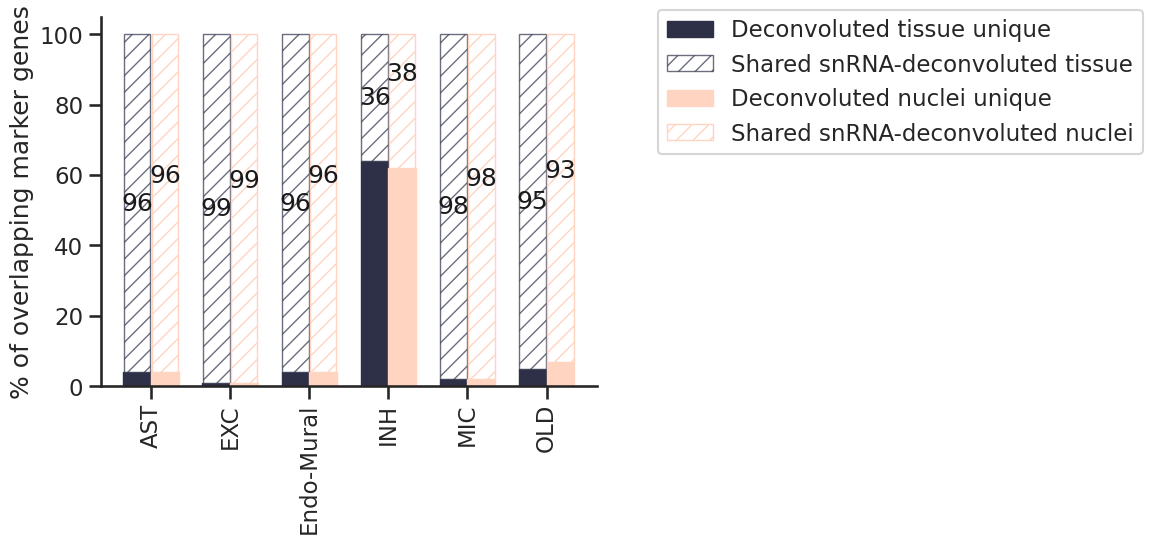

In [203]:
tmp = de_over[de_over["Overlap Type"].str.contains("tissue")].set_index(["Cell type","Overlap Type"]).unstack(["Overlap Type"])
tmp.columns = [it[1] for it in tmp.columns.tolist()]

deconv_tissue_u = (np.round(tmp["Deconvoluted tissue unique"].astype(float)*100)).astype(int).tolist()
snrna_t = (np.round(tmp["snRNA-deconvoluted tissue"].astype(float)*100)).astype(int).tolist()

tmp = de_over[de_over["Overlap Type"].str.contains("nuclei")].set_index(["Cell type","Overlap Type"]).unstack(["Overlap Type"])
tmp.columns = [it[1] for it in tmp.columns.tolist()]

deconv_nuclei_u = (np.round(tmp["Deconvoluted nuclei unique"].astype(float)*100)).astype(int).tolist()
snrna_n = (np.round(tmp["snRNA-deconvoluted nuclei"].astype(float)*100)).astype(int).tolist()

tick = tmp.index.tolist()
with sns.axes_style("white"):
    sns.set_style("ticks")
    sns.set_context("talk")
    
    # plot details
    bar_width = 0.35
    epsilon = .015
    line_width = 1
    opacity = 0.7
    pos_bar_positions = np.arange(len(deconv_tissue_u))
    neg_bar_positions = pos_bar_positions + bar_width
    
    # make bar plots
    dec_t_bar = plt.bar(pos_bar_positions, deconv_tissue_u, bar_width,
                              color=palette_exp["Tissue"],
                                edgecolor=palette_exp["Tissue"],
                        linewidth=line_width,
                              label='Deconvoluted tissue unique')
    
    snrna_t_bar = plt.bar(pos_bar_positions, snrna_t, bar_width-epsilon,
                              bottom=deconv_tissue_u,
                              alpha=opacity,
                              color='white',
                              edgecolor=palette_exp["Tissue"],
                              linewidth=line_width,
                              hatch='//',
                              label='Shared snRNA-deconvoluted tissue')
    plt.bar_label(snrna_t_bar, label_type='center', color="k")
    dec_n_bar = plt.bar(neg_bar_positions, deconv_nuclei_u, bar_width,
                              color=palette_exp["Nuclei"],
                          edgecolor=palette_exp["Nuclei"],
                        linewidth=line_width,
                              label='Deconvoluted nuclei unique')
    snrna_n_bar = plt.bar(neg_bar_positions, snrna_n, bar_width-epsilon,
                              bottom=deconv_nuclei_u,
                              color="white",
                              hatch='//',
                              edgecolor=palette_exp["Nuclei"],
                              # ecolor="#0000DD",
                              linewidth=line_width,
                              label='Shared snRNA-deconvoluted nuclei')
    plt.bar_label(snrna_n_bar, label_type='center', color="k", padding=20)

    plt.xticks((neg_bar_positions+pos_bar_positions)/2, tick, rotation=90)

    plt.legend(bbox_to_anchor=(1.1, 1.05))
    sns.despine()
    plt.ylabel("% of overlapping marker genes")
    plt.savefig(os.path.join(savepath, "overlap_marker_gene_barplot_BOTH.svg"))
    plt.show()

In [ ]:
# fig, ax = plt.subplots(figsize=(12,6))
# sns.barplot(data=de_over,hue="Overlap Type",y= "Number of genes",x="Cell type",
#                  ax=ax,
#                  palette={"snRNA-deconvoluted nuclei":"#a02c5aff","snRNA-deconvoluted tissue":"#27C196","snRNA-deconvoluted tissue/nuclei": "#CACACA"} )
# ax.legend(bbox_to_anchor=(1,1))
# ax.set_ylabel("Number of overlapping marker genes")
# plt.savefig(os.path.join(savepath, "overlap_marker_gene_barplot.svg"))

# Correlation deconv snRNA

/home/eloiseb/miniconda3/envs/pytorch_env/lib/python3.10/site-packages/anndata/_core/anndata.py:117: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)


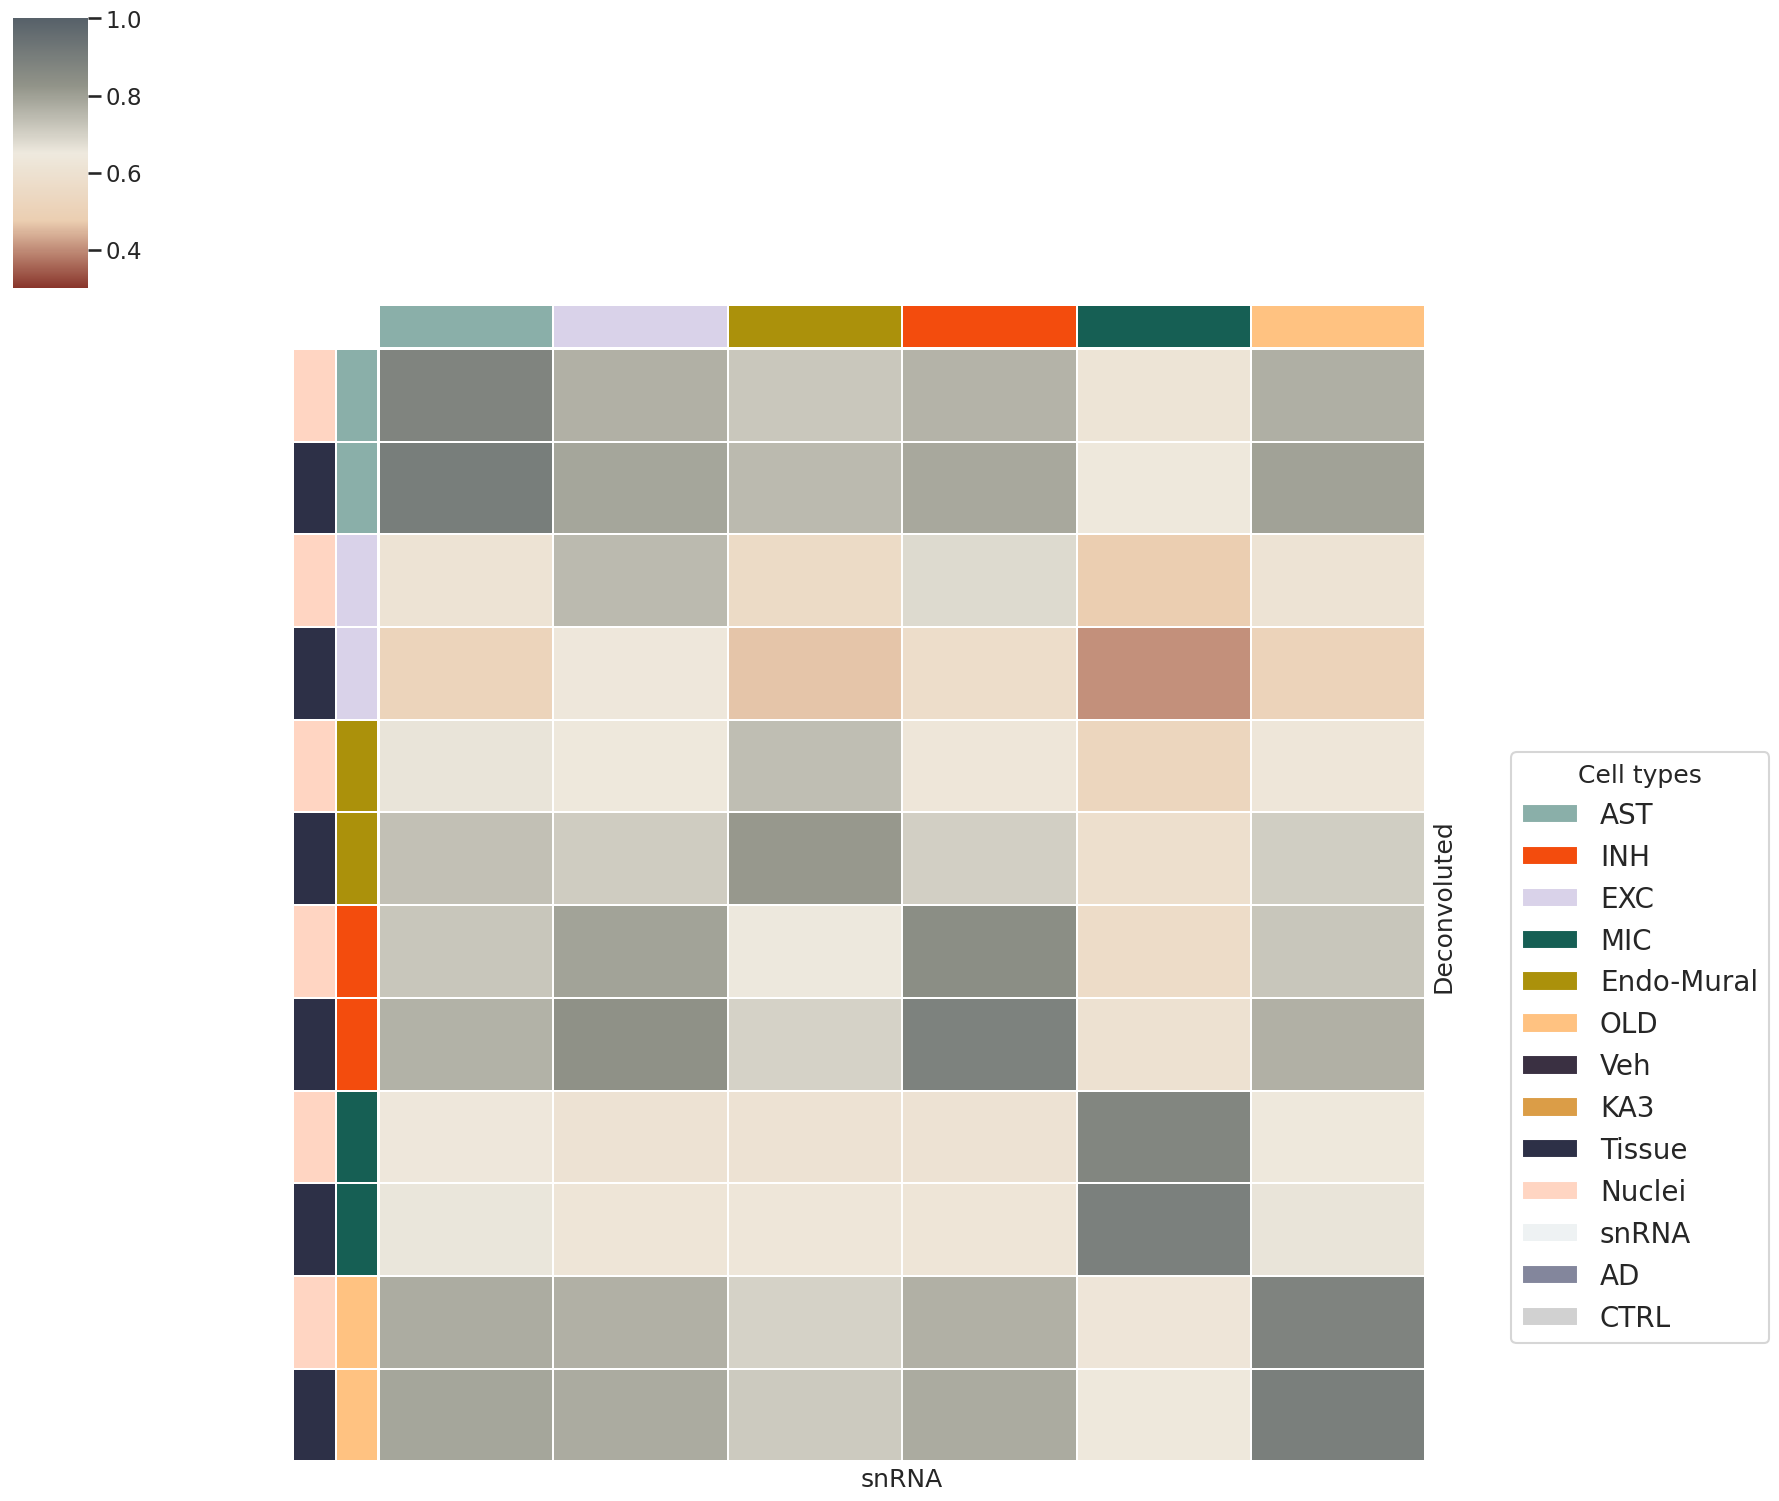

In [204]:
#sc_rna = single_cell[single_cell.obs.Sample_num.isin(df_nn.Sample_num)]

adata_sc = ad.AnnData(pseudo_[new_genes].astype(float))
adata_sc.obs["celltype"] = pseudo_["celltype"].astype(str).values
adata_sc.obs["Sample_num"] = pseudo_["Sample_num"].astype(str).values
adata_sc
df_scrna = adata_sc.to_df()
all_genes=new_genes#sc_rna.var["gene_symbol"].values.tolist()
df_scrna.columns = all_genes
df_scrna["Sample_num"] = adata_sc.obs["Sample_num"].values
df_scrna["celltype"] = adata_sc.obs["celltype"].values

df_log_tis = adata_tissue.to_df()
df_log_tis.columns = all_genes
df_log_tis["Sample_num"] = adata_tissue.obs["Sample_num"].values
df_log_tis["celltype"] = adata_tissue.obs["celltype"].values

df_log_nuc = adata_nuclei.to_df()
df_log_nuc.columns = all_genes
df_log_nuc["Sample_num"] = adata_nuclei.obs["Sample_num"].values
df_log_nuc["celltype"] = adata_nuclei.obs["celltype"].values


df_log_nuc["method"]= "Nuclei"
df_log_tis["method"] ="Tissue"
df_scrna["method"] = "snRNA"
df_scrna = df_scrna.groupby(["celltype", "method", "Sample_num"])[all_genes].sum().reset_index()

combined = pd.concat([df_log_nuc, df_log_tis, df_scrna])

combined

# mE= combined.groupby(["Sample_num","celltype", "method"])[all_genes].mean().reset_index()
# mE


mE= combined.groupby(["celltype", "method"])[all_genes].mean().reset_index()
mE

# mat = mE.set_index(["Sample_num", "celltype", "method"])[all_genes].astype(float).T.corr("spearman")#.reset_index()
# mat


mat = mE.set_index(["celltype", "method"])[all_genes].astype(float).T.corr("spearman")#.reset_index()
mat

mat.columns = ['_'.join(map(str, x)) for x in mat.columns]
mat =mat.reset_index()
mat.method.unique()

x = "snRNA"
mat = mat[mat["method"] ==x].set_index(["celltype", "method"]).T.reset_index()
mat.columns = ['_'.join(map(str, x)) for x in mat.columns]
mat
y="Nuclei"
y2="Tissue"
mat = mat[(mat["index_"].str.contains(y)) | (mat["index_"].str.contains(y2)) ].set_index(["index_"])
#mat = mat[(mat["index_"].str.contains(y)) ].set_index(["index_"])
mat

# print(mat)
# sns.set(font_scale=2)
#fig, ax = plt.subplot

# palette = {"CA1":"#210124","DG":"#C24F7D", "CA3":"#4B072E", "Cortical":"#750D37", "INH":"#94767C", "AST":"#B3DEC1","Oligo":"#74E399","Microglia":"#A4AA9F","Endo":"#686B65"}
pal = {"EXC":"#562c2c", "CA3": "#853140", "CA1":"#FF6E8F", "DG":"#FFBDC8", "INH":"#BFA5A7","ENDO":"#f5dfbb","OLD":"#008A63","OPC":"#27C196", "AST":"#AA4465", "Mural":"#F49A74","MIC":"#6C736A"}
palette=PALETTE
# col_colors_cell =mat.reset_index()["index_"].str.split("_", expand=True)[2].map(PALETTE)
# col_colors_exp =mat.reset_index()["index_"].str.split("_", expand=True)[3].map(palette_exp)

col_colors_cell =mat.reset_index()["index_"].str.split("_", expand=True)[0].map(PALETTE)
col_colors_exp =mat.reset_index()["index_"].str.split("_", expand=True)[1].map(palette_exp)




# row_col = pd.DataFrame(mat.columns.tolist(), columns=["color"])["color"].str.split("_", expand=True)[0].map(PALETTE)
# row_colors_exp =pd.DataFrame(mat.index.tolist(), columns=["color"])["color"].str.split("_", expand=True)[3].map(palette_exp)


row_col = pd.DataFrame(mat.columns.tolist(), columns=["color"])["color"].str.split("_", expand=True)[0].map(PALETTE)
row_colors_exp =pd.DataFrame(mat.index.tolist(), columns=["color"])["color"].str.split("_", expand=True)[1].map(palette_exp)




ytickl = mat.reset_index()["index_"].str.split("_", expand=True)[0].values
g = sns.clustermap(mat.astype(float), col_cluster=False, row_cluster=False, 
                   figsize=(15,15), yticklabels=False, xticklabels=False, cmap=cmap, 
                   row_colors=[row_colors_exp,col_colors_cell],
                   col_colors=[row_col], 
                   vmin=0.3, vmax=1, linewidth=0.2)#,annot=True)
ax = g.ax_heatmap
ax.set_xlabel("snRNA")
ax.set_ylabel("Deconvoluted")
handles = [Patch(facecolor=palette[name]) for name in palette]
handles += [Patch(facecolor=palette_exp[name]) for name in palette_exp]
# handles += [Patch(facecolor=palette_mics[name]) for name in palette_mics]
palette.update(palette_exp)
plt.legend(handles, palette, title='Cell types', fontsize=20,
           bbox_to_anchor=(1.2, 0.5), bbox_transform=plt.gcf().transFigure, loc='upper right')
plt.savefig(os.path.join(savepath, "heat_matrix_corr_snrna_deconvoluted_mice.svg"))




In [205]:
corr_ = mat.reset_index().melt(id_vars=["index_"])
corr_.columns = ["a", "b", "value"]
corr_ =corr_[corr_["a"] != corr_["b"]]

corr_["a_type"] = corr_["a"].str.split("_", expand=True)[1]
corr_["b_type"] = corr_["b"].str.split("_", expand=True)[1]
corr_["a_celltype"] = corr_["a"].str.split("_", expand=True)[0]
corr_["b_celltype"] = corr_["b"].str.split("_", expand=True)[0]
corr_["type"] = (corr_["a_celltype"] == corr_["b_celltype"]).apply(lambda x: "same" if x==1 else "different")
corr_
# m = pd.DataFrame(np.sort(corr_[['a','b']], axis=1), index=corr_.index).duplicated()
# m.sum()

# tmp = corr_[~m]
# tmp

# corr_[['a','b']].values

# np.sort(corr_[['a','b']], axis=1)

,a,b,value,a_type,b_type,a_celltype,b_celltype,type
0,AST_Nuclei,AST_snRNA,0.877321,Nuclei,snRNA,AST,AST,same
1,AST_Tissue,AST_snRNA,0.900567,Tissue,snRNA,AST,AST,same
2,EXC_Nuclei,AST_snRNA,0.613159,Nuclei,snRNA,EXC,AST,different
3,EXC_Tissue,AST_snRNA,0.515028,Tissue,snRNA,EXC,AST,different
4,Endo-Mural_Nuclei,AST_snRNA,0.659540,Nuclei,snRNA,Endo-Mural,AST,different
...,...,...,...,...,...,...,...,...
67,INH_Tissue,OLD_snRNA,0.765644,Tissue,snRNA,INH,OLD,different
68,MIC_Nuclei,OLD_snRNA,0.640667,Nuclei,snRNA,MIC,OLD,different
69,MIC_Tissue,OLD_snRNA,0.659800,Tissue,snRNA,MIC,OLD,different
70,OLD_Nuclei,OLD_snRNA,0.881239,Nuclei,snRNA,OLD,OLD,same


In [206]:
corr_[corr_.type=="same"]

,a,b,value,a_type,b_type,a_celltype,b_celltype,type
0,AST_Nuclei,AST_snRNA,0.877321,Nuclei,snRNA,AST,AST,same
1,AST_Tissue,AST_snRNA,0.900567,Tissue,snRNA,AST,AST,same
14,EXC_Nuclei,EXC_snRNA,0.748102,Nuclei,snRNA,EXC,EXC,same
15,EXC_Tissue,EXC_snRNA,0.637506,Tissue,snRNA,EXC,EXC,same
28,Endo-Mural_Nuclei,Endo-Mural_snRNA,0.738819,Nuclei,snRNA,Endo-Mural,Endo-Mural,same
29,Endo-Mural_Tissue,Endo-Mural_snRNA,0.814487,Tissue,snRNA,Endo-Mural,Endo-Mural,same
42,INH_Nuclei,INH_snRNA,0.845830,Nuclei,snRNA,INH,INH,same
43,INH_Tissue,INH_snRNA,0.885526,Tissue,snRNA,INH,INH,same
56,MIC_Nuclei,MIC_snRNA,0.873166,Nuclei,snRNA,MIC,MIC,same
57,MIC_Tissue,MIC_snRNA,0.893174,Tissue,snRNA,MIC,MIC,same


In [207]:
corr_.groupby(["a_type", "type"]).value.mean()

a_type  type     
Nuclei  different    0.661572
        same         0.827413
Tissue  different    0.673715
        same         0.837790
Name: value, dtype: float64

/home/eloiseb/miniconda3/envs/pytorch_env/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/home/eloiseb/miniconda3/envs/pytorch_env/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/home/eloiseb/miniconda3/envs/pytorch_env/lib/python3.10/site-packages/statannotations/_Plotter.py:337: UserWarning: Invalid x-position found. Are the same parameters passed to seaborn and statannotations calls? or are there few data points?
  warnings.warn(
/home/eloiseb/miniconda3/envs/pytorch_env/lib/python3.10/site-packages/statannotations/_Plotter.py:337: UserWarning: Invalid x-position found. Are the sa

p-value annotation legend:
      ns: 5.00e-02 < p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

same_Nuclei vs. same_Tissue: Mann-Whitney-Wilcoxon test two-sided, P_val:2.403e-01 U_stat=1.000e+01
same_Nuclei vs. different_Nuclei: Mann-Whitney-Wilcoxon test two-sided, P_val:3.984e-04 U_stat=1.660e+02
same_Tissue vs. different_Tissue: Mann-Whitney-Wilcoxon test two-sided, P_val:1.893e-03 U_stat=1.590e+02


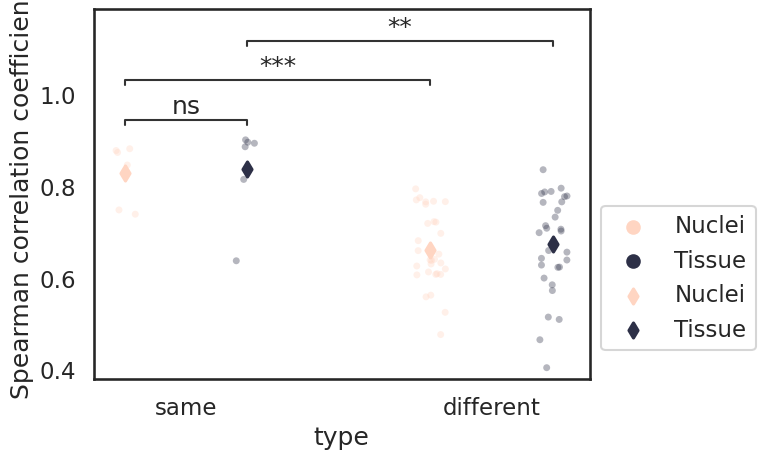

In [208]:
palette = ["#CDC392","#F1F1E6","#F5F8FF","#9EB7E5","#648DE5","#304C89"]#"#A9A179",
from statannotations.Annotator import Annotator
ax = sns.stripplot(data=corr_, x="type", y="value", hue="a_type", palette=palette_exp, 
                  dodge=True, alpha=.35, zorder=1)
# sns.violinplot(data=corr_, x="type", y="value", hue="a_type", ax=ax, color=None)#, palette={"Nuclei":"#304C89", "Tissue": "#CDC392"}
sns.pointplot(ax=ax,
    data=corr_, x="type", y="value", hue="a_type",
    join=False,  palette=palette_exp,dodge=.8 - .8 / 2,
    markers="d", scale=.75, errorbar=None
)
ax.set_ylabel("Spearman correlation coefficient")
# pairs=[(("different", "Nuclei"), ("same", "Nuclei")),(("different", "Tissue"), ("same", "Tissue"))]
pairs=[(("different", "Nuclei"), ("same", "Nuclei")),
       (("same", "Tissue"), ("same", "Nuclei")),
       (("different", "Tissue"), ("same", "Tissue"))]
annotator = Annotator(ax, pairs, data=corr_, x="type", y="value", hue="a_type")
annotator.configure(test='Mann-Whitney', text_format='star', loc='inside')
annotator.apply_and_annotate()
ax.legend(bbox_to_anchor=(1,0.5))
plt.savefig(os.path.join(savepath, "distribution_correlation_coefficient_dec_snrna_same_different_ct_mice.svg"))

# snRNA Autocorrrelation matrix

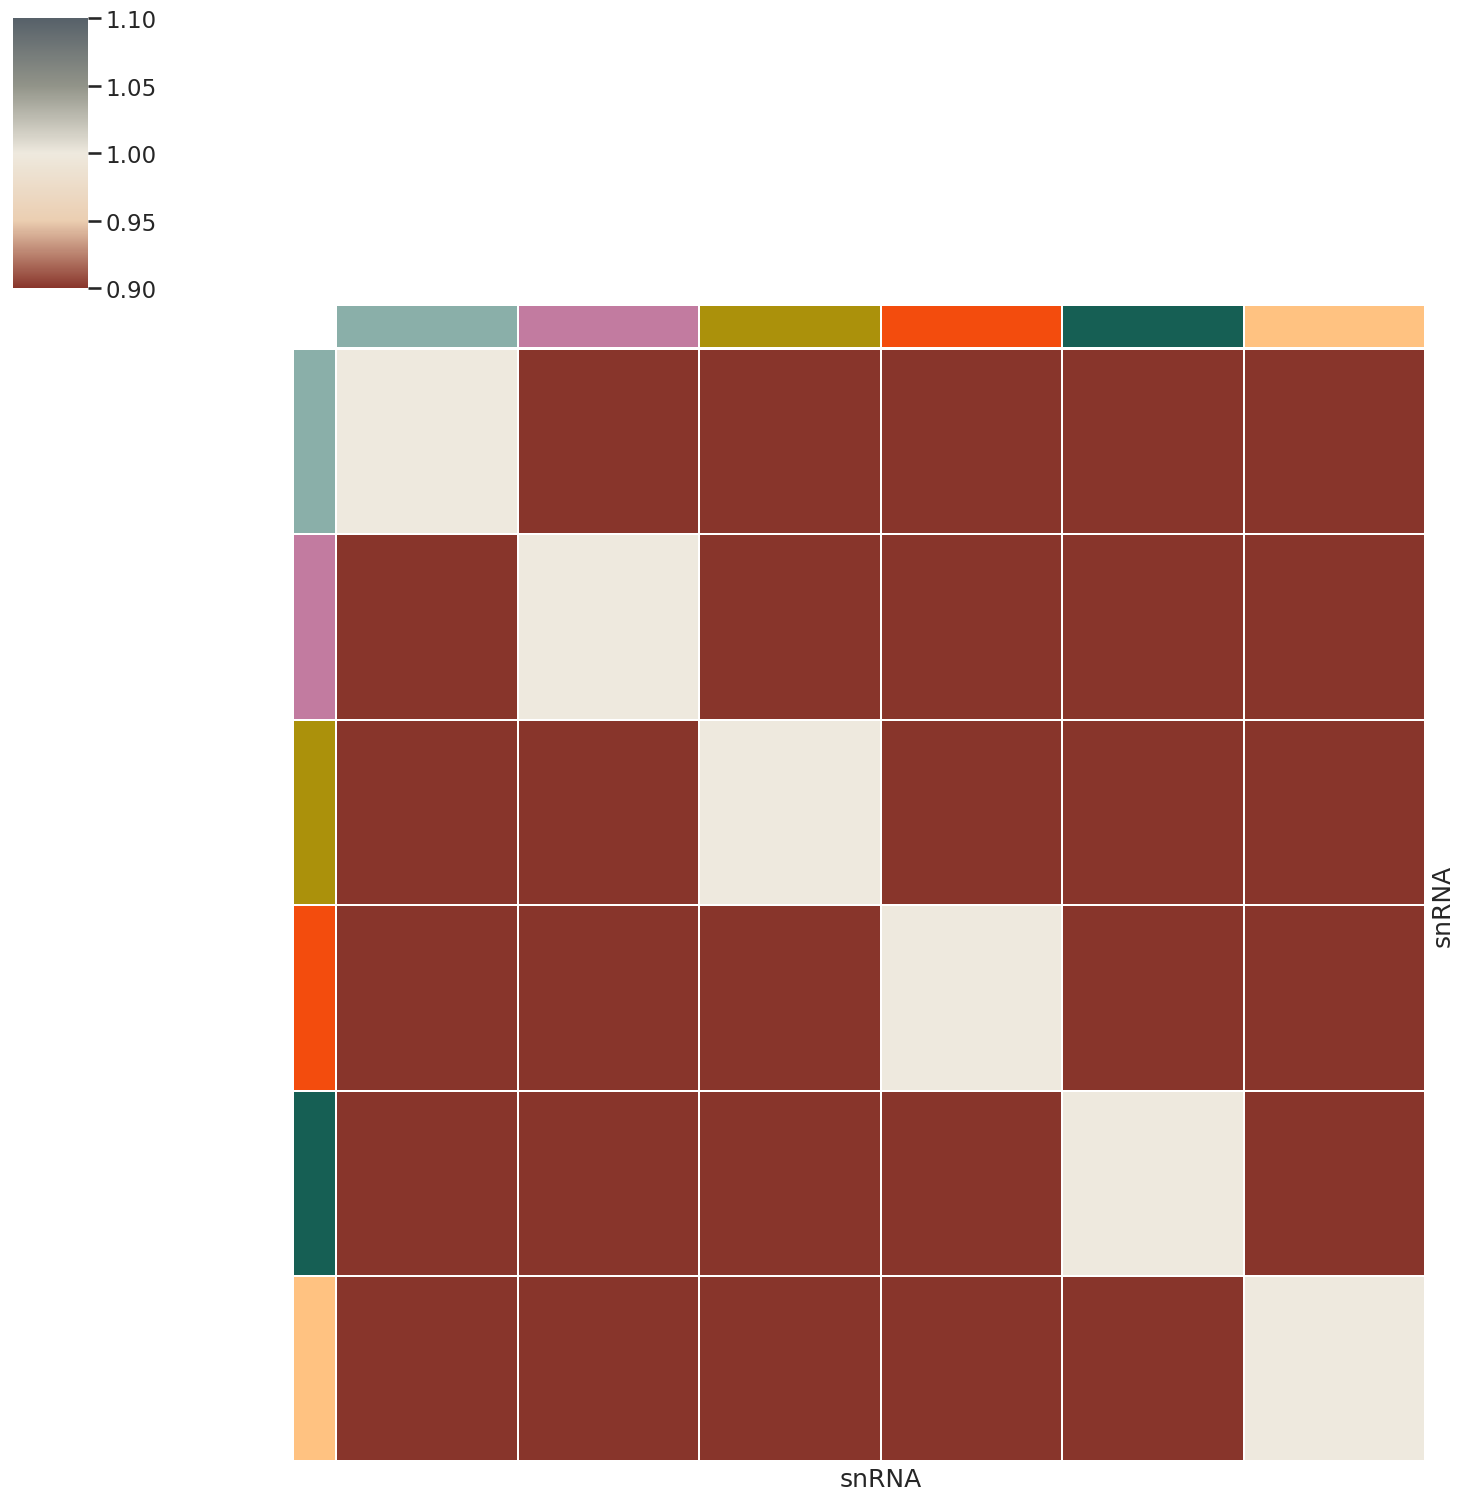

In [50]:
mat = mE.set_index(["celltype", "method"])[all_genes].astype(float).T.corr("pearson")#.reset_index()
mat

mat.columns = ['_'.join(map(str, x)) for x in mat.columns]
mat =mat.reset_index()
mat.method.unique()

x = "snRNA"
mat = mat[mat["method"] ==x].set_index(["celltype", "method"]).T.reset_index()
mat.columns = ['_'.join(map(str, x)) for x in mat.columns]
mat
y="Nuclei"

mat = mat[(mat["index_"].str.contains(x)) ].set_index(["index_"])
#mat = mat[(mat["index_"].str.contains(y)) ].set_index(["index_"])
mat

# print(mat)
# sns.set(font_scale=2)
#fig, ax = plt.subplot
col_colors_cell =mat.reset_index()["index_"].str.split("_", expand=True)[0].map(PALETTE)
#col_colors_exp =mat.reset_index()["index_"].str.split("_", expand=True)[1].map(palette_exp)

row_col = pd.DataFrame(mat.columns.tolist(), columns=["color"])["color"].str.split("_", expand=True)[0].map(PALETTE)
row_colors_exp =pd.DataFrame(mat.columns.tolist(), columns=["color"])["color"].str.split("_", expand=True)[1].map(palette_exp)

ytickl = mat.reset_index()["index_"].str.split("_", expand=True)[0].values
g = sns.clustermap(mat, col_cluster=False, row_cluster=False, figsize=(15,15), yticklabels=False, xticklabels=False, cmap=cmap, 
                   row_colors=[col_colors_cell], col_colors=[row_col], vmin=1, vmax=1, linewidth=0.3)#,annot=True)
ax = g.ax_heatmap
ax.set_xlabel("snRNA")
ax.set_ylabel("snRNA")
# ax.set_xlabel(x)
# ax.set_ylabel(y)
plt.savefig(os.path.join(savepath, "heat_matrix_autocorr_snrna_snrna_mice.svg"))

In [209]:

# celltypes = ['AST', 'Endo-Mural', 'EXC-L23', 'EXC-L4', 'EXC-L5', 'EXC-L6',
#        'INH', 'MIC', 'OLD', 'OPC']
# celltypes = ['AST', 'Endo-Mural', 'EXC',
#        'INH', 'MIC', 'OLD', 'OPC']
# celltypes = ['AST', 'Endo', 'EXC-IT',  'EXC-L6-spe',
#        'INH-CGE', 'INH-MGE', 'MIC', 'OLD', 'OPC', "VLMC"]
fold = 0
model_f = model + "/exp_kfold_%s/test/"%str(fold)
deconv_ = model_f +  "bulk_sample_decon_bulk_tissues_refinedtp/bulk_sample_decon/predictions_pseudobulk_Test_no_filt.npz"
ll = np.load(deconv_)["mat"]
ll.shape
deconv_ = model_f + "bulk_sample_decon_bulk_tissues_refinedtp/bulk_sample_decon/labels_Test.npz"
ff = np.load(deconv_)["mat"]
ll[ll<0] = 0
ll.shape
# ll = ll*mask[np.newaxis, :, :]

df_tissue = pd.DataFrame(columns=["Sample_num", "celltypes"]+ genes)
for i,it in enumerate(ff):
    for j,ct in enumerate(celltypes):
        df_tissue.loc[len(df_tissue), :] = [it, ct] + ll[i,j, :].tolist()
# df_tissue = df_tissue[df_tissue.Sample_num.isin(both_exp)]
df_tissue.Sample_num = df_tissue.Sample_num.str.replace("12hr_","")
df_tissue
# df_tissue.Sample_num =df_tissue["Sample_num"].astype(int).map(mapping_)
# df_tissue["Diagnosis"] = df_tissue["Sample_num"].str.split("_", expand=True)[1].values
df_tissue


deconv_ = model_f + "/bulk_sample_decon_bulk_nuclei_refinedtp/bulk_sample_decon/predictions_pseudobulk_Test_no_filt.npz"
ll = np.load(deconv_)["mat"]
ll.shape
deconv_ = model_f + "/bulk_sample_decon_bulk_nuclei_refinedtp/bulk_sample_decon/labels_Test.npz"
ff = np.load(deconv_)["mat"]
ll.shape
ll[ll<0] = 0
# ll = ll*mask[np.newaxis, :, :]

df_nuclei = pd.DataFrame(columns=["Sample_num", "celltypes"]+ genes)
for i,it in enumerate(ff):
    for j,ct in enumerate(celltypes):
        df_nuclei.loc[len(df_nuclei), :] = [it, ct] + ll[i,j, :].tolist()
df_nuclei.Sample_num = df_nuclei.Sample_num.str.replace("12hr_","")

# df_nuclei.Sample_num =df_nuclei["Sample_num"].astype(int).map(mapping_)
df_nuclei

,Sample_num,celltypes,XKR4,GM1992,MRPL15,LYPLA1,TCEA1,RGS20,GM16041,ATP6V1H,...,GM15884,DEFB39,GM12061,GM12356,VMN1R206,2310005E17RIK,1600019K03RIK,NXF3,CYP2C65,GM10197
0,KA25_ko2,AST,173.947128,29.715837,471.106689,215.242172,447.020721,316.886444,0.0,2852.587891,...,0.100216,0.025269,0.011372,0.050521,0.307883,0.003342,0.028403,0.0,0.0,0.0
1,KA25_ko2,EXC,0.0,0.0,0.0,0.408762,0.0,0.0,0.0,0.0,...,0.041878,0.016332,0.007291,0.105035,0.15935,0.012481,0.002235,0.0,0.0,0.0
2,KA25_ko2,Endo-Mural,0.0,2.87973,22.17395,12.986157,29.635958,3.840704,0.0,43.436283,...,0.048333,0.013258,0.005145,0.170699,0.236256,0.001631,0.0,0.0,0.0,0.0
3,KA25_ko2,INH,573.871765,71.347923,192.010651,159.831329,390.158478,73.858002,67.581367,1656.492554,...,0.058547,0.02684,0.009856,0.173776,0.254057,0.024875,0.006446,0.0,0.0,0.0
4,KA25_ko2,MIC,15.386956,0.0,12.568618,0.0,0.0,7.801866,0.0,164.534073,...,0.03771,0.023964,0.0,0.089188,0.278248,0.003167,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
91,Veh_wt3,EXC,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.090842,0.01636,0.038615,0.0,0.39277,0.027878,0.014812,0.0,0.0,0.0
92,Veh_wt3,Endo-Mural,0.0,0.0,0.0,0.72618,7.678163,0.0,0.0,23.882118,...,0.136179,0.011475,0.028122,0.0,0.641209,0.017835,0.014413,0.0,0.0,0.0
93,Veh_wt3,INH,566.963806,94.855103,171.597473,180.399048,361.682251,49.793892,28.592163,1088.402344,...,0.144577,0.035579,0.049134,0.0,0.587019,0.032308,0.002368,0.0,0.0,0.0
94,Veh_wt3,MIC,31.693865,0.0,11.41903,0.0,0.0,24.124374,0.0,324.192627,...,0.135956,0.030826,0.0,0.0,0.606328,0.016555,0.005726,0.0,0.0,0.0


In [210]:
bulk_t = df_tissue#.reset_index().rename({"index":"Sample_num"}, axis=1)
bulk_t["Group"] = bulk_t["Sample_num"].str.split("_",expand=True)[0]
bulk_t["Mice"] = bulk_t["Sample_num"].str.split("_",expand=True)[1].str.replace('\d+', '')
bulk_t

bulk_t["Experiment"] = "Tissue"
# bulk_t = bulk_t.merge(metadata[["Sample_num","Sex"]], on="Sample_num")
bulk_nuclei = df_nuclei#.reset_index().rename({"index":"Sample_num"}, axis=1)
bulk_nuclei["Group"] = bulk_nuclei["Sample_num"].str.split("_",expand=True)[0]
bulk_nuclei["Mice"] = bulk_nuclei["Sample_num"].str.split("_",expand=True)[1].str.replace('\d+', '')
bulk_nuclei
bulk_nuclei["Experiment"] = "Nuclei"
# bulk_nuclei = bulk_nuclei.merge(metadata[["Sample_num","Sex"]], on="Sample_num")



bulk_nuclei

,Sample_num,celltypes,XKR4,GM1992,MRPL15,LYPLA1,TCEA1,RGS20,GM16041,ATP6V1H,...,GM12356,VMN1R206,2310005E17RIK,1600019K03RIK,NXF3,CYP2C65,GM10197,Group,Mice,Experiment
0,KA25_ko2,AST,173.947128,29.715837,471.106689,215.242172,447.020721,316.886444,0.0,2852.587891,...,0.050521,0.307883,0.003342,0.028403,0.0,0.0,0.0,KA25,ko2,Nuclei
1,KA25_ko2,EXC,0.0,0.0,0.0,0.408762,0.0,0.0,0.0,0.0,...,0.105035,0.15935,0.012481,0.002235,0.0,0.0,0.0,KA25,ko2,Nuclei
2,KA25_ko2,Endo-Mural,0.0,2.87973,22.17395,12.986157,29.635958,3.840704,0.0,43.436283,...,0.170699,0.236256,0.001631,0.0,0.0,0.0,0.0,KA25,ko2,Nuclei
3,KA25_ko2,INH,573.871765,71.347923,192.010651,159.831329,390.158478,73.858002,67.581367,1656.492554,...,0.173776,0.254057,0.024875,0.006446,0.0,0.0,0.0,KA25,ko2,Nuclei
4,KA25_ko2,MIC,15.386956,0.0,12.568618,0.0,0.0,7.801866,0.0,164.534073,...,0.089188,0.278248,0.003167,0.0,0.0,0.0,0.0,KA25,ko2,Nuclei
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
91,Veh_wt3,EXC,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.39277,0.027878,0.014812,0.0,0.0,0.0,Veh,wt3,Nuclei
92,Veh_wt3,Endo-Mural,0.0,0.0,0.0,0.72618,7.678163,0.0,0.0,23.882118,...,0.0,0.641209,0.017835,0.014413,0.0,0.0,0.0,Veh,wt3,Nuclei
93,Veh_wt3,INH,566.963806,94.855103,171.597473,180.399048,361.682251,49.793892,28.592163,1088.402344,...,0.0,0.587019,0.032308,0.002368,0.0,0.0,0.0,Veh,wt3,Nuclei
94,Veh_wt3,MIC,31.693865,0.0,11.41903,0.0,0.0,24.124374,0.0,324.192627,...,0.0,0.606328,0.016555,0.005726,0.0,0.0,0.0,Veh,wt3,Nuclei


/home/eloiseb/miniconda3/envs/pytorch_env/lib/python3.10/site-packages/anndata/_core/anndata.py:117: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
/home/eloiseb/miniconda3/envs/pytorch_env/lib/python3.10/site-packages/anndata/_core/anndata.py:782: UserWarning: 
AnnData expects .obs.index to contain strings, but got values like:
    [0, 1, 2, 3, 4]

    Inferred to be: integer

  value_idx = self._prep_dim_index(value.index, attr)
/home/eloiseb/miniconda3/envs/pytorch_env/lib/python3.10/site-packages/pandas/core/generic.py:6329: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  self[name] = value
/home/eloiseb/miniconda3/envs/pytorch_env/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_co

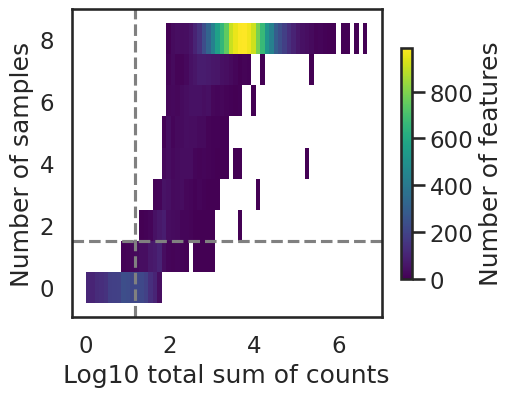

In [211]:
import decoupler as dc
ada = ad.AnnData(bulk_nuclei[genes])
ada.obs = bulk_nuclei[["Sample_num","Group","Mice", "Experiment","celltypes"]]
ada.obs.reset_index(inplace=True, drop=True)
ada.obs.index= ada.obs.index.astype(str)
ada = ada[~ada.obs.Sample_num.str.contains("ko")]
ada = ada[~ada.obs.Sample_num.str.contains("6h|24h")]

ada.obs.Sample_num = ada.obs.Sample_num.str.replace("VEH", "Veh")
ada.obs.Sample_num = ada.obs.Sample_num.str.replace("WT", "wt")

ct = "AST"
tmp =ada[ada.obs.celltypes==ct].copy()
tmp = tmp[:,tmp.X.sum(0)>0].copy()
tmp.X = tmp.X.astype(float)
# (tmp.X.sum(0)>0).sum()
dc.plot_filter_by_expr(tmp, group='Group', min_count=10, min_total_count=15)


/tmp/ipykernel_1576951/1307247083.py:12: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  plt.scatter(y,x,cmap="viridis")


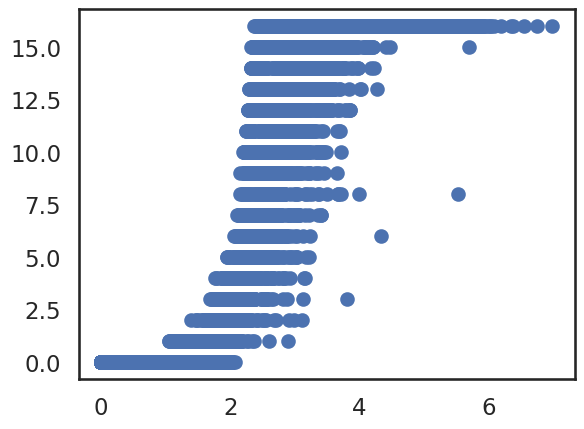

In [212]:
tmp = bulk_nuclei[bulk_nuclei.celltypes=="AST"]
min_count=10

# plt.(tmp[genes].astype(float).sum(0), 
y = np.log10(tmp[genes].astype(float).sum(0)+1)

# # mask = tmp[genes].copy()
# # mask[mask<=min_count] = 0
# # mask[mask>min_count] = 1

# x = mask.sum(0)
# plt.scatter(y,x,cmap="viridis")

In [213]:
pseudo_ = pseudo_.rename({"celltype":"celltypes"}, axis=1)
pseudo_["Experiment"] = "snRNA"
pseudo_["Group"] = pseudo_["Sample_num"].str.split("_",expand=True)[1]
pseudo_["Mice"] = pseudo_["Sample_num"].str.split("_",expand=True)[1].str.replace('\d+', '')
pseudo_.Sample_num.unique()

array(['Veh_wt1', 'Veh_wt2', 'Veh_wt3', 'Ctl1', 'Ctl2', 'Ctl3', 'Ctl4',
       'KA25_wt11', 'KA25_wt12', 'KA25_wt13', 'KA25_wt14', 'KA25_wt15',
       'KA25_wt16', 'KA3_wt1', 'KA3_wt2', 'KA3_wt3', 'KA25_wt4'],
      dtype=object)

In [214]:
combine = pd.concat([bulk_t, bulk_nuclei, pseudo_], axis=0)
combine.to_csv("/remote/home/eloiseb/data/rna/mice_snrna/combine_mice_wt.csv")

In [215]:
combine = pd.read_csv("/remote/home/eloiseb/data/rna/mice_snrna/combine_mice_wt.csv")
combine

,Unnamed: 0,Sample_num,celltypes,XKR4,GM1992,MRPL15,LYPLA1,TCEA1,RGS20,GM16041,...,GM12356,VMN1R206,2310005E17RIK,1600019K03RIK,NXF3,CYP2C65,GM10197,Group,Mice,Experiment
0,0,KA25_ko1,AST,140.984268,19.031956,173.481155,1.564098,189.031586,234.847382,0.000000,...,0.020082,0.005316,0.000000,0.009371,0.0,0.0,0.0,KA25,ko1,Tissue
1,1,KA25_ko1,EXC,0.000000,0.000000,0.000000,0.179596,0.000000,0.000000,0.000000,...,0.039077,0.008565,0.005696,0.000000,0.0,0.0,0.0,KA25,ko1,Tissue
2,2,KA25_ko1,Endo-Mural,19.359356,33.848820,46.219036,34.608688,141.560074,0.000000,7.468129,...,0.096047,0.000000,0.000000,0.000000,0.0,0.0,0.0,KA25,ko1,Tissue
3,3,KA25_ko1,INH,486.459106,143.977753,98.233788,57.938831,391.046021,45.101685,65.846016,...,0.082554,0.006781,0.008317,0.000000,0.0,0.0,0.0,KA25,ko1,Tissue
4,4,KA25_ko1,MIC,12.546606,0.000000,19.422533,0.000000,0.785574,3.337508,2.596602,...,0.056956,0.003154,0.000000,0.005465,0.0,0.0,0.0,KA25,ko1,Tissue
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
529,97,KA25_wt4,EXC,52361.000000,6481.000000,1046.000000,1373.000000,3409.000000,1602.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,wt4,wt4,snRNA
530,98,KA25_wt4,Endo-Mural,8.000000,0.000000,7.000000,9.000000,18.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,wt4,wt4,snRNA
531,99,KA25_wt4,INH,14633.000000,1832.000000,133.000000,209.000000,514.000000,540.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,wt4,wt4,snRNA
532,100,KA25_wt4,MIC,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,wt4,wt4,snRNA


In [216]:
combine = combine[~combine.Sample_num.str.contains("ko")]
combine = combine[~combine.Sample_num.str.contains("6h|24h")]

combine.Sample_num = combine.Sample_num.str.replace("VEH", "Veh")
combine.Sample_num = combine.Sample_num.str.replace("WT", "wt")
combine.Mice = combine.Mice.str.replace("WT", "wt")
combine.Group = combine.Sample_num.str.split("_",expand=True)[0]
combine = combine[combine.Sample_num.isin(both_exp)]

combine.Sample_num.unique()

array(['KA3_wt1', 'KA3_wt2', 'KA3_wt3', 'KA3_wt4', 'Veh_wt1', 'Veh_wt2',
       'Veh_wt3', 'Veh_wt4'], dtype=object)

In [217]:
both_exp

['KA3_wt1',
 'KA3_wt2',
 'KA3_wt3',
 'Veh_wt1',
 'Veh_wt2',
 'Veh_wt3',
 'Veh_wt4',
 'KA3_wt1',
 'KA3_wt2',
 'KA3_wt3',
 'KA3_wt4']

In [218]:
combine.Group.unique()

array(['KA3', 'Veh'], dtype=object)

In [219]:
combined.Sample_num.unique()

array(['KA3_wt1', 'KA3_wt2', 'KA3_wt3', 'Veh_wt1', 'Veh_wt2', 'Veh_wt3',
       'Ctl1', 'Ctl2', 'Ctl3', 'Ctl4', 'KA25_wt11', 'KA25_wt12',
       'KA25_wt13', 'KA25_wt14', 'KA25_wt15', 'KA25_wt16', 'KA25_wt4'],
      dtype=object)

In [220]:
# celltypes = ['AST', 'EXC', 'Endo-Mural', 'INH', 'MIC', 'OLD']

In [246]:
mask

array([[1., 0., 1., ..., 0., 0., 0.],
       [1., 1., 1., ..., 0., 0., 0.],
       [1., 0., 1., ..., 0., 0., 0.],
       [1., 1., 1., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [1., 1., 1., ..., 0., 0., 0.]])

In [270]:
from pydeseq2.dds import DeseqDataSet
# from pydeseq2.DeseqDataSet import DeseqDataSet
# from bioinfokit import analys, visuz
from pydeseq2.ds import DeseqStats
# from pydeseq2.DeseqStats import DeseqStats
from statsmodels.stats.multitest import multipletests 
import numpy as np
import scanpy as sc
df_dif = []

method = 'logreg'
group="Group"
combine["Sample_ind"] = combine["Sample_num"].astype(str) + "_" + combine["Experiment"].astype(str)
combine["condition"] = combine["Mice"].astype(str) + "_" + combine["Group"].astype(str)

min_count=2
min_total_count=5

tis = combine[~combine.Mice.isna()]
tis = tis[tis.Mice.str.contains("wt")]
nb_boostrap = 10
# for it in range(nb_boostrap):
for test in [ "KA3"]:
        # combined = combine[combine.Group.isin(["VEH","Veh", test])].copy(deep=True)
            combined2 = tis[tis.Group.isin([ "Veh", test])].copy(deep=True)
            unique_=combined2.Sample_num.unique().tolist()
        # for it, itt in enumerate(unique_):
        #     combined = combined2[combined2.Sample_num!=itt]

        # combined = combined.sample(frac=0.9, replace=False, random_state=it)
            print(combined.Sample_num.unique())
            count_df = combined.set_index("Sample_ind")[genes]
            cl = combined.set_index("Sample_ind")[[ "condition","Experiment","Mice",
                                                   "Group", "celltypes"]]
            print(test)
            for exp in cl.Experiment.unique():
                print(exp)
            
            #for mi in cl.Mice.unique():
                
                for ii, ct in enumerate(cl.celltypes.unique()):
                    print(ct)
                    tmp_g = np.asarray(genes)[np.where(mask[ii,:]==1)[0]].tolist()
                    c_tmp = count_df.loc[(cl.celltypes==ct) &(cl.Experiment==exp),:][tmp_g].astype(float)
                    gene_null = np.where(c_tmp.sum(0)!=0)[0]
                    print(gene_null.shape)
                    tmp_g = np.asarray(tmp_g)[gene_null]
                    c_tmp = c_tmp[tmp_g.tolist()]
    
                    
                    ma = c_tmp.copy()
                    ma[ma<=min_count] = 0
                    ma[ma>min_count] = 1
                    list_ = ma.sum(0)>min_count
                    list_2 = c_tmp.astype(float).sum(0)>min_total_count
                    # list_e = [it for ii, it in enumerate(list_) if it and list_2[ii]]
                    list_e = [True if it and list_2[ii] else False for ii, it in enumerate(list_) ]
                    c_tmp = c_tmp.iloc[:,list_e]
                    
                    print(c_tmp.shape)
                    cl_tmp = cl.loc[(cl.celltypes==ct) &(cl.Experiment==exp),:]
                    
    
                    dds = DeseqDataSet(
                        counts=c_tmp.astype(int),
                        metadata=cl_tmp,
                        design_factors="Group",
                        refit_cooks=True,
                        # n_cpus=8,
                        )
                    dds.deseq2()
    
                    stat_res = DeseqStats(dds,contrast=["Group", test, "Veh"])#,independent_filter=False,cooks_filter=False)
                    stat_res.summary()
                    glist =stat_res.results_df
                    glist["gene"] =glist.index.tolist()
                    pp = "pvalue"#"pvals"
                    lf = "log2FoldChange"#"logfoldchanges"
                   # pp = "padj"

                # dat = ad.AnnData(c_tmp)
                # dat.obs = cl_tmp
                # dat.var["gene"] = c_tmp.columns.tolist()

                # sc.tl.rank_genes_groups(dat, groupby="Group", method=method, 
                #                             rankby_abs=True,
                #                            gene_symbols="gene",
                #                             #gene_symbols="peakid",
                #                             key_added = method)
                # glist = sc.get.rank_genes_groups_df(dat, group=test,
                #                                     # groupby="Group",
                #                                     gene_symbols="gene",
                #                                     key=method, #log2fc_min=0.25, 
                #                                     )#['names'].squeeze().str.strip().tolist()
                # # glist = glist.merge(dat.var, on="names")
    
                    # #     #min_pval = glist[glist.pvals_adj>0]["pvals_adj"].min()
    
                    # pp = "pvals"
                    # lf = "logfoldchanges"
                    glist["padj_fdr"] = 1
                    glist.loc[~glist[pp].isna(),"padj_fdr"] = multipletests(
                                           glist.loc[~glist[pp].isna(),pp].values, method="fdr_bh")[1]
                    pp = "padj_fdr"
    
    
               
                    # glist["Mice"] = mi
                    glist["celltypes"] = ct
                    glist["Experiments"] = exp
                    glist["Test"] = test
                    glist["iteration"] = it
    
                    glist.loc[glist[lf].isna(),lf] =0  
                    glist.loc[glist[pp].isna(),pp] = 1   


    
                    FC=1
                    pval=0.05
                    pval2 = pval
                    #pval2 = 1e-100
                    #print(glist.sort_values("padj_fdr"))
                    genenames = glist[(np.abs(glist[lf])>FC) &( glist[pp]<pval2)]["gene"].tolist()
    
                    df_dif.append(glist)
                    print(len(genenames))
                    # if len(genenames)!=0:
                    #     try:
                    #         visuz.GeneExpression.volcano(df=glist, lfc=lf, pv=pp, show=True,
                    #                                          pv_thr=(pval, pval), lfc_thr=(FC, FC),
                    #                                  geneid="gene",
                    #                                             genenames=genenames,
                    #                                  gstyle=2,
                    #                                  plotlegend=True,
                    #                                  legendlabels=[test, "NS", "Veh"], 
                    #                                         sign_line=True,#figname = savepath + "deconv_promoter_volcano_%s_%s"%(ct,ba),
                    #                                          color=('#724600', "grey", '#004d4b'))
                    #     except:
                    #         print("ok")
print("done")

['KA3_wt1' 'KA3_wt2' 'KA3_wt3' 'KA3_wt4' 'Veh_wt1' 'Veh_wt2' 'Veh_wt3']
KA3
Tissue
AST
(10902,)
(7, 10620)


Fitting size factors...
... done in 0.00 seconds.

Fitting dispersions...
... done in 10.39 seconds.

Fitting dispersion trend curve...
... done in 0.34 seconds.

Fitting MAP dispersions...
... done in 12.01 seconds.

Fitting LFCs...
... done in 5.45 seconds.

Replacing 0 outlier genes.

Running Wald tests...
... done in 1.92 seconds.



Log2 fold change & Wald test p-value: Group KA3 vs Veh
           baseMean  log2FoldChange     lfcSE      stat    pvalue      padj
XKR4     138.119234       -0.063516  0.331859 -0.191394  0.848217  0.889949
MRPL15   271.084913        0.242682  0.139484  1.739854  0.081885  0.137796
LYPLA1    51.923332       -0.398516  0.369962 -1.077183  0.281399  0.379486
TCEA1    333.924143       -0.451991  0.153515 -2.944287  0.003237  0.008549
RGS20    289.558849       -0.537875  0.137194 -3.920544  0.000088  0.000356
...             ...             ...       ...       ...       ...       ...
GM14762    9.388808       -0.040409  0.699967 -0.057730  0.953964  0.966984
HSF3       1.429026        0.748821  1.743273  0.429549  0.667524  0.745777
GM14866    1.693348       -0.010086  1.429503 -0.007056  0.994371  0.995871
GUCY2F     6.013158       -0.518148  0.807122 -0.641970  0.520893  0.617742
GM11827    1.972392        0.829460  1.554757  0.533498  0.593689  0.684059

[10620 rows x 6 columns]
1052
EX

Fitting size factors...
... done in 0.00 seconds.

Fitting dispersions...
... done in 5.31 seconds.

Fitting dispersion trend curve...
... done in 0.27 seconds.

Fitting MAP dispersions...
... done in 6.03 seconds.

Fitting LFCs...
... done in 3.47 seconds.

Replacing 0 outlier genes.

Running Wald tests...
... done in 1.20 seconds.



Log2 fold change & Wald test p-value: Group KA3 vs Veh
            baseMean  log2FoldChange     lfcSE      stat    pvalue      padj
COPS5       1.665879        2.902378  1.783728  1.627141  0.103707       NaN
ARFGEF1     2.226244        0.289604  1.214228  0.238508  0.811487       NaN
NCOA2      12.526052        0.133349  1.396810  0.095467  0.923944  0.954781
TRAM1       1.432348       -2.978013  2.086489 -1.427285  0.153498       NaN
LACTB2      6.650561       -0.409643  0.853657 -0.479868  0.631321  0.754010
...              ...             ...       ...       ...       ...       ...
DND1        1.367562        1.041731  1.571175  0.663027  0.507313       NaN
TIGD3       1.261880       -1.703619  1.781235 -0.956426  0.338857       NaN
ZBTB3       3.371782       -1.195056  0.997511 -1.198038  0.230902  0.373175
PPEF1       1.328917       -2.016656  1.755686 -1.148643  0.250703       NaN
RNF138RT1   2.648954       -0.234622  1.081379 -0.216966  0.828235       NaN

[5272 rows x 6 colum

Fitting size factors...
... done in 0.00 seconds.

Fitting dispersions...
... done in 10.37 seconds.

Fitting dispersion trend curve...
... done in 0.36 seconds.

Fitting MAP dispersions...
... done in 12.28 seconds.

Fitting LFCs...
... done in 6.49 seconds.

Replacing 0 outlier genes.

Running Wald tests...
... done in 1.93 seconds.



Log2 fold change & Wald test p-value: Group KA3 vs Veh
           baseMean  log2FoldChange     lfcSE      stat    pvalue      padj
XKR4      18.342724       -3.621124  0.888345 -4.076258  0.000046  0.000328
MRPL15    81.490818       -0.527259  0.311035 -1.695174  0.090042  0.174636
LYPLA1    11.781294        6.868885  2.109444  3.256254  0.001129  0.004973
TCEA1    232.125062       -1.158735  0.242203 -4.784154  0.000002  0.000019
ATP6V1H  483.635357       -1.615817  0.423800 -3.812686  0.000137  0.000842
...             ...             ...       ...       ...       ...       ...
AKR1C14    5.241550       -1.429958  1.051301 -1.360179  0.173773  0.290311
FOXF2      6.944396        0.363640  0.811633  0.448035  0.654128  0.760841
ADH1       3.029485       -1.535435  1.455830 -1.054680  0.291572  0.431284
H2-Q1      4.145968       -0.528306  1.399459 -0.377507  0.705796  0.801661
LOX        1.466866        0.466291  1.582206  0.294710  0.768216  0.847811

[10561 rows x 6 columns]
2993
IN

Fitting size factors...
... done in 0.00 seconds.

Fitting dispersions...
... done in 10.91 seconds.

Fitting dispersion trend curve...
... done in 0.54 seconds.

Fitting MAP dispersions...
... done in 13.60 seconds.

Fitting LFCs...
... done in 5.54 seconds.

Replacing 0 outlier genes.

Running Wald tests...
... done in 2.03 seconds.



Log2 fold change & Wald test p-value: Group KA3 vs Veh
             baseMean  log2FoldChange     lfcSE      stat        pvalue  \
XKR4       478.103655       -0.845328  0.133896 -6.313335  2.730861e-10   
GM1992     139.258808       -1.292875  0.209940 -6.158312  7.352423e-10   
MRPL15     112.296908       -2.021444  0.429215 -4.709635  2.481606e-06   
LYPLA1      55.941605        0.663740  0.377398  1.758725  7.862425e-02   
TCEA1      412.041217       -0.681078  0.149679 -4.550259  5.358000e-06   
...               ...             ...       ...       ...           ...   
FOXR2        1.886539       -0.101216  1.504938 -0.067256  9.463781e-01   
PPEF1        1.636483       -1.047558  1.819022 -0.575891  5.646891e-01   
GRPR         2.043158       -0.163459  1.307941 -0.124974  9.005440e-01   
RNF138RT1    3.158922        0.401194  1.073235  0.373818  7.085398e-01   
CHODL        1.264500       -0.780346  2.004157 -0.389364  6.970071e-01   

                   padj  
XKR4       4.66091

Fitting size factors...
... done in 0.00 seconds.

Fitting dispersions...
... done in 7.18 seconds.

Fitting dispersion trend curve...
... done in 0.55 seconds.

Fitting MAP dispersions...
... done in 8.67 seconds.

Fitting LFCs...
... done in 4.71 seconds.

Replacing 0 outlier genes.

Running Wald tests...
... done in 1.41 seconds.



Log2 fold change & Wald test p-value: Group KA3 vs Veh
           baseMean  log2FoldChange     lfcSE      stat    pvalue      padj
RB1CC1    32.841148        2.008270  1.009159  1.990044  0.046586  0.102054
PCMTD1   132.654177        1.129203  0.322921  3.496839  0.000471  0.002271
SNTG1     17.464253        0.079838  0.588886  0.135575  0.892157  0.929647
ADHFE1     6.471759        6.057588  3.005947  2.015201  0.043884  0.097645
VCPIP1    36.093611        0.320262  0.828412  0.386597  0.699054  0.796397
...             ...             ...       ...       ...       ...       ...
TLR13     20.111150       -0.646993  0.485460 -1.332743  0.182616  0.297933
CYSLTR1   13.217275       -0.744459  0.600717 -1.239284  0.215240  0.339500
GM5127     2.302474       -0.866208  1.290006 -0.671476  0.501917  0.632856
SLAMF7     1.364185       -0.236371  1.502026 -0.157368  0.874955  0.919289
GM11827    2.534669        0.696651  1.557119  0.447397  0.654588  0.762347

[7239 rows x 6 columns]
2174
OLD

Fitting size factors...
... done in 0.00 seconds.

Fitting dispersions...
... done in 9.55 seconds.

Fitting dispersion trend curve...
... done in 0.28 seconds.

Fitting MAP dispersions...
... done in 11.46 seconds.

Fitting LFCs...
... done in 5.07 seconds.

Replacing 0 outlier genes.

Running Wald tests...
... done in 1.78 seconds.



Log2 fold change & Wald test p-value: Group KA3 vs Veh
           baseMean  log2FoldChange     lfcSE      stat        pvalue  \
XKR4     183.400636       -0.807970  0.175848 -4.594704  4.333637e-06   
MRPL15    91.575146        0.479642  0.266703  1.798410  7.211199e-02   
LYPLA1    10.529585        6.084743  2.544170  2.391642  1.677319e-02   
TCEA1    137.796304        0.181244  0.239862  0.755619  4.498776e-01   
ATP6V1H  346.710210        1.288272  0.194884  6.610449  3.831559e-11   
...             ...             ...       ...       ...           ...   
TLL2       1.417845       -0.857635  1.575852 -0.544236  5.862792e-01   
COL17A1    3.337972       -0.781768  1.285908 -0.607951  5.432203e-01   
PNLIP      1.955167       -0.708786  1.680521 -0.421765  6.731963e-01   
GM7598     1.411616       -0.764237  1.794535 -0.425869  6.702033e-01   
GUCY2F     5.197366       -1.504082  0.910828 -1.651335  9.867025e-02   

                 padj  
XKR4     2.682702e-05  
MRPL15   1.234504e-0

Fitting size factors...
... done in 0.00 seconds.

Fitting dispersions...
... done in 10.67 seconds.

Fitting dispersion trend curve...
... done in 0.74 seconds.

Fitting MAP dispersions...
... done in 12.01 seconds.

Fitting LFCs...
... done in 5.09 seconds.

Replacing 0 outlier genes.

Running Wald tests...
... done in 1.85 seconds.



Log2 fold change & Wald test p-value: Group KA3 vs Veh
           baseMean  log2FoldChange     lfcSE      stat    pvalue      padj
XKR4     140.392930        0.505226  0.576815  0.875889  0.381091  0.999894
MRPL15   492.809897        0.085086  0.224768  0.378550  0.705022  0.999894
LYPLA1   191.921125       -0.306128  0.363186 -0.842896  0.399287  0.999894
TCEA1    422.391574       -0.217534  0.255003 -0.853064  0.393624  0.999894
RGS20    283.461102       -0.168260  0.281973 -0.596722  0.550693  0.999894
...             ...             ...       ...       ...       ...       ...
GM14762   10.932172       -0.008151  1.090309 -0.007476  0.994035  0.999894
HSF3       2.472756        0.482972  1.970986  0.245041  0.806425  0.999894
GM14866    4.599154       -0.742891  1.556240 -0.477363  0.633104  0.999894
GUCY2F    11.448540        0.132085  1.092860  0.120862  0.903801  0.999894
GM11827    1.087137        1.309787  3.929576  0.333315  0.738896  0.999894

[10492 rows x 6 columns]
1
EXC
(

Fitting size factors...
... done in 0.00 seconds.

Fitting dispersions...
... done in 6.40 seconds.

Fitting dispersion trend curve...
... done in 0.16 seconds.

Fitting MAP dispersions...
... done in 6.73 seconds.

Fitting LFCs...
... done in 4.24 seconds.

Replacing 0 outlier genes.

Running Wald tests...
... done in 1.18 seconds.



Log2 fold change & Wald test p-value: Group KA3 vs Veh
                baseMean  log2FoldChange     lfcSE      stat    pvalue  \
RB1CC1         24.999242       -5.092780  2.385438 -2.134946  0.032765   
ST18            8.472234       -1.244634  1.715868 -0.725367  0.468227   
PCMTD1          7.093164       -3.015518  2.128468 -1.416755  0.156555   
ADHFE1         10.285385       -4.400185  2.417105 -1.820436  0.068693   
2610203C22RIK   8.367681       -0.974331  1.616865 -0.602605  0.546771   
...                  ...             ...       ...       ...       ...   
ARSI            4.421676        0.615130  1.257135  0.489311  0.624621   
ZBTB3           6.847509        0.326355  1.022080  0.319305  0.749496   
COL17A1         1.535050       -0.823429  2.084129 -0.395095  0.692773   
PPEF1           2.006951       -0.114963  2.215143 -0.051899  0.958610   
RNF138RT1       3.855485        0.821006  1.426310  0.575616  0.564875   

                   padj  
RB1CC1         0.875477  
ST18

Fitting size factors...
... done in 0.00 seconds.

Fitting dispersions...
... done in 9.64 seconds.

Fitting dispersion trend curve...
... done in 0.31 seconds.

Fitting MAP dispersions...
... done in 10.51 seconds.

Fitting LFCs...
... done in 6.11 seconds.

Replacing 0 outlier genes.

Running Wald tests...
... done in 1.73 seconds.



Log2 fold change & Wald test p-value: Group KA3 vs Veh
          baseMean  log2FoldChange     lfcSE      stat    pvalue      padj
MRPL15   31.278094       -0.344603  1.782535 -0.193322  0.846707  0.999994
LYPLA1    3.225661        1.497523  3.543187  0.422649  0.672552  0.999994
TCEA1     3.580130       -0.298230  3.509159 -0.084986  0.932272  0.999994
RGS20     3.159894        2.706670  2.709996  0.998773  0.317905  0.999994
ATP6V1H  67.174787       -1.452082  1.128332 -1.286928  0.198119  0.999994
...            ...             ...       ...       ...       ...       ...
CFAP58    2.015986        0.552192  2.379267  0.232085  0.816472  0.999994
BGN      64.868580        0.459826  0.468890  0.980669  0.326756  0.999994
SPIN4     1.895486        1.415981  2.963610  0.477789  0.632800  0.999994
FOXF2     3.026657       -0.571298  1.701599 -0.335742  0.737065  0.999994
H2-Q1     2.012862       -0.781482  2.500394 -0.312543  0.754628  0.999994

[9015 rows x 6 columns]
1
INH
(12240,)
(6, 1

Fitting size factors...
... done in 0.00 seconds.

Fitting dispersions...
... done in 11.39 seconds.

Fitting dispersion trend curve...
... done in 0.91 seconds.

Fitting MAP dispersions...
... done in 13.16 seconds.

Fitting LFCs...
... done in 6.68 seconds.

Replacing 0 outlier genes.

Running Wald tests...
... done in 2.02 seconds.



Log2 fold change & Wald test p-value: Group KA3 vs Veh
             baseMean  log2FoldChange     lfcSE      stat    pvalue      padj
XKR4       385.217362        0.082016  0.442236  0.185457  0.852870  0.999943
GM1992      86.153899       -0.159315  0.754104 -0.211265  0.832681  0.999943
MRPL15     165.084036       -0.023385  0.397536 -0.058824  0.953092  0.999943
LYPLA1     157.926083       -0.285818  0.470170 -0.607904  0.543251  0.999943
TCEA1      286.969183       -0.204908  0.326476 -0.627636  0.530242  0.999943
...               ...             ...       ...       ...       ...       ...
FOXR2        1.595899       -0.573398  2.711653 -0.211457  0.832531  0.999943
PPEF1        2.045974       -0.289886  2.078538 -0.139466  0.889082  0.999943
GRPR         3.149833        0.162672  1.720284  0.094561  0.924663  0.999943
RNF138RT1    3.853477        0.172491  1.639837  0.105188  0.916227  0.999943
CHODL        2.193218       -0.086200  2.446294 -0.035237  0.971891  0.999943

[11156 r

Fitting size factors...
... done in 0.00 seconds.

Fitting dispersions...
... done in 7.52 seconds.

Fitting dispersion trend curve...
... done in 0.35 seconds.

Fitting MAP dispersions...
... done in 8.33 seconds.

Fitting LFCs...
... done in 4.96 seconds.

Replacing 0 outlier genes.

Running Wald tests...
... done in 1.40 seconds.



Log2 fold change & Wald test p-value: Group KA3 vs Veh
                 baseMean  log2FoldChange     lfcSE      stat    pvalue  \
RB1CC1          11.024782        0.419435  0.900388  0.465838  0.641332   
4732440D04RIK   11.080096       -0.684174  1.236421 -0.553350  0.580024   
PCMTD1          24.936210        1.897523  2.030536  0.934494  0.350049   
SNTG1           21.955480        0.345627  0.761864  0.453660  0.650074   
VCPIP1           5.889875       -0.795645  1.712796 -0.464530  0.642268   
...                   ...             ...       ...       ...       ...   
GPR165         102.778753       -0.396541  0.418620 -0.947258  0.343507   
TLR13           38.094859        0.082638  0.620319  0.133218  0.894021   
CYSLTR1         13.440985        0.075393  0.850473  0.088649  0.929361   
GM5127           2.630265       -0.278674  1.579143 -0.176472  0.859923   
SLAMF7           1.566936        0.630984  2.281177  0.276605  0.782084   

                   padj  
RB1CC1         0.9

Fitting size factors...
... done in 0.00 seconds.

Fitting dispersions...
... done in 10.19 seconds.

Fitting dispersion trend curve...
... done in 0.77 seconds.

Fitting MAP dispersions...
... done in 11.59 seconds.

Fitting LFCs...
... done in 5.55 seconds.

Replacing 0 outlier genes.

Running Wald tests...
... done in 1.82 seconds.



Log2 fold change & Wald test p-value: Group KA3 vs Veh
           baseMean  log2FoldChange     lfcSE      stat    pvalue     padj
XKR4     236.515425       -0.070010  0.451935 -0.154912  0.876891  0.99986
MRPL15    31.875339       -0.800970  1.605510 -0.498888  0.617858  0.99986
LYPLA1   188.298646       -0.015678  0.389480 -0.040253  0.967891  0.99986
TCEA1    274.126273       -0.342630  0.307702 -1.113511  0.265489  0.99986
ATP6V1H  922.365993       -0.301847  0.300324 -1.005069  0.314864  0.99986
...             ...             ...       ...       ...       ...      ...
TLL2       5.106128       -0.090870  1.553804 -0.058482  0.953364  0.99986
COL17A1    6.008707       -1.513218  1.901048 -0.795991  0.426037  0.99986
PNLIP      2.262510       -0.439522  2.535319 -0.173360  0.862369  0.99986
GM7598     4.614625       -0.240650  1.677839 -0.143428  0.885952  0.99986
GUCY2F    12.630739        0.296914  1.108929  0.267748  0.788893  0.99986

[9996 rows x 6 columns]
2
snRNA
AST
(11118,)

Fitting size factors...
... done in 0.00 seconds.

Fitting dispersions...
... done in 9.44 seconds.

Fitting dispersion trend curve...
... done in 0.98 seconds.

Fitting MAP dispersions...
... done in 9.98 seconds.

Fitting LFCs...
... done in 6.65 seconds.

Replacing 0 outlier genes.

Running Wald tests...
... done in 1.88 seconds.



Log2 fold change & Wald test p-value: Group KA3 vs Veh
                 baseMean  log2FoldChange     lfcSE      stat    pvalue  \
XKR4            52.776919        0.454665  1.075273  0.422837  0.672414   
MRPL15          15.462509       -0.475945  0.528285 -0.900924  0.367629   
LYPLA1          31.792799       -0.214305  0.387385 -0.553210  0.580120   
TCEA1           58.873097       -0.277871  0.311835 -0.891084  0.372884   
RGS20          872.313298        0.176188  0.215271  0.818444  0.413104   
...                   ...             ...       ...       ...       ...   
D930032P07RIK    2.935412       -0.279948  1.135638 -0.246511  0.805286   
FAS              0.984530        0.287940  1.645290  0.175009  0.861073   
GM14569          3.119555        0.493615  1.127961  0.437617  0.661664   
GM14697          1.064007        0.447991  1.672040  0.267931  0.788753   
HSF3             7.405703        0.077634  0.678873  0.114357  0.908955   

                   padj  
XKR4           0.9

Fitting size factors...
... done in 0.00 seconds.

Fitting dispersions...
... done in 13.17 seconds.

Fitting dispersion trend curve...
... done in 0.57 seconds.

Fitting MAP dispersions...
... done in 13.32 seconds.

Fitting LFCs...
... done in 6.73 seconds.

Replacing 0 outlier genes.

Running Wald tests...
... done in 2.13 seconds.



Log2 fold change & Wald test p-value: Group KA3 vs Veh
             baseMean  log2FoldChange     lfcSE      stat    pvalue      padj
XKR4     20681.754029        0.148628  0.128144  1.159853  0.246108  0.651510
GM1992    2421.317380        0.249427  0.131631  1.894898  0.058106  0.383378
MRPL15     367.250848       -0.025145  0.160805 -0.156370  0.875741  0.968319
LYPLA1     499.870231       -0.147308  0.133548 -1.103037  0.270011  0.677257
TCEA1     1287.562134        0.037124  0.107516  0.345285  0.729880  0.919101
...               ...             ...       ...       ...       ...       ...
A1CF         1.666066        3.005408  2.252798  1.334078  0.182178       NaN
GM14505      1.983524        3.279277  2.197565  1.492232  0.135638       NaN
AMPD1        0.998215        2.200521  2.591953  0.848982  0.395891       NaN
ADAM7        1.666066        3.005408  2.252798  1.334078  0.182178       NaN
XLR4A        5.251862        4.786127  1.818881  2.631358  0.008504       NaN

[12818 r

Fitting size factors...
... done in 0.00 seconds.

Fitting dispersions...
... done in 9.35 seconds.

Fitting dispersion trend curve...
... done in 0.26 seconds.

Fitting MAP dispersions...
... done in 10.22 seconds.

Fitting LFCs...
... done in 7.10 seconds.

Replacing 0 outlier genes.

Running Wald tests...
... done in 1.88 seconds.



Log2 fold change & Wald test p-value: Group KA3 vs Veh
            baseMean  log2FoldChange     lfcSE      stat    pvalue      padj
XKR4        9.416548       -0.272416  0.977107 -0.278798  0.780400  0.999747
MRPL15      9.482798       -0.370760  0.665126 -0.557428  0.577235  0.999747
LYPLA1     19.792041       -0.254414  0.541008 -0.470259  0.638170  0.999747
TCEA1      26.147747       -0.044966  0.501827 -0.089605  0.928601  0.999747
RGS20       6.409363        1.316967  0.976212  1.349058  0.177318  0.999747
...              ...             ...       ...       ...       ...       ...
BMX         1.502446        2.173105  1.624600  1.337624  0.181019  0.999747
GM12829     2.272937        4.001501  1.806085  2.215566  0.026721  0.914430
SERPINA1B   3.202185        4.557760  1.721938  2.646878  0.008124  0.695504
CYSLTR2     1.981690        3.785685  1.845943  2.050814  0.040285  0.969676
IGF2OS      1.079205        2.844663  2.032553  1.399552  0.161648  0.999747

[10869 rows x 6 colu

Fitting size factors...
... done in 0.00 seconds.

Fitting dispersions...
... done in 10.72 seconds.

Fitting dispersion trend curve...
... done in 0.30 seconds.

Fitting MAP dispersions...
... done in 11.52 seconds.

Fitting LFCs...
... done in 6.84 seconds.

Replacing 0 outlier genes.

Running Wald tests...
... done in 2.04 seconds.



Log2 fold change & Wald test p-value: Group KA3 vs Veh
            baseMean  log2FoldChange     lfcSE      stat    pvalue      padj
XKR4     5655.514339        0.219041  0.137479  1.593264  0.111101  0.999981
GM1992    637.253709        0.326360  0.159025  2.052264  0.040144  0.999981
MRPL15     51.957564       -0.044638  0.303026 -0.147309  0.882888  0.999981
LYPLA1     73.778407        0.070264  0.260492  0.269735  0.787364  0.999981
TCEA1     187.903052        0.016750  0.183392  0.091334  0.927227  0.999981
...              ...             ...       ...       ...       ...       ...
GM15046     1.774353        1.121304  1.539338  0.728433  0.466349  0.999981
FOXR2       2.088651        0.865828  1.406620  0.615538  0.538200  0.999981
PPEF1       2.477893        0.941168  1.367832  0.688072  0.491407  0.999981
GRPR       15.794529        1.209659  1.393177  0.868274  0.385244  0.999981
NT5C1B      1.208069        2.459588  2.129810  1.154839  0.248156  0.999981

[12079 rows x 6 colu

Fitting size factors...
... done in 0.00 seconds.

Fitting dispersions...
... done in 6.01 seconds.

Fitting dispersion trend curve...
... done in 0.17 seconds.

Fitting MAP dispersions...
... done in 6.93 seconds.

Fitting LFCs...
... done in 5.35 seconds.

Replacing 0 outlier genes.

Running Wald tests...
... done in 1.42 seconds.



Log2 fold change & Wald test p-value: Group KA3 vs Veh
                baseMean  log2FoldChange     lfcSE      stat    pvalue  \
RB1CC1         20.649294        0.013297  0.467477  0.028443  0.977309   
4732440D04RIK   6.399134       -0.662592  0.759307 -0.872628  0.382866   
PCMTD1         21.683963        0.272037  0.460867  0.590273  0.555007   
SNTG1           1.982879       -0.473427  1.242577 -0.381004  0.703200   
ADHFE1         12.713304       -0.052974  0.589607 -0.089846  0.928409   
...                  ...             ...       ...       ...       ...   
5430427O19RIK   3.773292        0.463906  1.035446  0.448026  0.654135   
GPR165          1.913334        0.383436  1.342872  0.285534  0.775235   
TLR13           2.630262        0.797785  1.182766  0.674508  0.499988   
CYSLTR1         4.219586        0.499311  1.003367  0.497636  0.618741   
GM5127          3.009187        1.068561  1.162604  0.919110  0.358038   

                   padj  
RB1CC1         0.999663  
4732

Fitting size factors...
... done in 0.00 seconds.

Fitting dispersions...
... done in 9.66 seconds.

Fitting dispersion trend curve...
... done in 0.38 seconds.

Fitting MAP dispersions...
... done in 10.17 seconds.

Fitting LFCs...
... done in 5.79 seconds.

Replacing 0 outlier genes.

Running Wald tests...


Log2 fold change & Wald test p-value: Group KA3 vs Veh
          baseMean  log2FoldChange     lfcSE      stat    pvalue      padj
XKR4    568.575375       -0.017151  0.203899 -0.084115  0.932965  0.999728
GM1992   67.148568        0.245312  0.304568  0.805445  0.420563  0.999728
MRPL15   27.087360       -0.318447  0.392270 -0.811805  0.416904  0.999728
LYPLA1   50.096290       -0.193655  0.314571 -0.615617  0.538147  0.999728
TCEA1   100.672369       -0.004370  0.249887 -0.017488  0.986048  0.999728
...            ...             ...       ...       ...       ...       ...
PNLIP     1.728440        0.839932  1.453941  0.577694  0.563471  0.999728
GM7598    1.068889        0.319225  1.916031  0.166607  0.867679  0.999728
GM1141    1.069241        1.304701  1.774884  0.735091  0.462284  0.999728
EDA2R     2.781161        0.765712  1.250173  0.612485  0.540217  0.999728
GUCY2F   14.837460        2.228463  0.768778  2.898708  0.003747  0.807751

[10508 rows x 6 columns]
1
done


... done in 1.84 seconds.



In [271]:
df_tot = pd.concat(df_dif)
df_tot.to_pickle("DE_deseq2_refit_true_mice_wt_ok_filtered_BOOSTRAP.pickle")

In [272]:
df_tot= pd.read_pickle("DE_deseq2_refit_true_mice_wt_ok_filtered_BOOSTRAP.pickle")

In [273]:
df_tot

,baseMean,log2FoldChange,lfcSE,stat,pvalue,padj,gene,padj_fdr,celltypes,Experiments,Test,iteration
XKR4,138.119234,-0.063516,0.331859,-0.191394,0.848217,0.889949,XKR4,0.889949,AST,Tissue,KA3,7
MRPL15,271.084913,0.242682,0.139484,1.739854,0.081885,0.137796,MRPL15,0.137796,AST,Tissue,KA3,7
LYPLA1,51.923332,-0.398516,0.369962,-1.077183,0.281399,0.379486,LYPLA1,0.379486,AST,Tissue,KA3,7
TCEA1,333.924143,-0.451991,0.153515,-2.944287,0.003237,0.008549,TCEA1,0.008549,AST,Tissue,KA3,7
RGS20,289.558849,-0.537875,0.137194,-3.920544,0.000088,0.000356,RGS20,0.000356,AST,Tissue,KA3,7
...,...,...,...,...,...,...,...,...,...,...,...,...
PNLIP,1.728440,0.839932,1.453941,0.577694,0.563471,0.999728,PNLIP,0.999728,OLD,snRNA,KA3,7
GM7598,1.068889,0.319225,1.916031,0.166607,0.867679,0.999728,GM7598,0.999728,OLD,snRNA,KA3,7
GM1141,1.069241,1.304701,1.774884,0.735091,0.462284,0.999728,GM1141,0.999728,OLD,snRNA,KA3,7
EDA2R,2.781161,0.765712,1.250173,0.612485,0.540217,0.999728,EDA2R,0.999728,OLD,snRNA,KA3,7


In [274]:
FC=0
def def_sig(x):
    if x>=FC:
        return "up"
    elif x<=-FC:
        return "down"
    else:
        return "ns"
pp = "padj"

df_tot["significant"] = df_tot[pp].apply(lambda x: "yes" if x<=0.05 else "no")
df_tot["direction"] = df_tot["log2FoldChange"].apply(lambda x: def_sig(x))
df_tot["type"] = df_tot["significant"] + "|" + df_tot["direction"]
df_tot

,baseMean,log2FoldChange,lfcSE,stat,pvalue,padj,gene,padj_fdr,celltypes,Experiments,Test,iteration,significant,direction,type
XKR4,138.119234,-0.063516,0.331859,-0.191394,0.848217,0.889949,XKR4,0.889949,AST,Tissue,KA3,7,no,down,no|down
MRPL15,271.084913,0.242682,0.139484,1.739854,0.081885,0.137796,MRPL15,0.137796,AST,Tissue,KA3,7,no,up,no|up
LYPLA1,51.923332,-0.398516,0.369962,-1.077183,0.281399,0.379486,LYPLA1,0.379486,AST,Tissue,KA3,7,no,down,no|down
TCEA1,333.924143,-0.451991,0.153515,-2.944287,0.003237,0.008549,TCEA1,0.008549,AST,Tissue,KA3,7,yes,down,yes|down
RGS20,289.558849,-0.537875,0.137194,-3.920544,0.000088,0.000356,RGS20,0.000356,AST,Tissue,KA3,7,yes,down,yes|down
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
PNLIP,1.728440,0.839932,1.453941,0.577694,0.563471,0.999728,PNLIP,0.999728,OLD,snRNA,KA3,7,no,up,no|up
GM7598,1.068889,0.319225,1.916031,0.166607,0.867679,0.999728,GM7598,0.999728,OLD,snRNA,KA3,7,no,up,no|up
GM1141,1.069241,1.304701,1.774884,0.735091,0.462284,0.999728,GM1141,0.999728,OLD,snRNA,KA3,7,no,up,no|up
EDA2R,2.781161,0.765712,1.250173,0.612485,0.540217,0.999728,EDA2R,0.999728,OLD,snRNA,KA3,7,no,up,no|up


In [275]:
# for ct in celltypes:
df_toplot = pd.DataFrame(columns=["celltype","Experiment", "Test", "up", "down"])
ct = "MIC"
pp = "padj"#"pvals"
lf = "log2FoldChange"#"logfoldchanges"
dico_genes_up = {}
dico_genes_down = {}
for ct in celltypes:
    for exp in df_tot.Experiments.unique():
        for tt in df_tot.Test.unique():
# if True:
            name = ct + "_"+exp+"_"+tt
            tmp = df_tot[(df_tot.celltypes == ct)&(df_tot.Experiments==exp)&(df_tot.Test==tt)]
            tmp2 = tmp.groupby(["gene","type"]).size().reset_index()
            gg = tmp.groupby(["gene","type"])[lf].mean().reset_index()
            final_up = tmp2[((tmp2["type"] == "yes|up")&(tmp2[0] >=nb_boostrap-2))]
            gg_up = gg[gg.gene.isin(final_up.gene.tolist())]
            final_up = final_up.merge(gg_up, on=["gene","type"])
            final_down = tmp2[((tmp2["type"] == "yes|down")&(tmp2[0] >=nb_boostrap-2))]
            gg_down = gg[gg.gene.isin(final_down.gene.tolist())]
            final_down = final_down.merge(gg_down, on=["gene","type"])
            df_toplot.loc[len(df_toplot),:] = [ct,exp, tt, len(final_up), len(final_down)]
            dico_genes_up[name] = final_up.sort_values(lf, ascending=False)
            dico_genes_down[name] = final_down.sort_values(lf)
df_toplot
# final_down

,celltype,Experiment,Test,up,down
0,AST,Tissue,KA3,0,0
1,AST,Nuclei,KA3,0,0
2,AST,snRNA,KA3,0,0
3,EXC,Tissue,KA3,0,0
4,EXC,Nuclei,KA3,0,0
5,EXC,snRNA,KA3,0,0
6,Endo-Mural,Tissue,KA3,0,0
7,Endo-Mural,Nuclei,KA3,0,0
8,Endo-Mural,snRNA,KA3,0,0
9,INH,Tissue,KA3,0,0


In [276]:
# df_tot = pd.read_pickle("DE_deseq2_refit_true_mice_wt_ok_filtered.pickle")
# df_tot

AST
EXC
Endo-Mural
INH
MIC
OLD


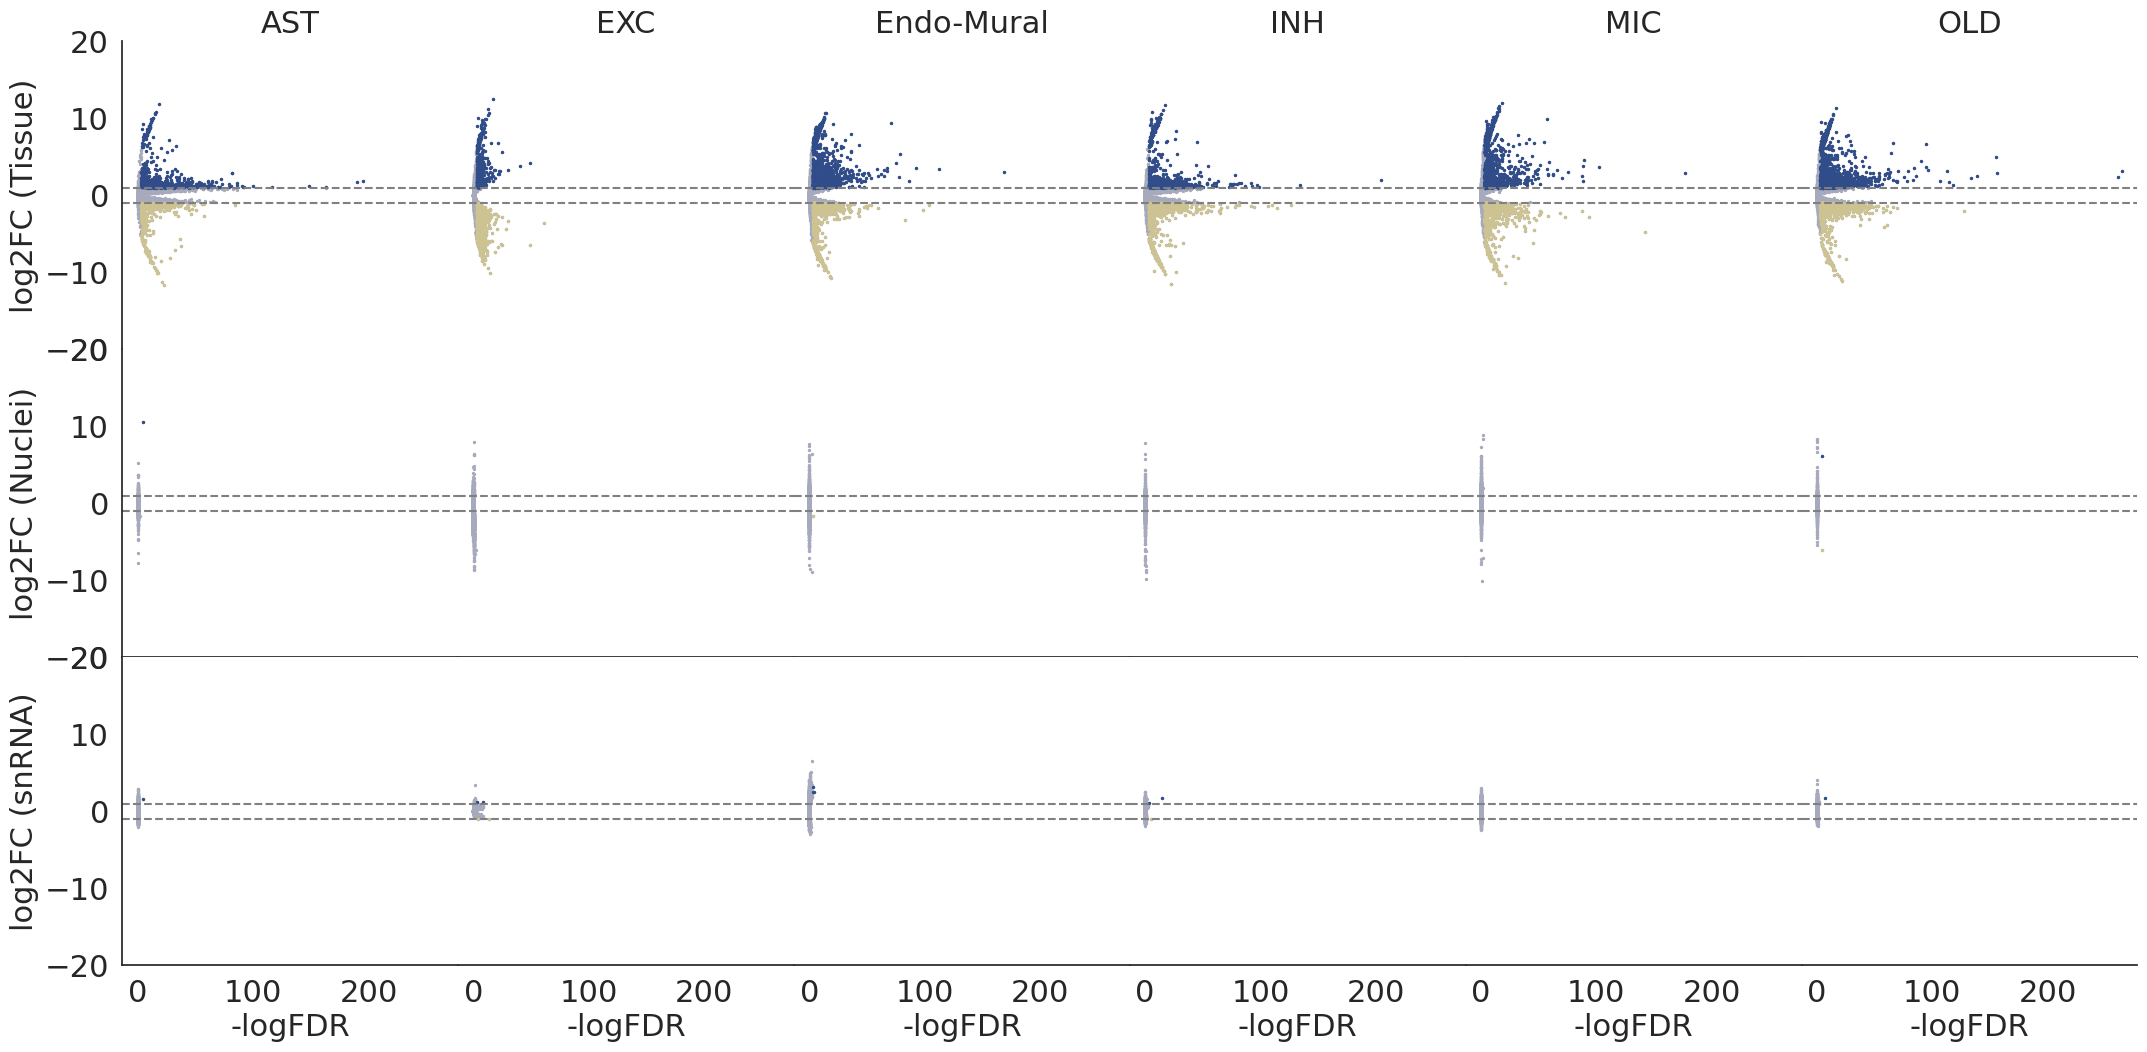

In [277]:
# from adjustText import adjust_text
FC=1
pval=0.05
fontsize=22

fig, axes = plt.subplots(3,6, figsize=(26,12), sharey=True, sharex=True)
axes = axes.flatten()
for ii, ct in enumerate(df_tot.celltypes.unique()):
    print(ct)
    ax = axes[ii]
    tmp = df_tot[(df_tot.celltypes==ct) &(df_tot.Experiments=='Tissue')&(df_tot.Test == "KA3")]
    ax.scatter(y=tmp[lf],x=tmp[pp].apply(lambda x:-np.log(x)),s=2,label="Not significant",c="#A7AABC")
    
    # highlight down- or up- regulated genes
    down = tmp[(tmp[lf]<=-FC)&(tmp[pp]<=pval)]
    up =tmp[(tmp[lf]>=FC)&(tmp[pp]<=pval)]
    
    ax.scatter(y=down[lf],x=down[pp].apply(lambda x:-np.log(x)),s=2,label="Down-regulated",color="#CDC392")
    ax.scatter(y=up[lf],x=up[pp].apply(lambda x:-np.log(x)),s=2,label="Up-regulated",color="#304C89")
    texts=[]
    down = tmp[(tmp[lf]<=-FC)&(tmp[pp]<=pval)]
    # for i,r in down.sort_values(lf)[:3].iterrows():
    #     texts.append(
    #         ax.text(y=r[lf],x=-np.log(r[pp]),s=i))
    # adjust_text(texts,arrowprops=dict(arrowstyle="-", color='black', lw=0.05), ax=ax)
    
    # for i,r in up.sort_values(lf,ascending=False)[:3].iterrows():
    #     texts.append(
    #         ax.text(y=r[lf],x=-np.log(r[pp]),s=i))
            # print(r[pp])
           
    # adjust_text(texts,arrowprops=dict(arrowstyle="-", color='black', lw=0.05), ax=ax)
    
    ax.axhline(-FC,color="grey",linestyle="--")
    ax.axhline(FC,color="grey",linestyle="--")
    #ax.axvline(-np.log10(pval),color="grey",linestyle="--")
    #ax.legend(fontsize=fontsize)
    ax.set_title(ct,fontsize=fontsize)
    ax.spines['top'].set_visible(False)
    ax.spines['bottom'].set_visible(False)

    ax.set_xlabel("-logFDR",fontsize=fontsize)
    if ii==0:
        ax.set_ylabel("log2FC (Tissue)",fontsize=fontsize)
    if ii>0:
        ax.spines['left'].set_visible(False)
    ax.set_ylim(-20,20)
    ax.spines['right'].set_visible(False)
    
for ii, ct in enumerate(df_tot.celltypes.unique()):
    ax = axes[ii+6]
    tmp = df_tot[(df_tot.celltypes==ct) &(df_tot.Experiments=='Nuclei')&(df_tot.Test == "KA3")]
    ax.scatter(y=tmp[lf],x=tmp[pp].apply(lambda x:-np.log(x)),s=2,label="Not significant",c="#A7AABC")
    
    # highlight down- or up- regulated genes
    down = tmp[(tmp[lf]<=-FC)&(tmp[pp]<=pval)]
    up =tmp[(tmp[lf]>=FC)&(tmp[pp]<=pval)]
    
    ax.scatter(y=down[lf],x=down[pp].apply(lambda x:-np.log(x)),s=2,label="Down-regulated",color="#CDC392")
    ax.scatter(y=up[lf],x=up[pp].apply(lambda x:-np.log(x)),s=2,label="Up-regulated",color="#304C89")
    texts=[]
    down = tmp[(tmp[lf]<=-FC)&(tmp[pp]<=pval)]
    # for i,r in down.iterrows():
    #     texts.append(ax.text(x=r[lf],y=-np.log10(r[pp]),s=i))
    # adjust_text(texts,arrowprops=dict(arrowstyle="-", color='black', lw=0.05))
    
    
    ax.axhline(-FC,color="grey",linestyle="--")
    ax.axhline(FC,color="grey",linestyle="--")
    #ax.axvline(-np.log10(pval),color="grey",linestyle="--")
    #ax.legend(fontsize=fontsize)
    # ax.set_title(ct,fontsize=fontsize)
    ax.spines['top'].set_visible(False)
    ax.set_xlabel("-logFDR",fontsize=fontsize)
    if ii==0:
        ax.set_ylabel("log2FC (Nuclei)",fontsize=fontsize)
    if ii>0:
        ax.spines['left'].set_visible(False)
        ax.tick_params(left = False)
    ax.set_ylim(-20,20)
    ax.spines['right'].set_visible(False)
    # ax.set_yscale("log")

for ii, ct in enumerate(df_tot.celltypes.unique()):
    ax = axes[ii+12]
    tmp = df_tot[(df_tot.celltypes==ct) &(df_tot.Experiments=='snRNA')&(df_tot.Test == "KA3")]
    ax.scatter(y=tmp[lf],x=tmp[pp].apply(lambda x:-np.log(x)),s=2,label="Not significant",c="#A7AABC")
    
    # highlight down- or up- regulated genes
 
    down = tmp[(tmp[lf]<=-FC)&(tmp[pp]<=pval)]
    up =tmp[(tmp[lf]>=FC)&(tmp[pp]<=pval)]
    
    ax.scatter(y=down[lf],x=down[pp].apply(lambda x:-np.log(x)),s=2,label="Down-regulated",color="#CDC392")
    ax.scatter(y=up[lf],x=up[pp].apply(lambda x:-np.log(x)),s=2,label="Up-regulated",color="#304C89")
    texts=[]
    down = tmp[(tmp[lf]<=-FC)&(tmp[pp]<=pval)]
    # for i,r in down.iterrows():
    #     texts.append(ax.text(x=r[lf],y=-np.log10(r[pp]),s=i))
    # adjust_text(texts,arrowprops=dict(arrowstyle="-", color='black', lw=0.05))
    
    
    ax.axhline(-FC,color="grey",linestyle="--")
    ax.axhline(FC,color="grey",linestyle="--")
    #ax.axvline(-np.log10(pval),color="grey",linestyle="--")
    #ax.legend(fontsize=fontsize)
    # ax.set_title(ct,fontsize=fontsize)
    ax.spines['top'].set_visible(False)
    ax.set_xlabel("-logFDR",fontsize=fontsize)
    if ii==0:
        ax.set_ylabel("log2FC (snRNA)",fontsize=fontsize)
    if ii>0:
        ax.spines['left'].set_visible(False)
        ax.tick_params(left = False)
    ax.set_ylim(-20,20)
    ax.spines['right'].set_visible(False)
fig.subplots_adjust(wspace=0, hspace=0)

plt.savefig(os.path.join(savepath, "volcano_ka3_wt_tissue_nuclei.svg"))
plt.show()

/tmp/ipykernel_1576951/296921154.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  de["GeneName"] = de.index.tolist() #["name"].values
/tmp/ipykernel_1576951/296921154.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  de["condition"] = de["Test"]  + "_" + de["Experiments"]


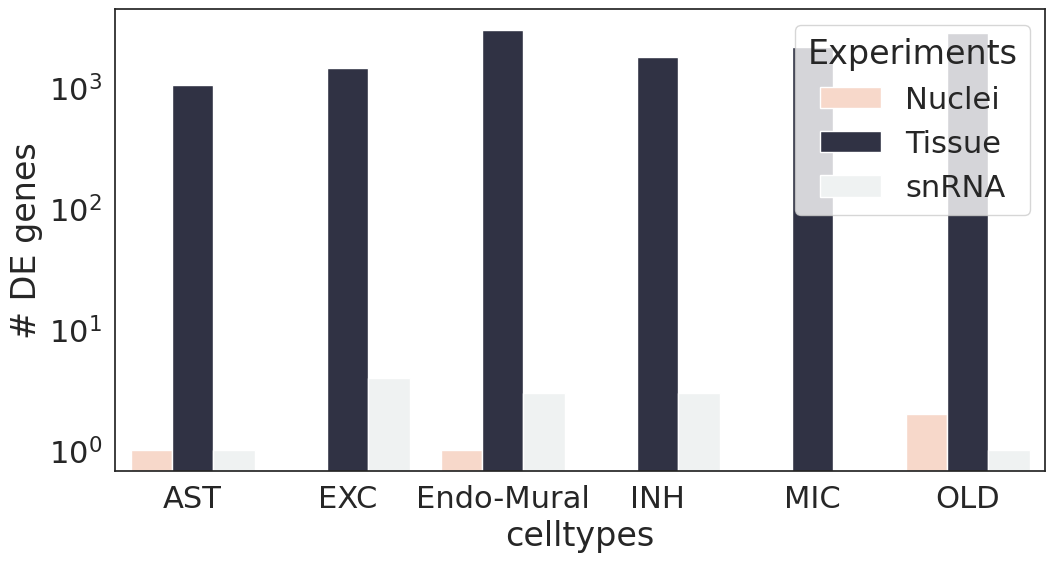

In [293]:
FC=1
palette_exp = {"Tissue":"#2D3047", "Nuclei":"#ffd5c2", "snRNA":"#eef2f3"}
de = df_tot[(df_tot[pp]<=0.05) &(np.abs(df_tot[lf])>FC)]
de
de["GeneName"] = de.index.tolist() #["name"].values
de["condition"] = de["Test"]  + "_" + de["Experiments"]
de
ss = de.groupby(["Experiments", "celltypes",  "Test"]).size().reset_index().rename({0:"# DE genes"}, axis=1)
palette= {"KO":"#0b244a", "WT":"#dfb920"}
palette= {"ko":"#0b244a", "wt":"#dfb920"}

sns.set(font_scale=2, style="white")
fig, ax = plt.subplots(figsize=(12,6))
sns.barplot(data=ss[ss.Test=="KA3"].sort_values("celltypes"),  x="celltypes", hue="Experiments", y="# DE genes", ax=ax, palette=palette_exp)#, height=5, aspect=2)#, palette=palette)
ax.set_yscale("log")
plt.savefig(savepath + "DE_genes_overview_KA3.svg")

In [284]:
import gseapy
from gseapy import dotplot
import matplotlib.colors
from matplotlib import lines


def get_go(gene_list, background,ct,cutoff=0.05,
        dtbs = ['GO_Biological_Process_2023','GO_Molecular_Function_2023', 'GO_Cellular_Component_2023'],#"BioPlanet_2019"]
         #  dtbs = [ 'TRANSFAC_and_JASPAR_PWMs', 'TRRUST_Transcription_Factors_2019','BioPlanet_2019',]#'MSigDB_Hallmark_2020', 'Pfam_Domains_2019',
# dtbs = ['MSigDB_Hallmark_2020','KEGG_2021_Human','Reactome_2022', 'WikiPathway_2023_Human']#, 'BioCarta_2016']
          #dtbs=["GWAS_Catalog_2019"]
          ):
    terms = []
    for it in dtbs :
    # if True:
        enr_res = gseapy.enrichr(gene_list=gene_list,
                     organism='Mouse',
                    background=background,
                     gene_sets=it,
                     cutoff = cutoff)
        gg = enr_res.res2d
        gg["database"] = it
        gg["Number of genes"] = gg["Genes"].apply(lambda x: len(x.split(";")))
        gg = gg[gg["Number of genes"]>1]
        terms.append(gg)
        if len(gg[gg["Adjusted P-value"]<=cutoff])>0:
            # print(gg[gg["Adjusted P-value"]<=cutoff])
            colors =["#88352b","#ebceb1","#eee9de","#929489","#576169"]
            cmap = mcolors.LinearSegmentedColormap.from_list('my_colormap', colors)
            ax =gp.barplot(gg, figsize=(3,6.5), title=ct+ ": GO enrichment",
                    cutoff = cutoff, cmap = cmap)
            print(ax.get_yticklabels())
            ytick = [it.get_text().split("(GO")[0] for it in ax.get_yticklabels()]
            ax.set_yticklabels(ytick)     
            plt.savefig("figures/MU_meGo_enrichment_up_%s.svg"%ct)
            plt.show()
    
    return pd.concat(terms)
def get_go_prerank(gene_list_df, background,
                dtbs = ['GO_Biological_Process_2023','GO_Molecular_Function_2023', 'GO_Cellular_Component_2023']#,"BioPlanet_2019"]
                  # dtbs = [ 'TRANSFAC_and_JASPAR_PWMs', 'TRRUST_Transcription_Factors_2019','BioPlanet_2019',]#'MSigDB_Hallmark_2020', 'Pfam_Domains_2019',
            #dtbs = ['MSigDB_Hallmark_2020','KEGG_2021_Human','Reactome_2016', 'WikiPathways_2019_Human', 'BioCarta_2016']
                            # dtbs=["GWAS_Catalog_2019"]

                  ):
    terms = []
    
    for it in dtbs :
        
        enr_res = gseapy.prerank(rnk=gene_list_df,
                     organism='Mouse',
                    min_size=1,
                    background=background,
                     gene_sets=it,
                     cutoff = 0.05)
        gg = enr_res.res2d
        gg["database"] = it
        terms.append(gg)
        try:
            ax = dotplot(gg,
                 column="FDR q-val",
                 title=it,
                 cmap=plt.cm.viridis,
                 size=3, # adjust dot size
                 figsize=(4,5), cutoff=0.05, show_ring=False)
            plt.show()
        except:
            print("ok")
    
    return pd.concat(terms)


from scattermap import scattermap
def plot_GO(concat_all, celltype,savepath, FC, score_key="overlap_ratio",values= "-log(p-value)",mix_brain_region=False,comp = "wt_KA3_Tissue"):
    
    
    palette = { 'GO_Biological_Process_2021':"#885A89", ##66c2a5",
               #'GO_Cellular_Component_2021':"#fc8d62",
               "GO_Cellular_Component_2021":"#8AA8A1",
               'GO_Molecular_Function_2021':"#3B3B3B",
               'DisGeNET':"#e78ac3","BioPlanet_2019":"#2E294E", 'KEGG_2021_Human':"#a6d854", "MSigDB_Hallmark_2020":"#e78ac3",'WikiPathways_2019_Mouse':"#ff7f00",
              'WikiPathways_2019_Human':"#ff7f00",'GWAS_Catalog_2019':"#ff7f00","SynGO_2022":"#ff7f00","SubCell_BarCode":"#ff7f00",
              'Reactome_2016':"#cab2d6",'BioCarta_2016':"#DB7C26",'KEGG_2019_Mouse':"#a6d854","Jensen_COMPARTMENTS":"#a6d854"}
    list_to_plot = [['GO_Biological_Process_2021','GO_Cellular_Component_2021','GO_Molecular_Function_2021'],
                    ['KEGG_2021_Human',"MSigDB_Hallmark_2020",
                  'WikiPathways_2019_Human',
              'Reactome_2016','BioCarta_2016']]

    norm=plt.Normalize(1,150)
    colorlist=["darkorange", "gold", "lawngreen", "lightseagreen"]
    newcmp = LinearSegmentedColormap.from_list('testCmap', colors=colorlist, N=256)
    palette = [#"#272300","#443F1C","#746E48","#A9A179",
               "#CDC392","#E8E5DA","#9EB7E5","#648DE5","#304C89"]#, "#08336D"]
    newcmp= mcolors.LinearSegmentedColormap.from_list('my_colormap', palette)
    # colors = [start_color, end_color]
    # cmap = LinearSegmentedColormap.from_list('my_cmap', palette)

    list_to_plot = [concat_all.Gene_set.unique().tolist()]
    for dtb in list_to_plot:
        dtt = concat_all[concat_all.Gene_set.isin( dtb)]
        if len(dtt) >0:
            fig, ax = plt.subplots(figsize=(5, dtt["Term"].nunique()/2*1))
            ax.grid()
            #dtt = dtt[dtt.comparison==comp]
            dtt["cond_region_celltype"] =  dtt["comparison"] + "|" + dtt["celltype"]

            dtt["Term"] = dtt["Gene_set"] + "|" + dtt["Term"]
            dtts = dtt.pivot(index="Term", columns="cond_region_celltype", values=values)
            
            #dtt[score_key] *= 100
            dtt[score_key] = np.ceil(dtt[score_key]).values
            dtt[score_key] = np.ceil(dtt[score_key]).values

        
            dtts_size = dtt.pivot(index="Term", columns="cond_region_celltype", values=score_key).fillna(0).astype(int)
            all_comb = ["%s|%s"%(comp,ct) for ct in celltype ]
            for it in all_comb:
                if not it in dtts.columns.tolist():
                    dtts[it] = np.nan
                    dtts_size[it] = 0
            dtts = dtts[all_comb]
            dtts_size = dtts_size[all_comb]
            max_or = dtts_size.max().max()
            print(" max : " +  str(max_or))
            dtts_size.fillna(0, inplace=True)
            min_or = dtts_size[dtts_size!=0].min().min()
            print(" min :" + str(min_or))
            ofs = 10#0
            dtts_size = dtts_size.values*ofs
            plt.rcParams.update({'font.size': 18})
            with sns.axes_style("whitegrid"):
                ax = scattermap(dtts, marker_size=dtts_size, cmap=newcmp,
                                ax=ax, cbar_kws={"shrink":0.5})


            for label in (ax.get_xticklabels()):
                #print(label)
            
               
                ct_t = label.get_text().split("_")[0]
                #cond = label.get_text().split("|")[0]
                label.set(color="k", label=ct_t, fontsize=18, rotation=90 )
            for label in (ax.get_yticklabels()):

                cc = label.get_text().split("|")[0]
                txt = label.get_text().split("|")[-1] + "(" + cc[1] + ")"
                label.set( label=txt, fontsize=18)#color=palette[cc],
            labels = [item.get_text().split("|")[1] for item in ax.get_xticklabels()]
            ax.set_xticklabels(labels)
            labels = [item.get_text().split("|")[-1].split("(")[0] for item in ax.get_yticklabels()]
            ax.set_yticklabels(labels) 
            ll = []

            blue_line = lines.Line2D([], [], color="grey", 
                                                    marker="o",
                                                    linestyle='None',
                                                    markersize=np.sqrt(min_or*ofs),
                                     label=min_or)
            ll.append(blue_line)
            blue_line = lines.Line2D([], [], color="grey", 
                                                    marker="o",
                                                    linestyle='None',
                                                    markersize=np.sqrt(max_or*ofs), 
                                                     label=max_or)
            ll.append(blue_line)   
            leg1 = plt.legend(handles=ll, bbox_to_anchor=(1.5, 0.25), labelspacing=1, borderpad=0.5, title=score_key)
            ll = []
            
       
            ax.add_artist(leg1)
            ax.set_xlabel("")
            ax.set_ylabel("")
            ax.set_title( "".join(dtb) )#+ " FC " + str(FC) )
            # if mix_brain_region:
            #     plt.savefig(savepath + "ALLregionEnrichr" + str(FC) + "".join(dtb) + ".png", bbox_inches="tight")
            # else:
            plt.savefig(savepath + "Enrichr" + "".join(dtb) + ".svg", bbox_inches="tight")
            plt.show()
            plt.close("all")

In [ ]:
# gss  = gseapy.get_library_name(organism='Mouse')
# import gseapy as gp
# pval=0.05
# comp = "wt_KA3_Tissue"
# comp2= "wt_KA3_Nuclei"
# FC=1
# nb_genes=1000
# lf="log2FoldChange"
# df_dif = df_tot[df_tot.Test =="KA3"]
# term_list = []
# for ii,ct in enumerate(celltypes):
#     #if ct!="AST":
#         print(ct)
#         bg = np.asarray(genes)[np.where(mask[ii,:]==1)[0]].tolist()
#         new_bg = []
#         # for gene in bg:
#         #     if gene in m2h_dict: 
#                 # new_bg.append(m2h_dict[gene])
#         # gg_no_want = df_dif[(df_dif.celltypes == ct)&(df_dif.condition == comp)&(df_dif.padj>0.05)]["gene"].tolist()
#         gene_list = df_dif[(df_dif.celltypes == ct)&(df_dif.padj <=pval) 
#                     & (df_dif["log2FoldChange"]>=FC)].sort_values("log2FoldChange"
#                                                             , ascending=False)#.index.tolist()&(np.abs(df_dif["log2FoldChange"])>2.5)
#         gg = gene_list["gene"].tolist()[:nb_genes]
#         #gg = [it for it in gg if it not in gg_no_want]
#         print(len(gg))

#         # new_gg = []
#         # for gene in gg:
#         #     if gene in m2h_dict: 
#         #         new_gg.append(str(m2h_dict[gene]))
#         gg = [it.upper() for it in gg]
#         # print(len(new_gg))
#         # gene_list.index = gg
#         # gene_list = gene_list[["log2FoldChange"]].sort_values("log2FoldChange")
#         # print(gene_list)
#         # tmp = get_go_prerank(gene_list, bg)#, genes,dtbs=["Jensen_COMPARTMENTS"])#, dtbs=[ "SynGO_2022", "GO_Cellular_Component_2021"])#

#         tmp = get_go(gg, genes,ct,cutoff=0.05)#, dtbs=["Jensen_COMPARTMENTS"])#, dtbs=['WikiPathways_2019_Mouse',"KEGG_2019_Mouse"])#, dtbs=[ "SynGO_2022", "GO_Cellular_Component_2021","GWAS_Catalog_2019"])#
#         tmp["celltype"] = ct
#         tmp["regulation"] = "up"
#         tmp["comparison"] = comp
#         term_list.append(tmp)
        

In [234]:
df_tot.Experiments.unique()
#[(df_tot[pp]<=0.05)&(df_tot["celltypes"] ==ct) 
#               & (df_tot.Test =="KA3")
#                & (df_tot[lf]>=FC)].sort_values(lf, ascending=False)

array(['Tissue', 'Nuclei', 'snRNA'], dtype=object)

416
636
947
507
[Text(0, 0, 'Ficolin-1-Rich Granule (GO:0101002)'), Text(0, 1, 'Intracellular Membrane-Bounded Organelle (GO:0043231)')]


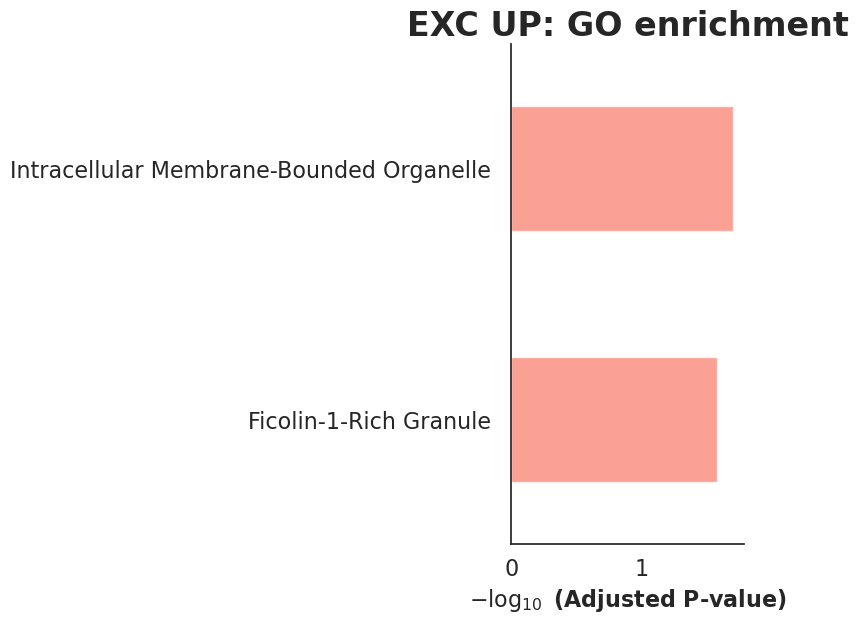

[Text(0, 0, 'RNA Binding (GO:0003723)'), Text(0, 1, 'Cell Adhesion Mediator Activity (GO:0098631)')]


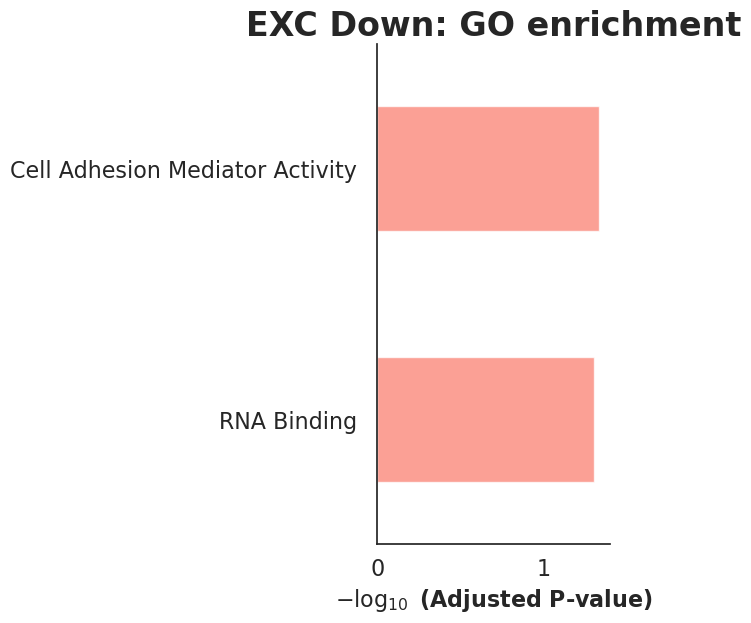

[Text(0, 0, 'Dihydrolipoyl Dehydrogenase Complex (GO:0045240)'), Text(0, 1, 'Bounding Membrane Of Organelle (GO:0098588)'), Text(0, 2, 'Nucleus (GO:0005634)'), Text(0, 3, 'Endoplasmic Reticulum Membrane (GO:0005789)'), Text(0, 4, 'Recycling Endosome (GO:0055037)'), Text(0, 5, 'Asymmetric Synapse (GO:0032279)'), Text(0, 6, 'Neuron Projection (GO:0043005)'), Text(0, 7, 'Intracellular Membrane-Bounded Organelle (GO:0043231)')]


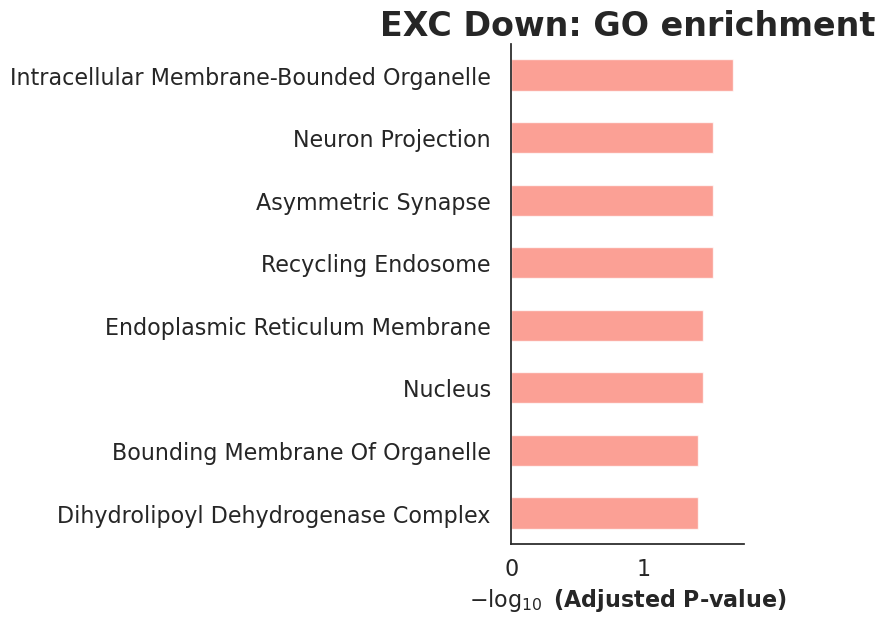

1181
1811
[Text(0, 0, 'Intracellular Non-Membrane-Bounded Organelle (GO:0043232)')]


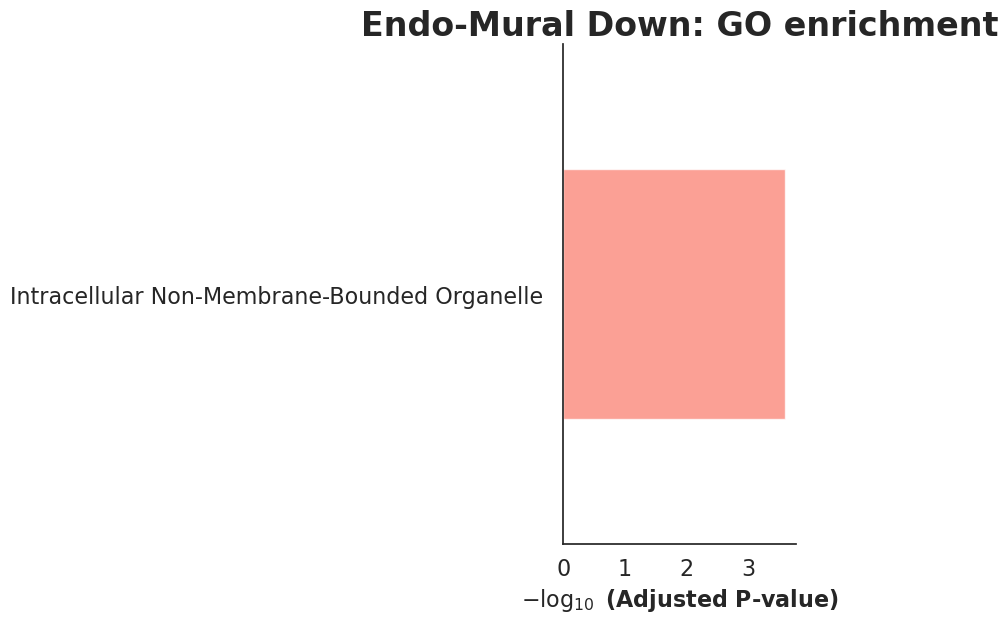

962
826
[Text(0, 0, 'Mitotic Spindle Microtubule (GO:1990498)')]


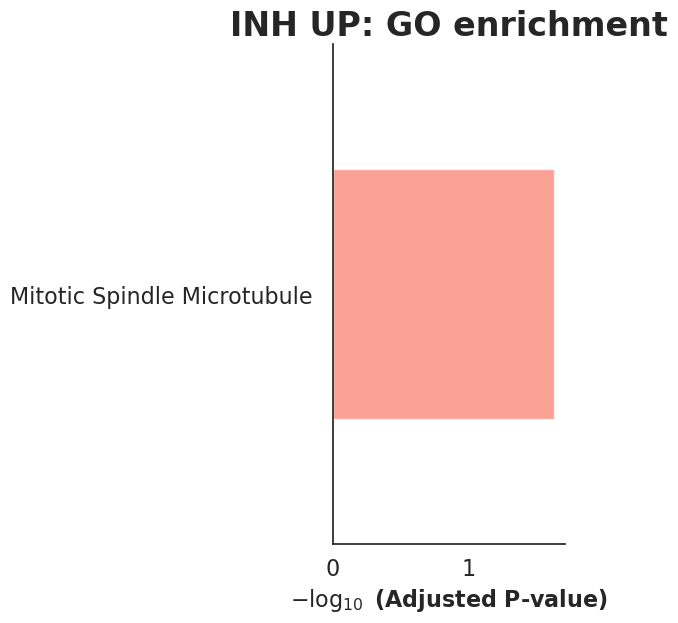

873
1301
[Text(0, 0, 'Cytoskeleton (GO:0005856)')]


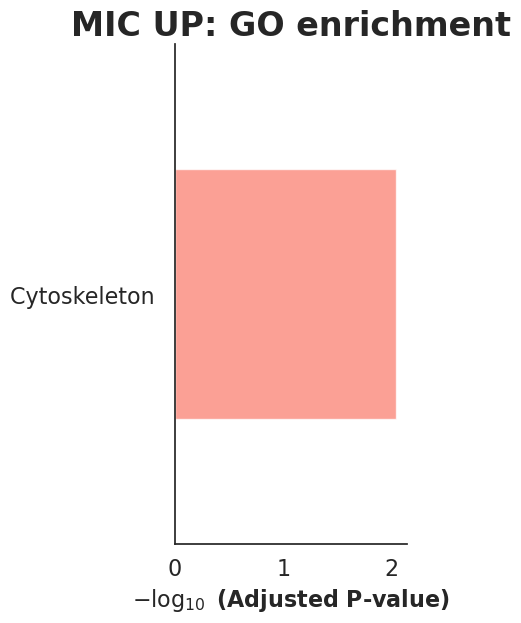

1100
1750
[Text(0, 0, 'Vacuolar Proton-Transporting V-type ATPase Complex (GO:0016471)'), Text(0, 1, 'Lytic Vacuole Membrane (GO:0098852)'), Text(0, 2, 'Lysosomal Membrane (GO:0005765)'), Text(0, 3, 'Proton-Transporting V-type ATPase Complex (GO:0033176)'), Text(0, 4, 'Mitochondrial Respiratory Chain Complex III (GO:0005750)'), Text(0, 5, 'Respiratory Chain Complex III (GO:0045275)')]


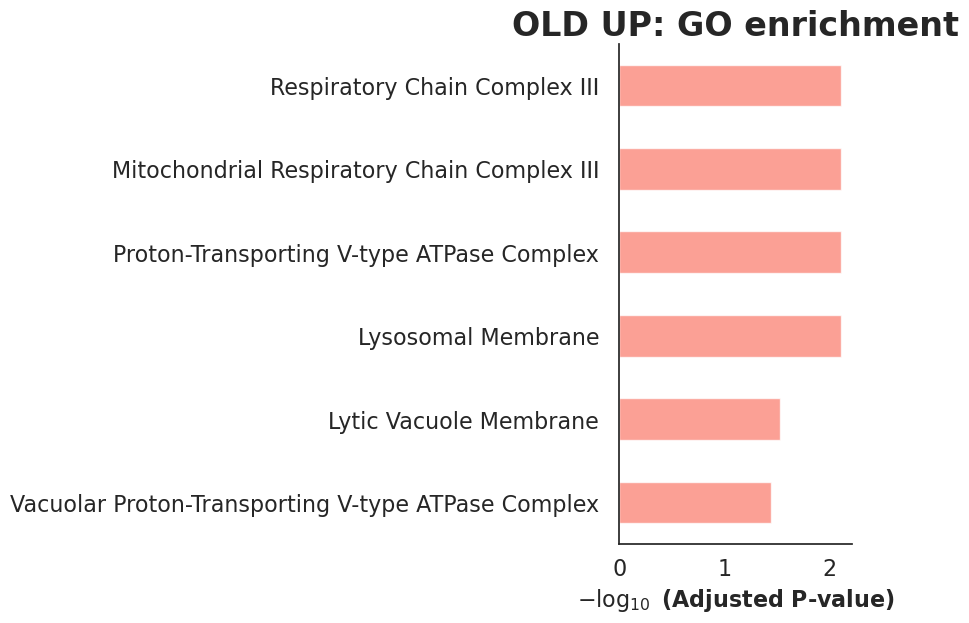

In [291]:
import gseapy as gp
import matplotlib.colors as mcolors
colors =["#88352b","#ebceb1","#eee9de","#929489","#576169"]
cmap = mcolors.LinearSegmentedColormap.from_list('my_colormap', colors)
ct="OPC"
FC=1
pvl = 0.05
cutoff =0.05
nb_genes = 50000
pp = "padj" #"padj"
type_="go"
lf="log2FoldChange"
all_up = []
all_down=[]
for ii, ct in enumerate(celltypes):
    to_remove = df_tot[((df_tot[pp]<=pvl)&(df_tot["celltypes"] ==ct) 
                &(df_tot["Experiments"] =="Nuclei")
                & (df_tot.Test =="KA3")
                & (df_tot[lf]>=0))
                    ].sort_values(lf, ascending=False).gene.tolist()
    to_remove2 = df_tot[((df_tot[pp]<=pvl)&(df_tot["celltypes"] ==ct) 
                &(df_tot["Experiments"] =='snRNA')
                & (df_tot.Test =="KA3")
                & (df_tot[lf]>=0))
                    ].sort_values(lf, ascending=False).gene.tolist()
    tmp = df_tot[((df_tot[pp]<=pvl)&(df_tot["celltypes"] ==ct) 
                &(df_tot["Experiments"]=="Tissue")
                & ~(df_tot["gene"].isin(to_remove+to_remove2))
                & (df_tot.Test =="KA3")
                & (df_tot[lf]>=FC))].sort_values(lf, ascending=False).gene.tolist()[:nb_genes]
    
    # background = df_tissue[df_tissue["celltypes"] ==ct][genes]
    # background = background.loc[:, background.sum(0)>0].columns.tolist()
    background = np.asarray(genes)[np.where(mask[ii,:]==1)[0]].tolist()
    # background=genes

    to_remove = df_tot[((df_tot[pp]<=pvl)&(df_tot["celltypes"] ==ct) 
                &(df_tot["Experiments"] =="Nuclei")
                & (df_tot.Test =="KA3")
                & (df_tot[lf]<=0))
                    ].sort_values(lf, ascending=False).gene.tolist()
    to_remove2 = df_tot[((df_tot[pp]<=pvl)&(df_tot["celltypes"] ==ct) 
                &(df_tot["Experiments"] =='snRNA')
                & (df_tot.Test =="KA3")
                & (df_tot[lf]<=0))
                    ].sort_values(lf, ascending=False).gene.tolist()
    tmp_d = df_tot[(df_tot[pp]<=pvl)&(df_tot["celltypes"] ==ct) 
                & ~(df_tot["gene"].isin(to_remove+to_remove2))
                    & (df_tot.Test =="KA3")
                    & (df_tot[lf]<=-FC)].sort_values(lf).gene.tolist()[:nb_genes]
    print(len(tmp_d))
    
    # try:
    # print(ct)
    # tmp = dico_genes_up[ct].gene.tolist()#[:nb_genes]
    print(len(tmp))
    # tmp_d = dico_genes_down[ct].gene.tolist()#[:nb_genes]
    # print(len(tmp_d))
    if type_=="go":
     
        go_up = get_go(tmp, background, ct+ " UP", cutoff=cutoff)
        go_up = go_up[go_up["Adjusted P-value"]<=cutoff].sort_values("Adjusted P-value",ascending=True)
        go_up['Direction'] = ct
    

        go_down = get_go(tmp_d, background, ct+ " Down", cutoff=cutoff)
        go_down = go_down[go_down["Adjusted P-value"]<=cutoff].sort_values("Adjusted P-value",ascending=True)
        go_down['Direction'] = ct
    else:
       
        go_up = get_go(tmp, background, ct+ " Up", cutoff=cutoff,
                       dtbs = ['MSigDB_Hallmark_2020',
                                                       'KEGG_2021_Human','Reactome_2022', 
                                                       'WikiPathway_2023_Human'])
        go_up = go_up[go_up["Adjusted P-value"]<=cutoff].sort_values("Adjusted P-value",ascending=True)
        go_up['Direction'] = ct 
    
        go_down = get_go(tmp_d, background, ct+ " Down", cutoff=cutoff,
                           dtbs = ['MSigDB_Hallmark_2020',
                                                       'KEGG_2021_Human','Reactome_2022', 
                                                       'WikiPathway_2023_Human'])
        go_down = go_down[go_down["Adjusted P-value"]<=cutoff].sort_values("Adjusted P-value",ascending=True)
        go_down['Direction'] = ct 
    all_up.append(go_up.head(3))
    all_down.append(go_down.head(3))





In [266]:
cutoff

0.05

/tmp/ipykernel_1576951/2655825435.py:22: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels(ytick)
/tmp/ipykernel_1576951/2655825435.py:24: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), rotation=90)


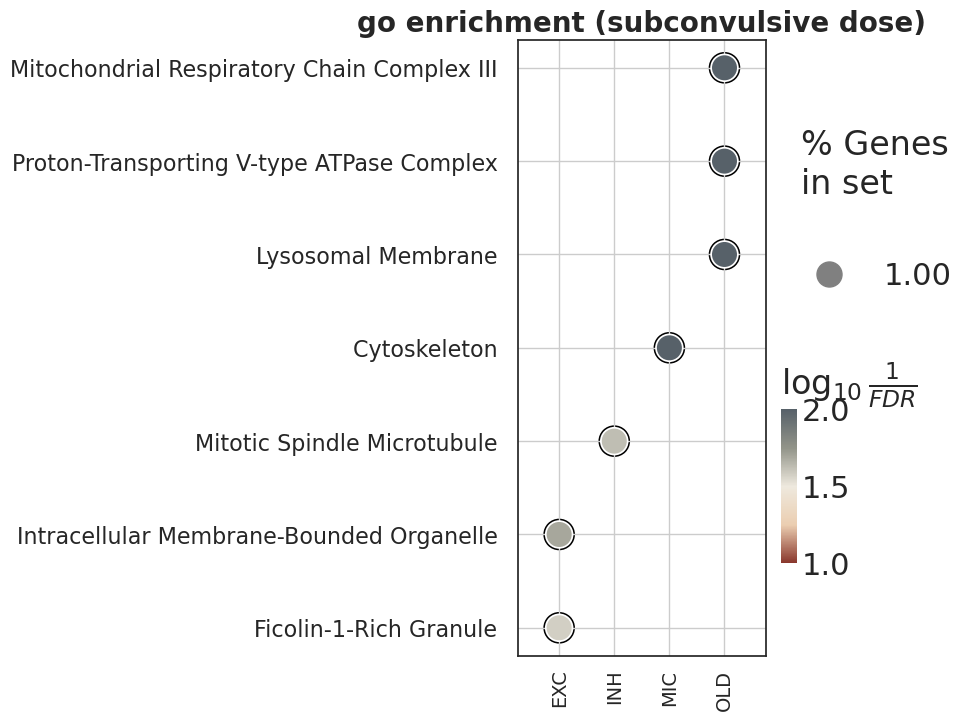

/tmp/ipykernel_1576951/2655825435.py:47: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels(ytick)
/tmp/ipykernel_1576951/2655825435.py:48: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), rotation=90)


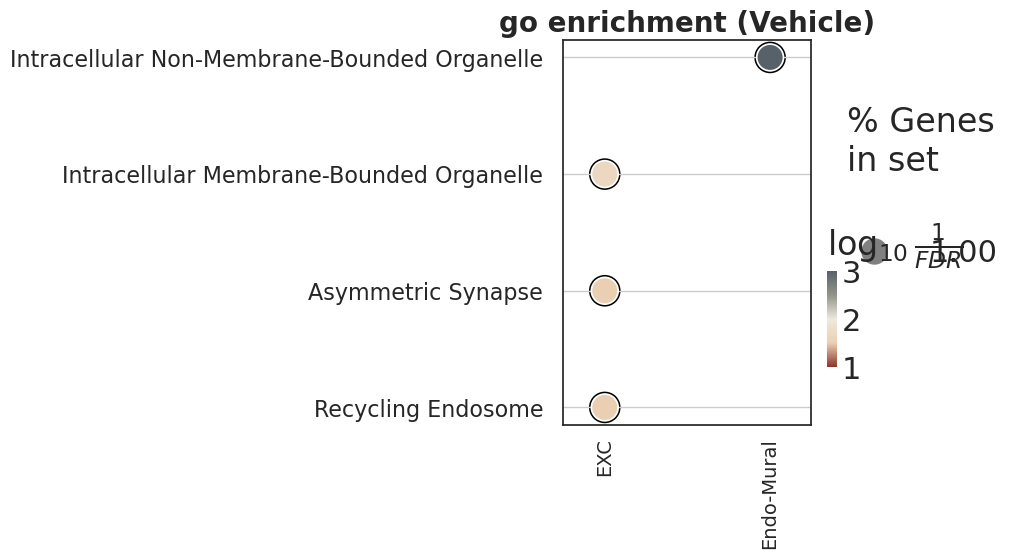

/tmp/ipykernel_1576951/2655825435.py:70: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels(ytick)
/tmp/ipykernel_1576951/2655825435.py:71: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), rotation=90)


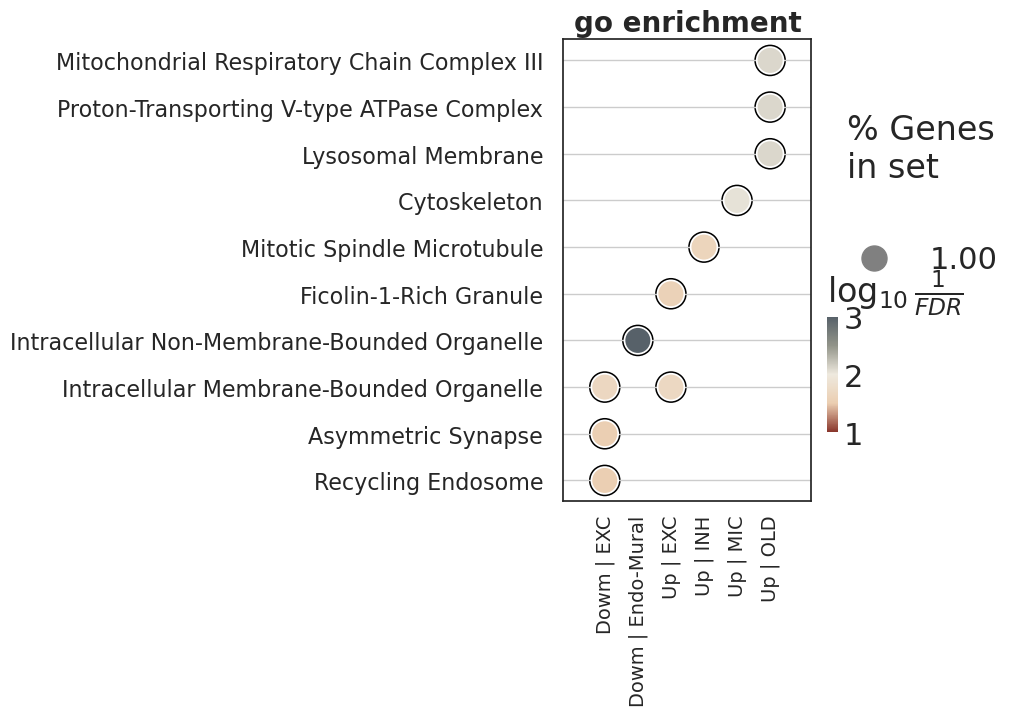

In [292]:
replacement = {}#"Histone Acetyltransferase Complex":"HAC", 
               # "Region Sequence-Specific DNA Binding":"RSS DNA Binding"}
import re
enr_res_up = pd.concat(all_up)
# print(enr_res_up)
name = type_#"booostrap_" + type_
enr_res_up["Number of genes"] = enr_res_up["Genes"].apply(lambda x: len(x.split(";")))
enr_res_up = enr_res_up[enr_res_up["Number of genes"] >1]

# enr_res_up = enr_res_up[~enr_res_up["Direction"].str.contains("Endo")]
if len(enr_res_up[enr_res_up["Adjusted P-value"]<=cutoff])>0:
    c_order = [it for it in celltypes if it in enr_res_up.Direction.unique()]
    ax = gp.dotplot(enr_res_up,figsize=(4,8),
                    x='Direction',
                    x_order = c_order,
                    title=name + " enrichment (subconvulsive dose)",
                    cmap = cmap,
                    size=3,
                    cutoff=cutoff,
                    show_ring=True)
    ytick = [it.get_text().split("(GO")[0].split("R-HSA")[0] for it in ax.get_yticklabels()]
    ax.set_yticklabels(ytick)
    ax.grid(axis="x")
    ax.set_xticklabels(ax.get_xticklabels(), rotation=90)
    ax.set_xlabel("")
    plt.savefig("figures/%s_UP_mice_ad_all.svg"%(name))
    plt.show()

enr_res_down = pd.concat(all_down)
enr_res_down["Number of genes"] = enr_res_down["Genes"].apply(lambda x: len(x.split(";")))
enr_res_down = enr_res_down[enr_res_down["Number of genes"] >1]
if len(enr_res_down[enr_res_down["Adjusted P-value"]<=cutoff])>0:
    c_order = [it for it in celltypes if it in enr_res_down.Direction.unique()]

    ax = gp.dotplot(enr_res_down,figsize=(4,5),
                    x='Direction',
                    x_order = c_order,
                    title=name + " enrichment (Vehicle)",
                    cmap = cmap,
                    size=3,
                    cutoff=cutoff,
                    show_ring=True)
    ytick = [it.get_text().split("(GO")[0].split("R-HSA")[0] for it in ax.get_yticklabels()]
    ytick = [re.split("WP[0-9]",it)[0]for it in ytick]
    for k,v in replacement.items():
        ytick = [ it.replace(k,v) for it in ytick]
    ax.set_yticklabels(ytick)
    ax.set_xticklabels(ax.get_xticklabels(), rotation=90)
    ax.set_xlabel("")
    plt.savefig("figures/%s_DOWN_mice_ad_all.svg"%(name))
    plt.show()
enr_res_down["Direction"] = "Dowm | " + enr_res_down["Direction"] 
enr_res_up["Direction"] = "Up | " + enr_res_up["Direction"] 
enr_ = pd.concat([enr_res_up,enr_res_down])
if len(enr_[enr_["Adjusted P-value"]<=cutoff])>0:
    # c_order = [it for it in celltypes if it in enr_.Direction.unique()]

    ax = gp.dotplot(enr_,figsize=(4,6),
                    x='Direction',
                    # x_order = c_order,
                    title=name + " enrichment",
                    cmap = cmap,
                    size=3,
                    cutoff=cutoff,
                    show_ring=True)
    ytick = [it.get_text().split("(GO")[0].split("R-HSA")[0] for it in ax.get_yticklabels()]
    ytick = [re.split("WP[0-9]",it)[0]for it in ytick]
    for k,v in replacement.items():
        ytick = [ it.replace(k,v) for it in ytick]
    ax.set_yticklabels(ytick)
    ax.set_xticklabels(ax.get_xticklabels(), rotation=90)
    ax.set_xlabel("")
    plt.savefig("figures/%s_BOTH_mice_all.svg"%(name))
    plt.show()